In [7]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

In [8]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [11]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [12]:
AUD_PATH = '/content/drive/MyDrive/Annamayya'
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [13]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 60 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

data['Offset'].fillna(60,inplace=True)

In [14]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [15]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [16]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
ధన్నాసి         20
మలహరి           20
కాంబోది         19
మాళవి           18
మాళవిగౌళ        18
గుజ్జరి         15
కన్నడగౌళ        15
గౌళ             14
బౌళిరామక్రియ    13
సాళంగం          11
నాదరామక్రియ     11
Name: Ragam, dtype: int64

In [17]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


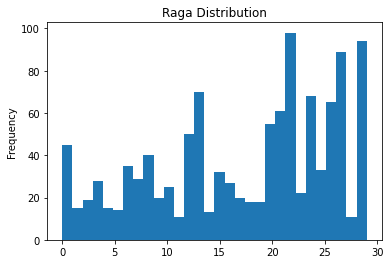

In [18]:
for c in le.classes_: print(f'{c} : {le.transform([c])}')
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [19]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [68]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(labels),
                                         y = labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [21]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [22]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions, s='micro'):
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [23]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      model.train()
  else:
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [24]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [25]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [72]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
  target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data[target]
  ovl_best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[feature], data[target])):
    print(f'FOLD {fold + 1} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        ovl_best_scores = update_best_result(ovl_best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions)
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Epoch {epoch+1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time Taken : {(e_end - e_start).total_seconds()} seconds]')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(best_scores['train_labels'],best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(best_scores['test_labels'],best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Fold {fold+1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(ovl_best_scores['train_labels'],ovl_best_scores['train_predictions']))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(ovl_best_scores['test_labels'],ovl_best_scores['test_predictions']))
  if plot: plot_results(results, title)
  return results

In [27]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# OVR Experiment 1 - MFCC Feed Forward

In [28]:
FREQ = 16000
DURATION = 120
mfcc_tx = transforms.MFCC(FREQ, n_mfcc=40)
def get_mfcc(x, aud_path, mfcc_tx):
  aud_path = os.path.join(aud_path, x['MP3 File'])
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, 
                                          frame_offset=int(x['Offset']*i.sample_rate), 
                                          num_frames= DURATION*i.sample_rate)
  waveform = librosa.to_mono(waveform)
  resampler = transforms.Resample(sample_rate, FREQ)
  if len(waveform) > 0 :
    waveform = resampler(torch.tensor(waveform))
    mfcc = mfcc_tx(waveform)
  else:
    mfcc = []
  return mfcc
data['mfcc'] = data.apply(lambda x:get_mfcc(x, AUD_PATH, mfcc_tx),axis=1)
data = data[data.apply(lambda x:not isinstance(x['mfcc'],list),axis=1)]

In [29]:
class MfccMatrixDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __get__(self,index):
      if self.mfcc_vals[index].shape[1] < 9601:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(40,9601-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mfcc'].iloc[x] for x in train_ids]
      test_vals = [data['mfcc'].iloc[x] for x in test_ids]
      train_data = MfccMatrixDataset(train_lbls, train_vals)
      test_data = MfccMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [30]:
class MfccRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MFCC Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(384000,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

In [110]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc'):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: print(f'Training for {lbl_encoder.inverse_transform([i])} with {nsamples} positive samples')
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : False,
                                   'lr' : 1e-4,
                                   'clip_at' : None,
                                   'k_folds' : 2,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['ఆహిరి'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/10 : Training Loss: 67.581 / Validation Loss : 26.480 [Time Taken : 3.392327 seconds]
Epoch 2/10 : Training Loss: 8.752 / Validation Loss : 35.559 [Time Taken : 3.335943 seconds]
Epoch 3/10 : Training Loss: 4.230 / Validation Loss : 29.781 [Time Taken : 3.395055 seconds]
Epoch 4/10 : Training Loss: 3.508 / Validation Loss : 29.562 [Time Taken : 3.352503 seconds]
Epoch 5/10 : Training Loss: 2.418 / Validation Loss : 26.297 [Time Taken : 3.407009 seconds]
Epoch 6/10 : Training Loss: 1.454 / Validation Loss : 31.137 [Time Taken : 3.374896 seconds]
Epoch 7/10 : Training Loss: 1.155 / Validation Loss : 26.340 [Time Taken : 3.401244 seconds]
Epoch 8/10 : Training Loss: 0.786 / Validation Loss : 28.010 [Time Taken : 3.377674 seconds]
Epoch 9/10 : Training Loss: 0.515 / Validation Loss : 25.537 [Time Taken : 3.364533 seconds]
Epoch 10/10 : Training Loss: 

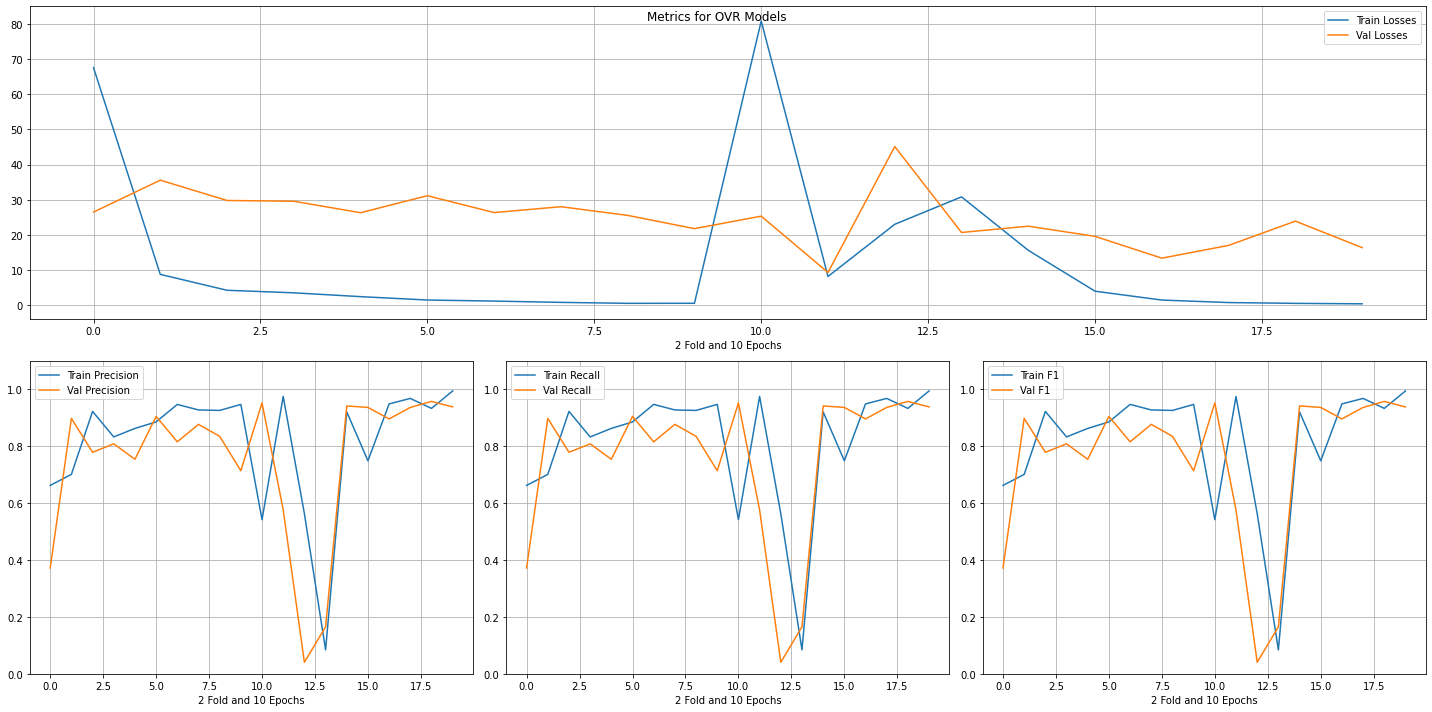

   train_f1  validation_f1  ...  train_losses  validation_losses
8  0.933333       0.957821  ...      0.508715          23.904356
0  0.542105       0.952548  ...     80.846516          25.316915
4  0.921053       0.942004  ...     15.597659          22.465629
9  0.994737       0.938489  ...      0.377529          16.362918
5  0.749123       0.936731  ...      3.960199          19.570184
7  0.968421       0.936731  ...      0.734822          17.002086
5  0.885764       0.905263  ...      1.453727          31.137125
1  0.701230       0.898246  ...      8.752396          35.559480
6  0.949123       0.896309  ...      1.446249          13.369374
7  0.927944       0.877193  ...      0.785944          28.010125
8  0.926186       0.835088  ...      0.514511          25.536671
6  0.947276       0.815789  ...      1.155391          26.339542
3  0.833040       0.808772  ...      3.507591          29.561681
2  0.922671       0.778947  ...      4.229940          29.780697
4  0.862917       0.75438

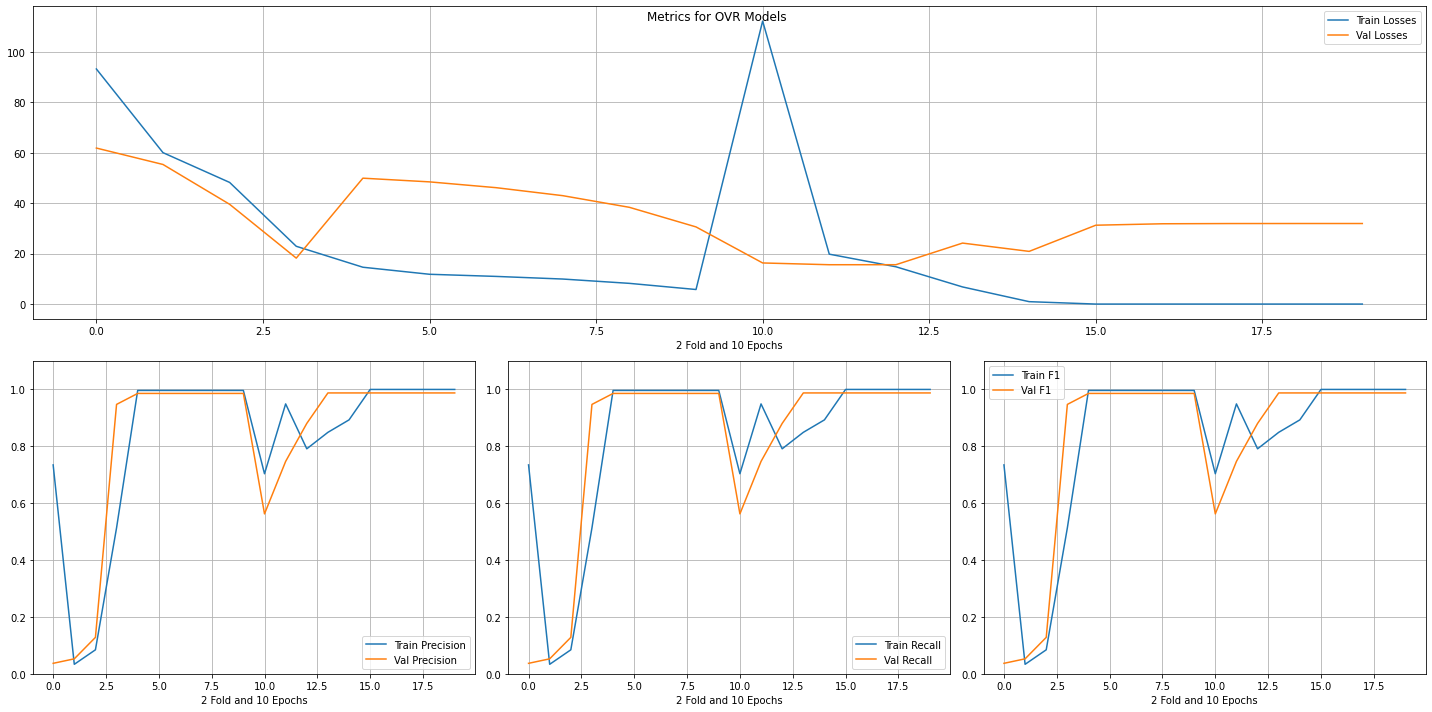

   train_f1  validation_f1  ...  train_losses  validation_losses
9  1.000000       0.987698  ...      0.000000          31.933170
6  1.000000       0.987698  ...      0.000000          31.830065
8  1.000000       0.987698  ...      0.000000          31.931002
7  1.000000       0.987698  ...      0.000000          31.917192
3  0.849123       0.987698  ...      6.791753          24.173694
4  0.892982       0.987698  ...      0.951395          20.884381
5  1.000000       0.987698  ...      0.000000          31.259550
4  0.996485       0.985965  ...     14.602152          49.904497
5  0.996485       0.985965  ...     11.807999          48.439400
6  0.996485       0.985965  ...     10.961843          46.138243
7  0.996485       0.985965  ...      9.920044          42.970117
8  0.996485       0.985965  ...      8.208684          38.350845
9  0.996485       0.985965  ...      5.770138          30.582403
3  0.513181       0.947368  ...     22.905973          18.212376
2  0.791228       0.88049

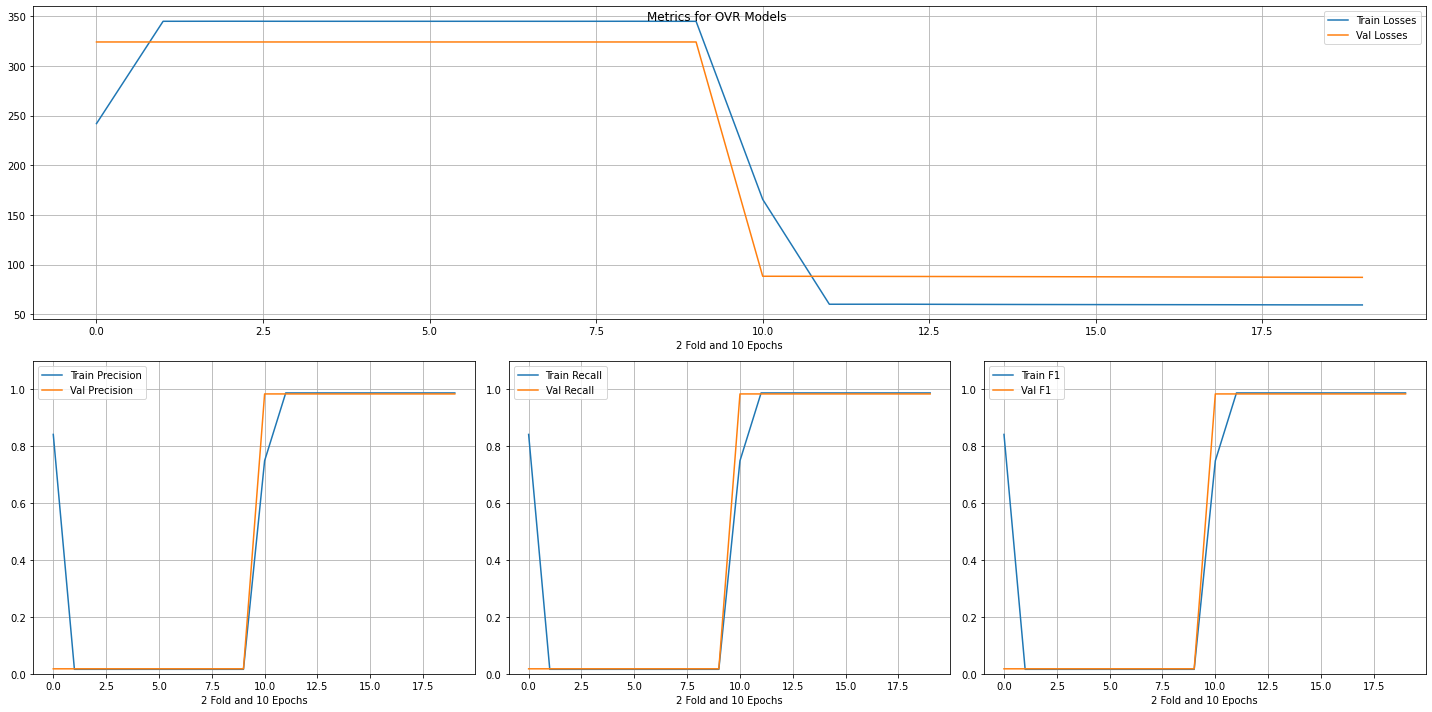

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.749123       0.984183  ...    165.653447          88.246463
1  0.987719       0.984183  ...     60.066836          88.167123
8  0.987719       0.984183  ...     59.436417          87.293577
7  0.987719       0.984183  ...     59.565579          87.433405
6  0.987719       0.984183  ...     59.643577          87.569256
5  0.987719       0.984183  ...     59.707818          87.700834
4  0.987719       0.984183  ...     59.801495          87.827693
3  0.987719       0.984183  ...     59.941207          87.949000
2  0.987719       0.984183  ...     60.093572          88.063360
9  0.987719       0.984183  ...     59.360677          87.149975
1  0.015817       0.017544  ...    345.008090         324.179734
9  0.015817       0.017544  ...    344.977248         324.179734
8  0.015817       0.017544  ...    345.029151         324.179734
7  0.015817       0.017544  ...    344.990117         324.179734
6  0.015817       0.01754

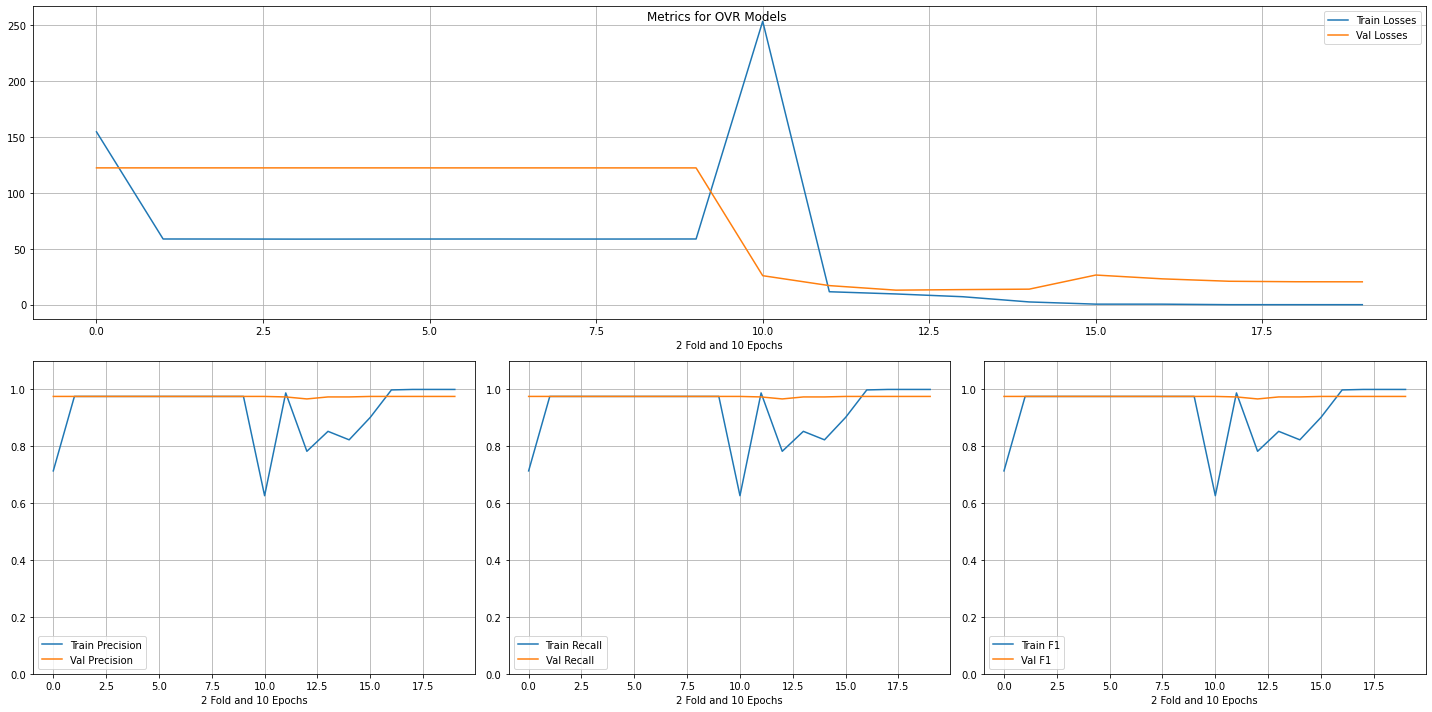

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.713533       0.975439  ...  1.547308e+02         122.460684
2  0.975395       0.975439  ...  5.876109e+01         122.456031
3  0.975395       0.975439  ...  5.868401e+01         122.453078
4  0.975395       0.975439  ...  5.873535e+01         122.449996
5  0.975395       0.975439  ...  5.876273e+01         122.446816
6  0.975395       0.975439  ...  5.879167e+01         122.443572
7  0.975395       0.975439  ...  5.873223e+01         122.440260
8  0.975395       0.975439  ...  5.875890e+01         122.436915
9  0.975395       0.975439  ...  5.880381e+01         122.433549
1  0.975395       0.975439  ...  5.879683e+01         122.458727
5  0.901754       0.975395  ...  4.754134e-01          26.528913
8  1.000000       0.975395  ...  9.611836e-09          20.527581
7  1.000000       0.975395  ...  3.203121e-03          20.962183
6  0.998246       0.975395  ...  4.554082e-01          23.117707
0  0.626316       0.97539

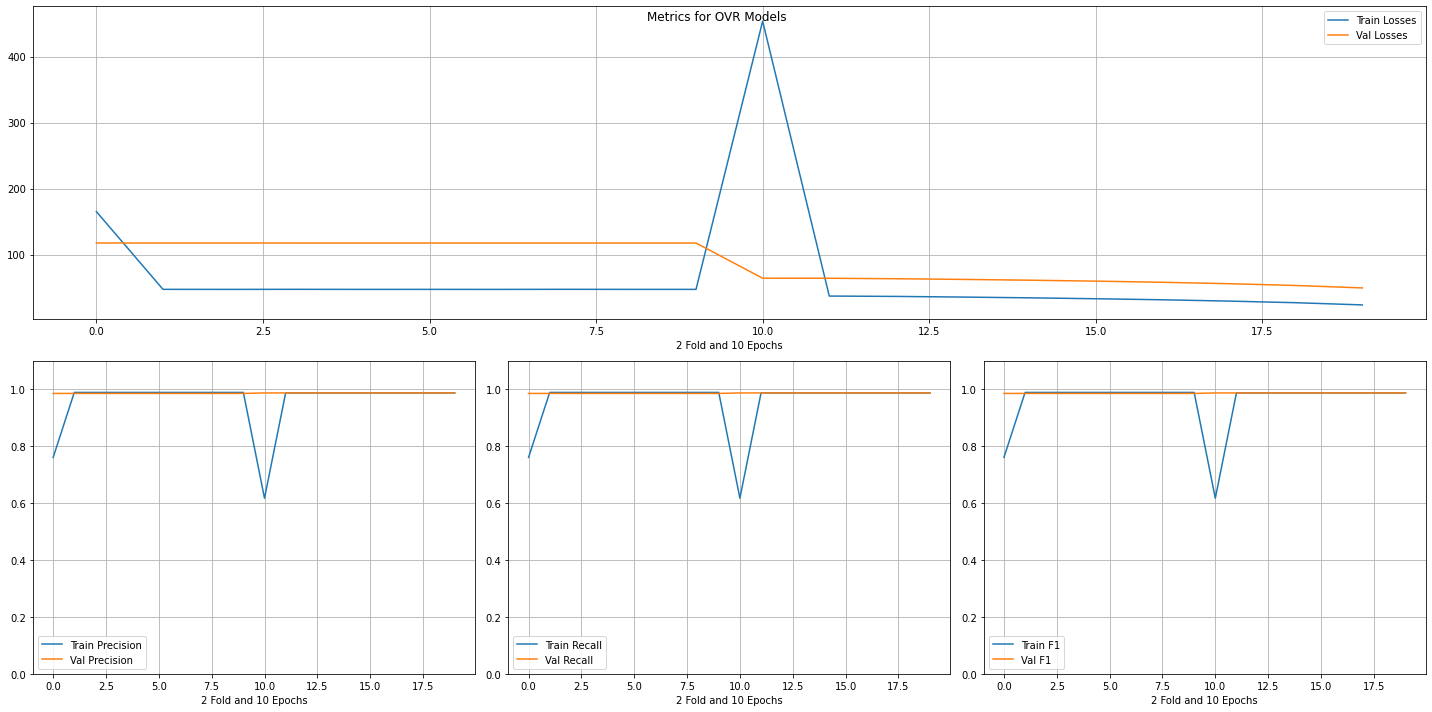

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.617544       0.987698  ...    453.614698          64.103826
1  0.987719       0.987698  ...     37.053446          64.060145
8  0.987719       0.987698  ...     26.992494          53.086439
7  0.987719       0.987698  ...     29.432599          55.806773
6  0.987719       0.987698  ...     31.431479          57.936625
5  0.987719       0.987698  ...     32.993790          59.666226
4  0.987719       0.987698  ...     34.388215          61.103720
3  0.987719       0.987698  ...     35.537733          62.311319
2  0.987719       0.987698  ...     36.526303          63.314726
9  0.987719       0.987698  ...     23.650559          49.404895
1  0.989455       0.985965  ...     47.235718         117.442427
9  0.989455       0.985965  ...     47.195528         117.415731
8  0.989455       0.985965  ...     47.205664         117.419356
7  0.989455       0.985965  ...     47.288288         117.422947
6  0.989455       0.98596

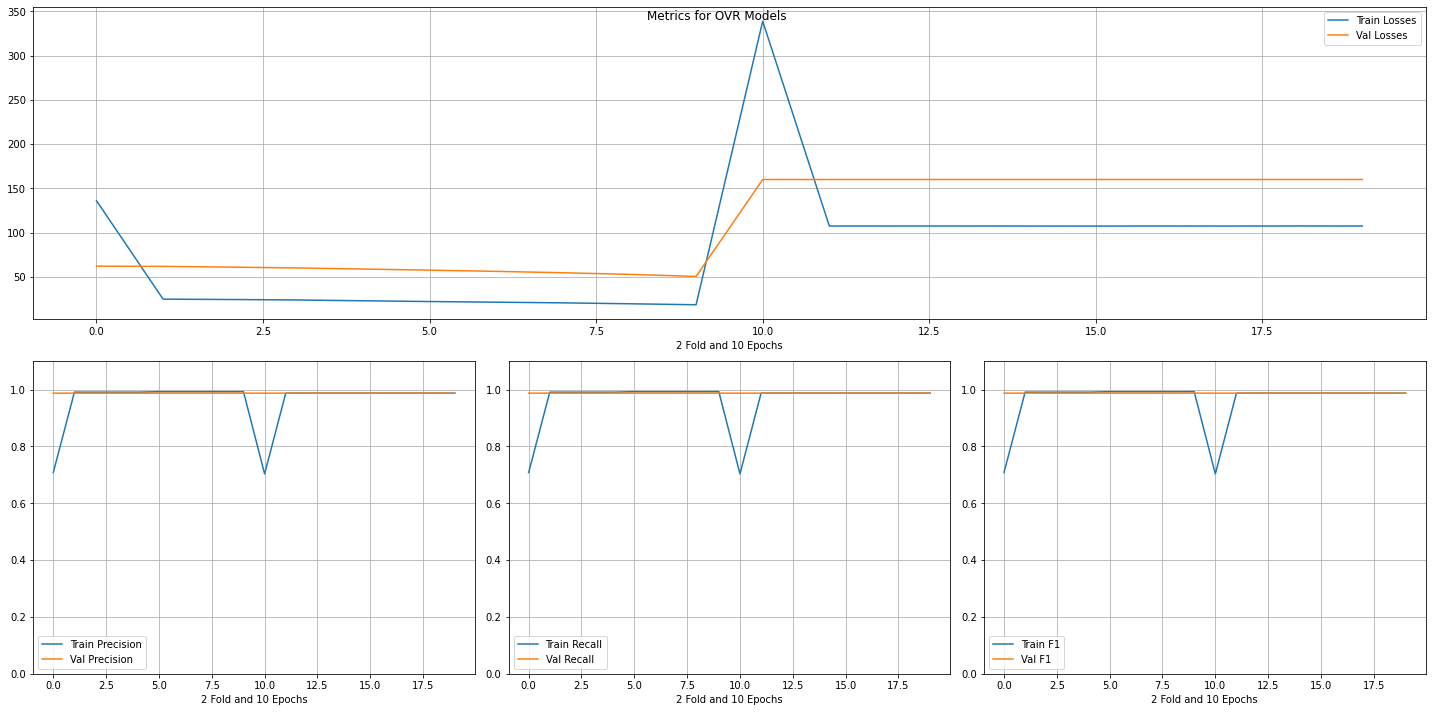

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.708260       0.987719  ...    136.078360          62.152016
2  0.991213       0.987719  ...     24.534578          61.141417
3  0.991213       0.987719  ...     23.992931          60.138115
4  0.991213       0.987719  ...     23.092497          58.952068
5  0.992970       0.987719  ...     22.230525          57.666432
6  0.992970       0.987719  ...     21.502950          56.302777
7  0.992970       0.987719  ...     20.735204          54.754829
8  0.992970       0.987719  ...     19.715906          52.902950
9  0.992970       0.987719  ...     18.602106          50.610197
1  0.991213       0.987719  ...     24.908275          61.923790
5  0.987719       0.987698  ...    107.461143         160.057310
8  0.987719       0.987698  ...    107.596476         160.057246
7  0.987719       0.987698  ...    107.483616         160.057263
6  0.987719       0.987698  ...    107.537560         160.057290
0  0.703509       0.98769

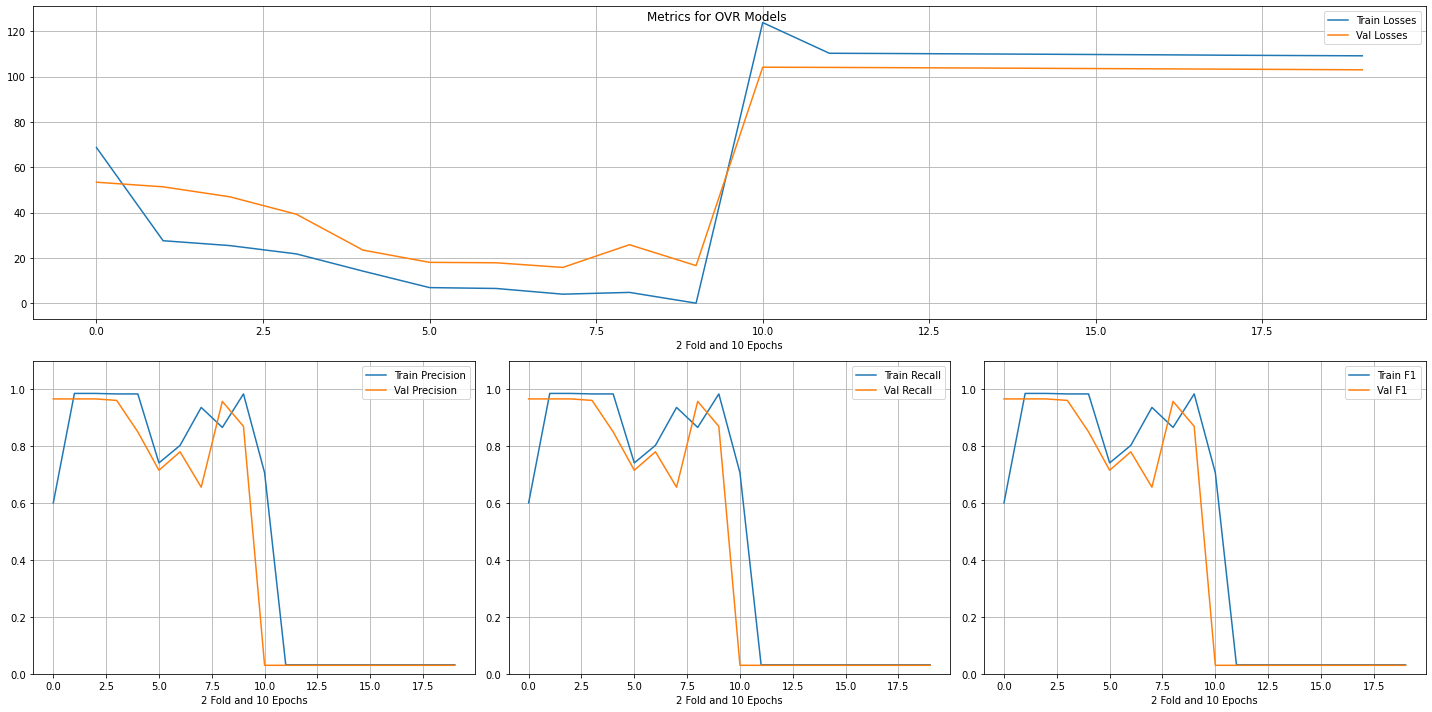

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.601054       0.966667  ...     68.720263          53.433917
2  0.985940       0.966667  ...     25.479606          47.003312
1  0.985940       0.966667  ...     27.622833          51.402484
3  0.984183       0.961404  ...     21.808250          39.310045
8  0.866432       0.957895  ...      4.822101          25.862368
9  0.984183       0.870175  ...      0.076661          16.640255
4  0.984183       0.850877  ...     14.215319          23.481746
6  0.803163       0.780702  ...      6.558515          17.892568
5  0.741652       0.715789  ...      6.935251          18.081215
7  0.936731       0.656140  ...      4.038202          15.836224
5  0.031579       0.029877  ...    109.775713         103.576558
8  0.031579       0.029877  ...    109.323917         103.167878
7  0.031579       0.029877  ...    109.457665         103.306107
6  0.031579       0.029877  ...    109.635558         103.442314
0  0.707018       0.02987

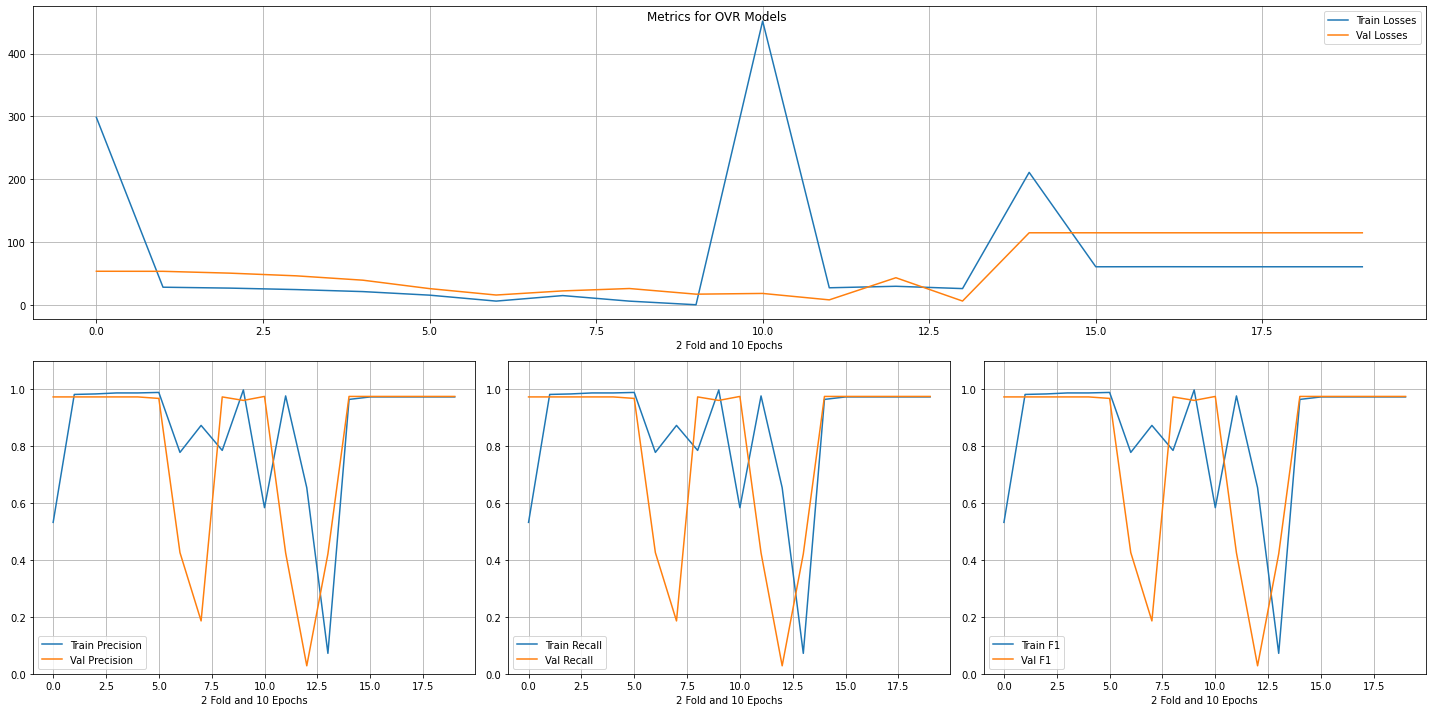

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.584211       0.975395  ...    451.646239          18.017021
4  0.964912       0.975395  ...    210.752963         114.575663
8  0.973684       0.975395  ...     60.474236         114.550897
7  0.973684       0.975395  ...     60.472971         114.557678
6  0.973684       0.975395  ...     60.548970         114.564232
5  0.973684       0.975395  ...     60.468958         114.570396
9  0.973684       0.975395  ...     60.445990         114.543922
8  0.785589       0.973684  ...      5.759701          25.847570
1  0.982425       0.973684  ...     27.934255          53.220633
4  0.987698       0.973684  ...     20.950427          39.111197
3  0.987698       0.973684  ...     24.159706          46.045322
2  0.984183       0.973684  ...     26.495962          50.330630
0  0.532513       0.973684  ...    298.292390          53.328127
5  0.989455       0.968421  ...     15.279765          25.694218
9  0.998243       0.96140

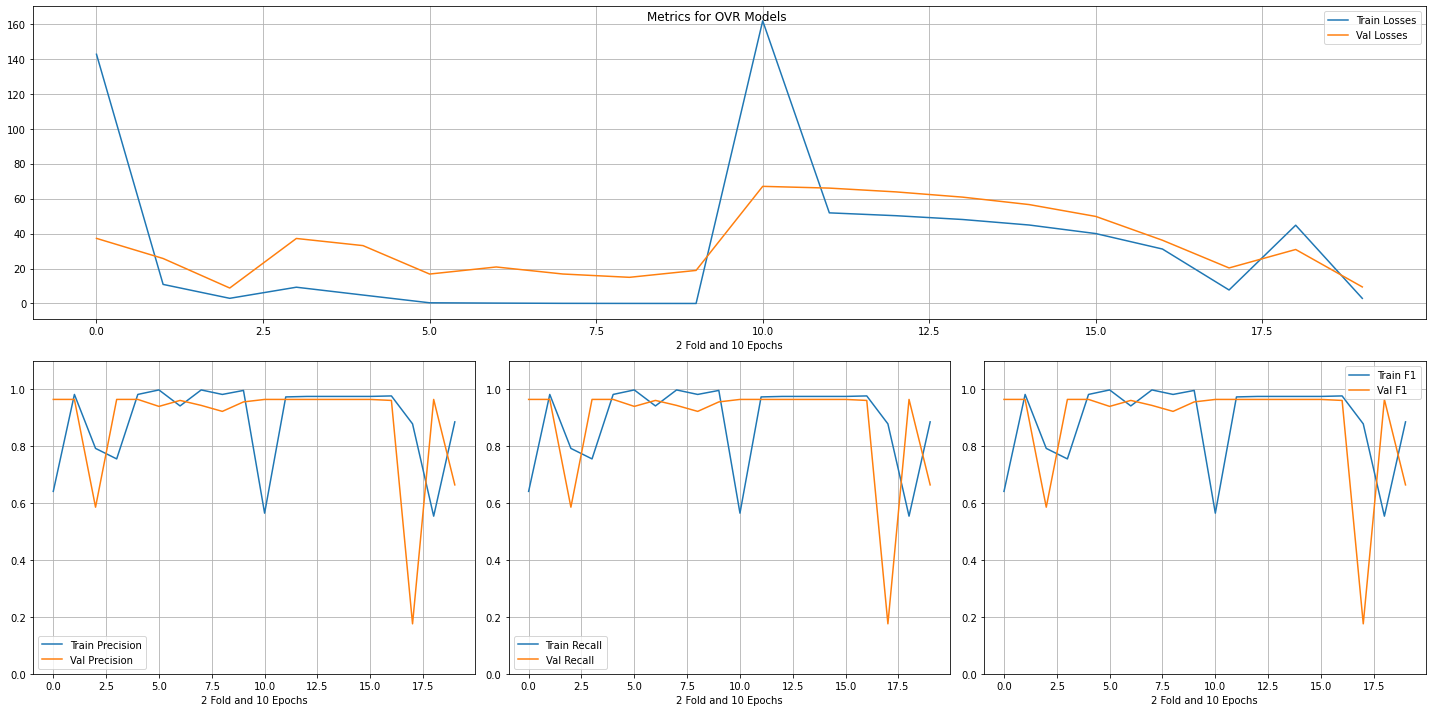

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.641476       0.964912  ...    142.601698          37.251829
1  0.982425       0.964912  ...     10.909304          25.737844
3  0.755712       0.964912  ...      9.302589          37.199519
4  0.982425       0.964912  ...      4.827387          33.113249
8  0.554386       0.964851  ...     44.786032          30.890452
5  0.975439       0.964851  ...     39.995753          49.801551
4  0.975439       0.964851  ...     44.892066          56.593440
3  0.975439       0.964851  ...     48.054911          60.850914
2  0.975439       0.964851  ...     50.228409          63.851741
1  0.973684       0.964851  ...     51.858323          66.018835
0  0.564912       0.964851  ...    161.745939          67.020090
6  0.942004       0.961404  ...      0.214507          20.881912
6  0.977193       0.961336  ...     31.157454          36.182403
9  0.996485       0.956140  ...      0.003974          18.918265
7  0.998243       0.94386

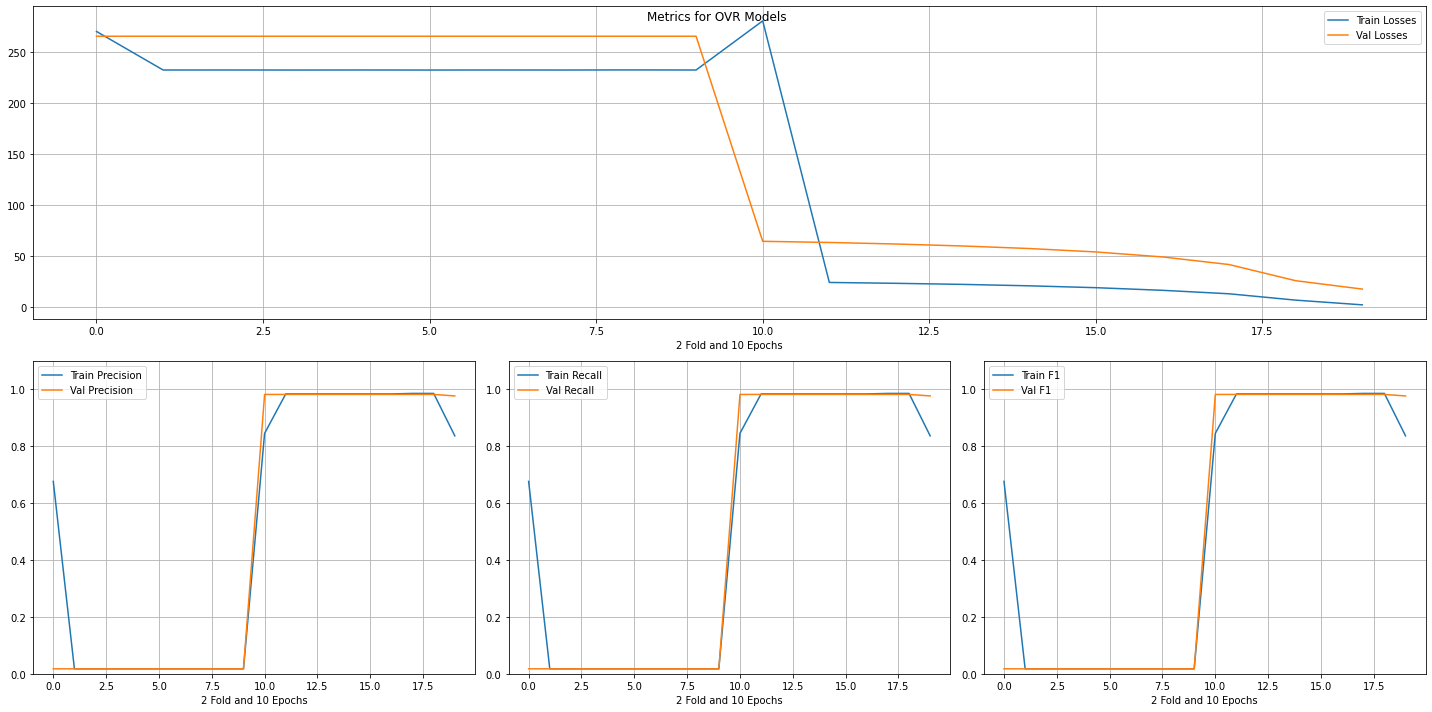

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.845614       0.982425  ...    280.787584          64.450780
1  0.984211       0.982425  ...     24.074645          63.315300
8  0.985965       0.982425  ...      6.710958          25.775121
7  0.985965       0.982425  ...     12.946007          41.636547
6  0.984211       0.982425  ...     16.352787          49.118397
5  0.984211       0.982425  ...     18.935951          54.009719
4  0.984211       0.982425  ...     20.763619          57.363430
3  0.984211       0.982425  ...     22.170017          59.856698
2  0.984211       0.982425  ...     23.208985          61.793243
9  0.836842       0.977153  ...      2.090056          17.556269
1  0.017575       0.017544  ...    232.579664         265.713212
9  0.017575       0.017544  ...    232.574537         265.713212
8  0.017575       0.017544  ...    232.659813         265.713212
7  0.017575       0.017544  ...    232.554640         265.713212
6  0.017575       0.01754

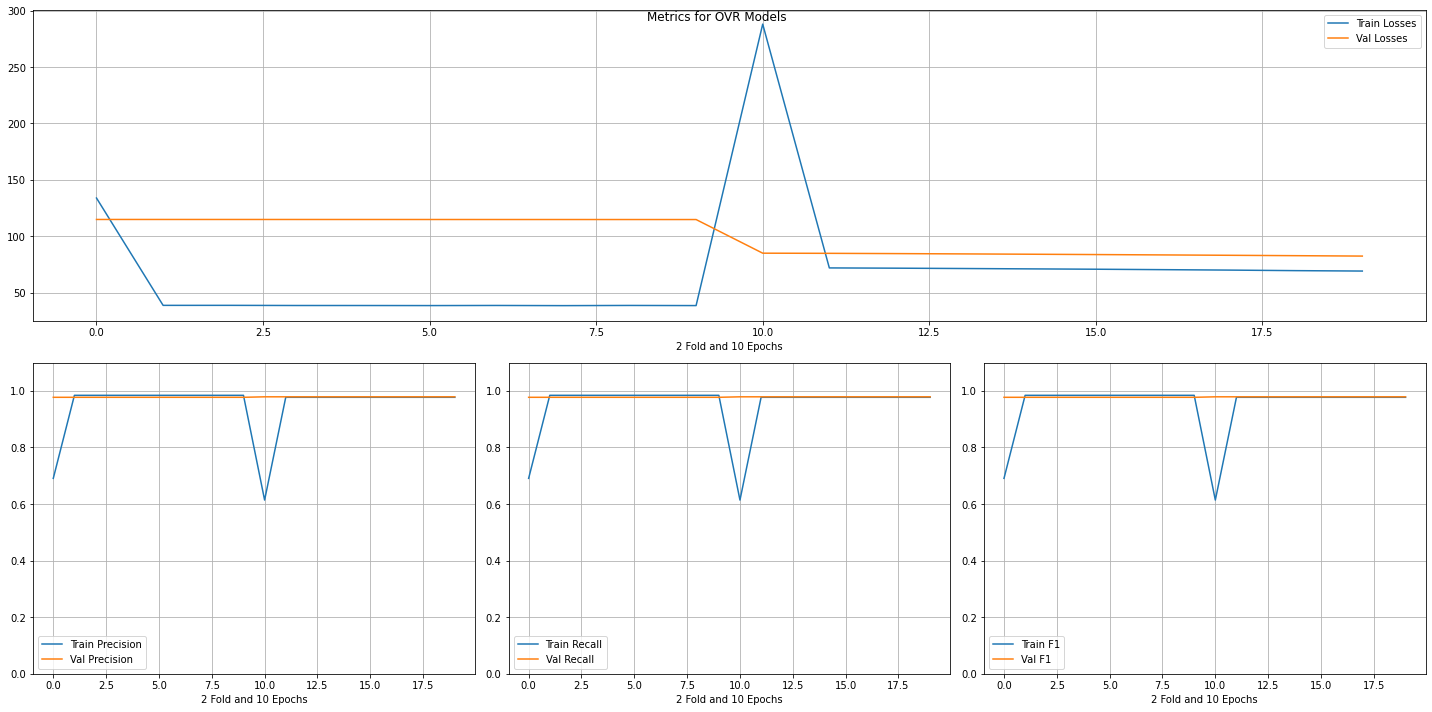

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.614035       0.978910  ...    288.031253          84.918060
1  0.977193       0.978910  ...     71.851339          84.785539
8  0.977193       0.978910  ...     69.441828          82.706100
7  0.977193       0.978910  ...     69.920770          83.049739
6  0.977193       0.978910  ...     70.314211          83.378877
5  0.977193       0.978910  ...     70.692438          83.693793
4  0.977193       0.978910  ...     71.002078          83.994552
3  0.977193       0.978910  ...     71.323460          84.280443
2  0.977193       0.978910  ...     71.620423          84.548496
9  0.977193       0.978910  ...     69.070908          82.347338
1  0.984183       0.977193  ...     38.646711         114.815396
9  0.984183       0.977193  ...     38.452082         114.746357
8  0.984183       0.977193  ...     38.573222         114.755427
7  0.984183       0.977193  ...     38.405940         114.764435
6  0.984183       0.97719

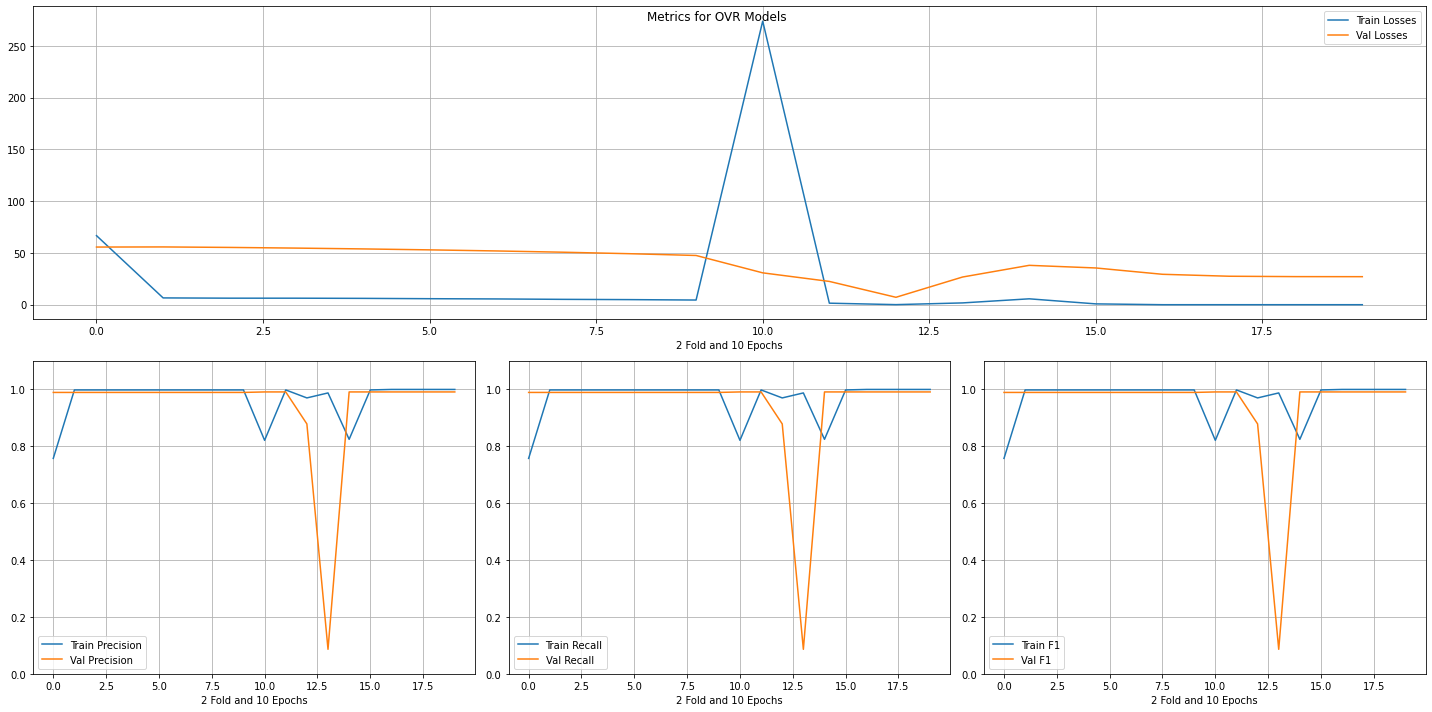

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.821053       0.991213  ...    273.766092          30.754013
1  0.998246       0.991213  ...      1.466935          22.472672
8  1.000000       0.991213  ...      0.000000          27.109468
7  1.000000       0.991213  ...      0.000000          27.478361
6  1.000000       0.991213  ...      0.000000          29.361212
5  0.998246       0.991213  ...      0.787721          35.465816
4  0.824561       0.991213  ...      5.676109          38.005572
9  1.000000       0.991213  ...      0.000000          27.048315
8  0.998243       0.989474  ...      4.911047          49.241066
9  0.998243       0.989474  ...      4.502150          47.525616
1  0.998243       0.989474  ...      6.554260          55.769860
7  0.998243       0.989474  ...      5.161865          50.676105
6  0.998243       0.989474  ...      5.560358          51.897316
5  0.998243       0.989474  ...      5.793093          52.947860
4  0.998243       0.98947

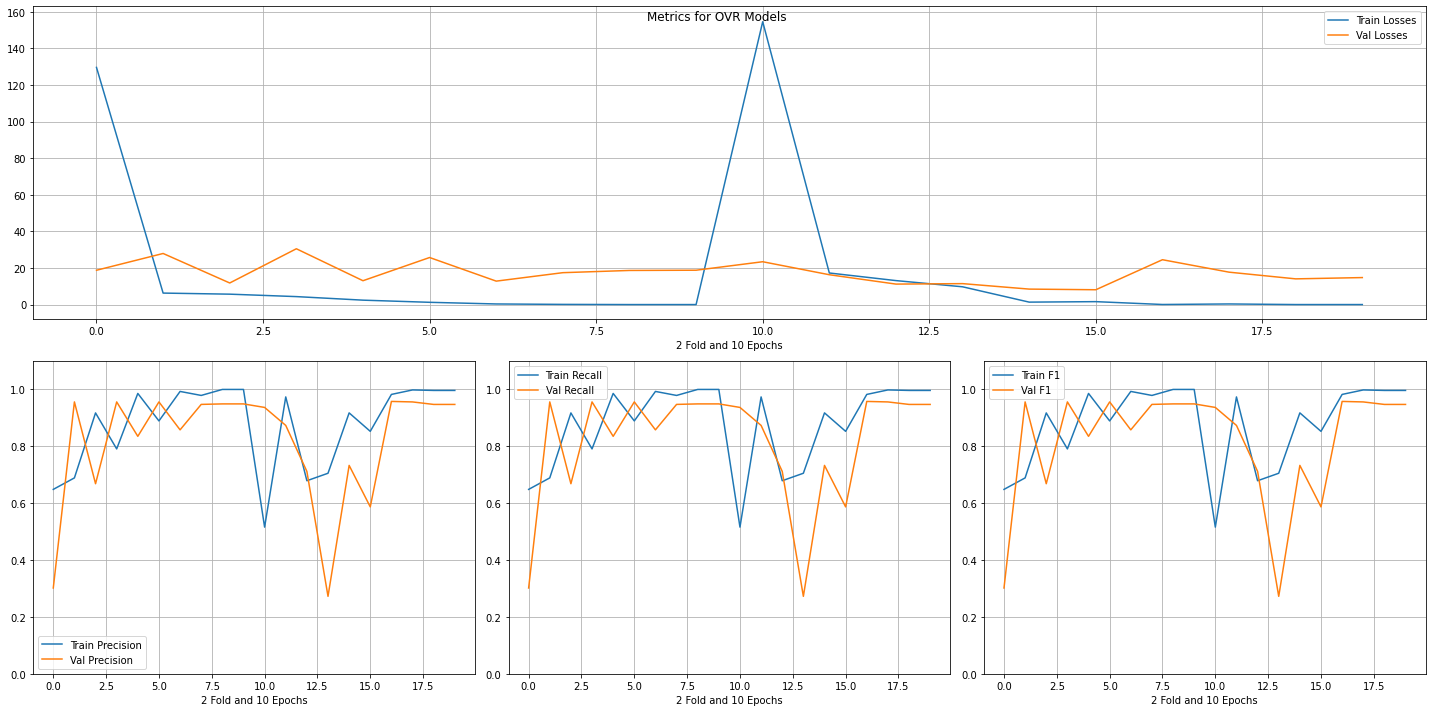

   train_f1  validation_f1  ...  train_losses  validation_losses
6  0.982456       0.957821  ...      0.043089          24.517223
1  0.688928       0.956140  ...      6.276257          27.930678
3  0.790861       0.956140  ...      4.351707          30.506296
5  0.889279       0.956140  ...      1.236227          25.721011
7  0.998246       0.956063  ...      0.333450          17.711502
8  1.000000       0.949123  ...      0.000038          18.650181
9  1.000000       0.949123  ...      0.000067          18.781368
7  0.978910       0.947368  ...      0.095231          17.433870
9  0.996491       0.947276  ...      0.008406          14.755885
8  0.996491       0.947276  ...      0.007299          14.051667
0  0.515789       0.936731  ...    154.625282          23.416522
1  0.973684       0.873462  ...     17.260529          16.306153
6  0.992970       0.857895  ...      0.328242          12.811458
4  0.985940       0.835088  ...      2.409821          13.037409
4  0.917544       0.73286

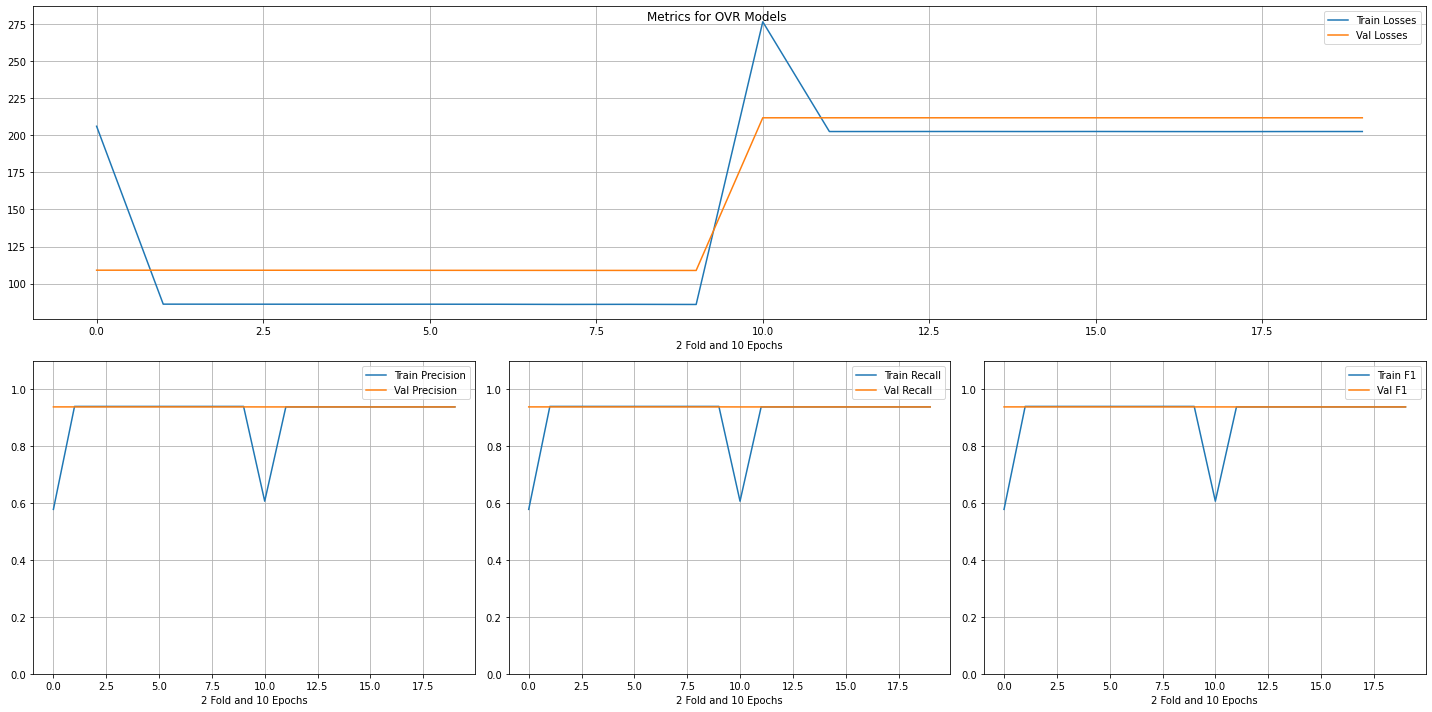

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.578207       0.938596  ...    206.136883         109.064368
2  0.940246       0.938596  ...     86.124145         109.033128
3  0.940246       0.938596  ...     86.109660         109.013080
4  0.940246       0.938596  ...     86.085548         108.992219
5  0.940246       0.938596  ...     86.114564         108.970839
6  0.940246       0.938596  ...     86.087559         108.949033
7  0.940246       0.938596  ...     85.983282         108.926901
8  0.940246       0.938596  ...     86.035115         108.904485
9  0.940246       0.938596  ...     85.942405         108.881831
1  0.940246       0.938596  ...     86.152810         109.051547
5  0.938596       0.938489  ...    202.620756         211.858320
8  0.938596       0.938489  ...    202.592947         211.858320
7  0.938596       0.938489  ...    202.541028         211.858320
6  0.938596       0.938489  ...    202.568353         211.858320
0  0.607018       0.93848

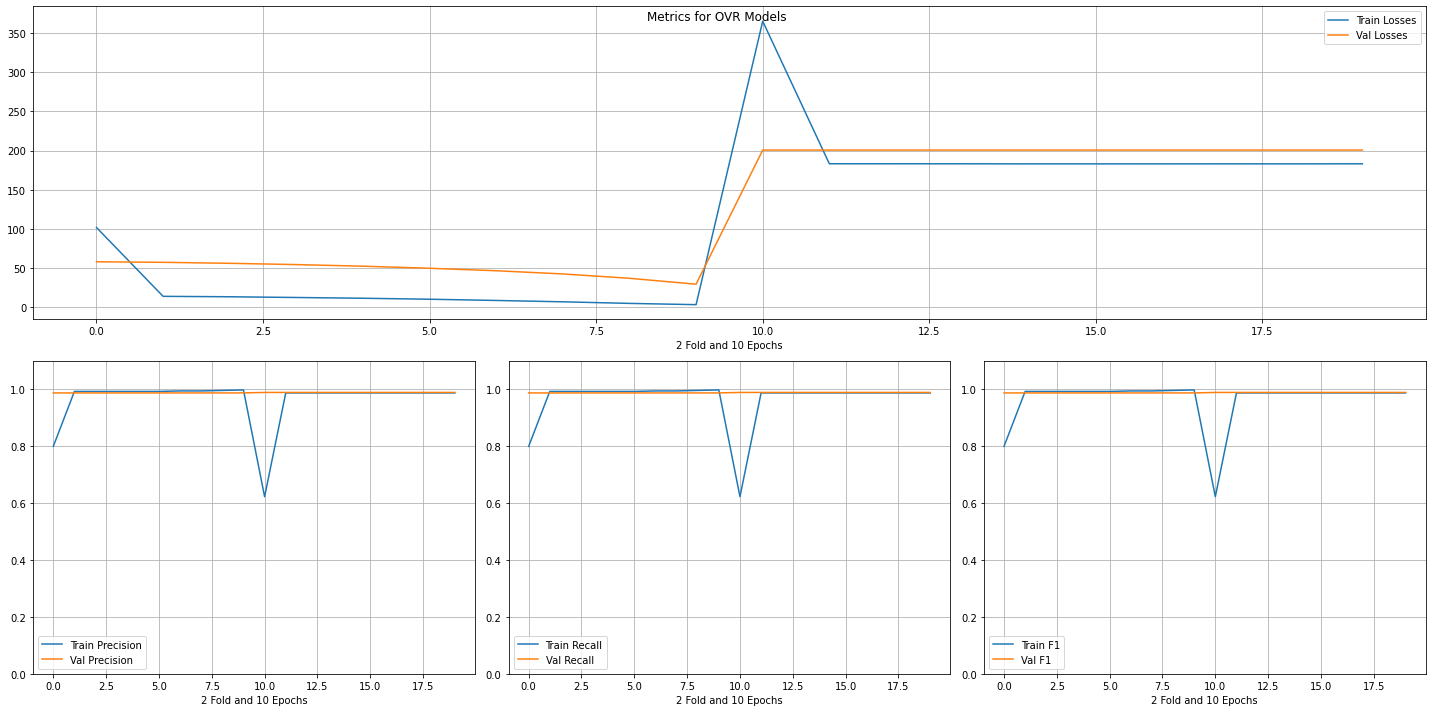

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.622807       0.989455  ...    365.140601         200.742167
1  0.987719       0.989455  ...    183.298221         200.742167
8  0.987719       0.989455  ...    183.143397         200.742167
7  0.987719       0.989455  ...    183.183092         200.742167
6  0.987719       0.989455  ...    183.120129         200.742167
5  0.987719       0.989455  ...    183.129849         200.742167
4  0.987719       0.989455  ...    183.141693         200.742167
3  0.987719       0.989455  ...    183.232693         200.742167
2  0.987719       0.989455  ...    183.243125         200.742167
9  0.987719       0.989455  ...    183.232856         200.742167
1  0.992970       0.987719  ...     14.154542          57.547656
9  0.998243       0.987719  ...      3.544277          29.657906
8  0.996485       0.987719  ...      5.164840          37.187153
7  0.994728       0.987719  ...      7.178604          42.735592
6  0.994728       0.98771

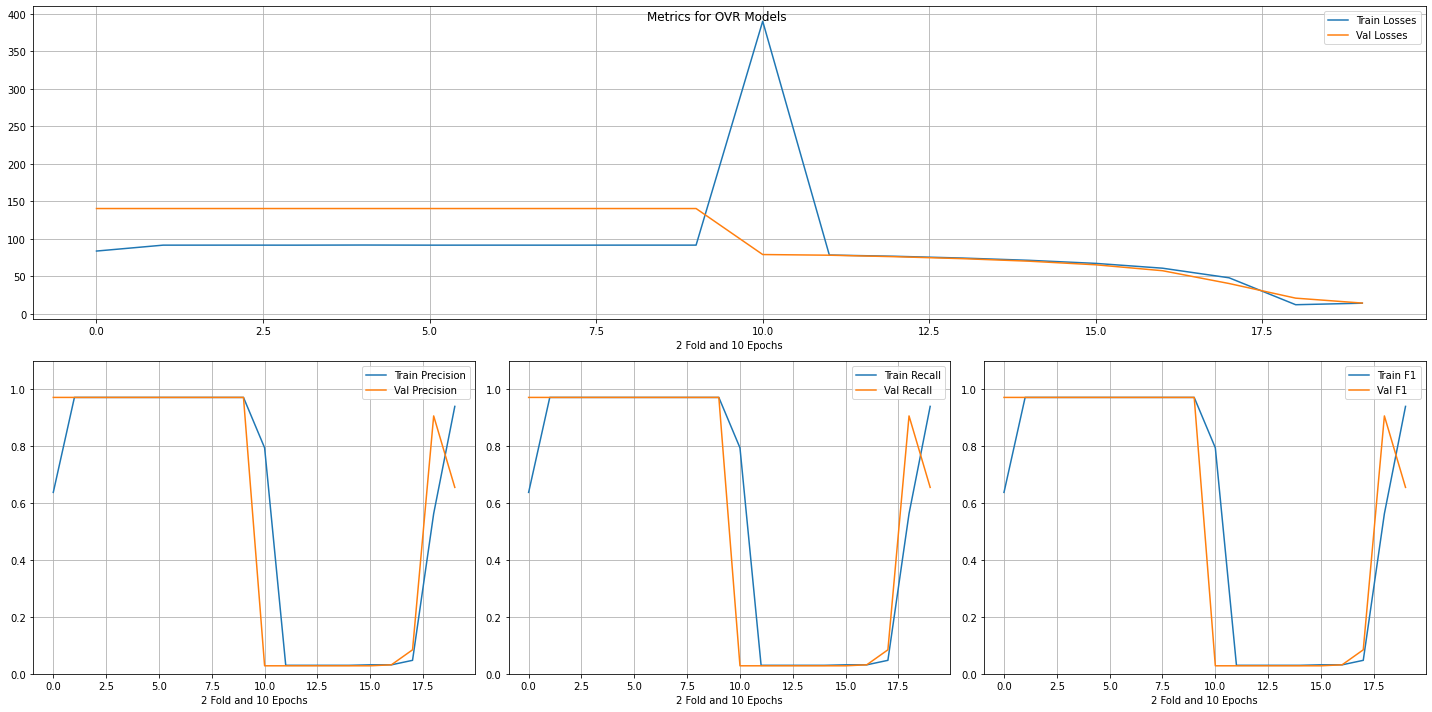

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.637961       0.971930  ...     83.844873         140.528411
2  0.971880       0.971930  ...     91.745605         140.527598
3  0.971880       0.971930  ...     91.713252         140.527060
4  0.971880       0.971930  ...     91.873563         140.526516
5  0.971880       0.971930  ...     91.714125         140.525961
6  0.971880       0.971930  ...     91.729678         140.525399
7  0.971880       0.971930  ...     91.702199         140.524831
8  0.971880       0.971930  ...     91.756364         140.524246
9  0.971880       0.971930  ...     91.747065         140.523679
1  0.971880       0.971930  ...     91.719412         140.528093
8  0.563158       0.906854  ...     12.301631          21.054874
9  0.940351       0.655536  ...     14.346647          14.504163
7  0.047368       0.084359  ...     48.215999          40.569867
6  0.031579       0.031634  ...     61.008306          57.648261
2  0.029825       0.02812

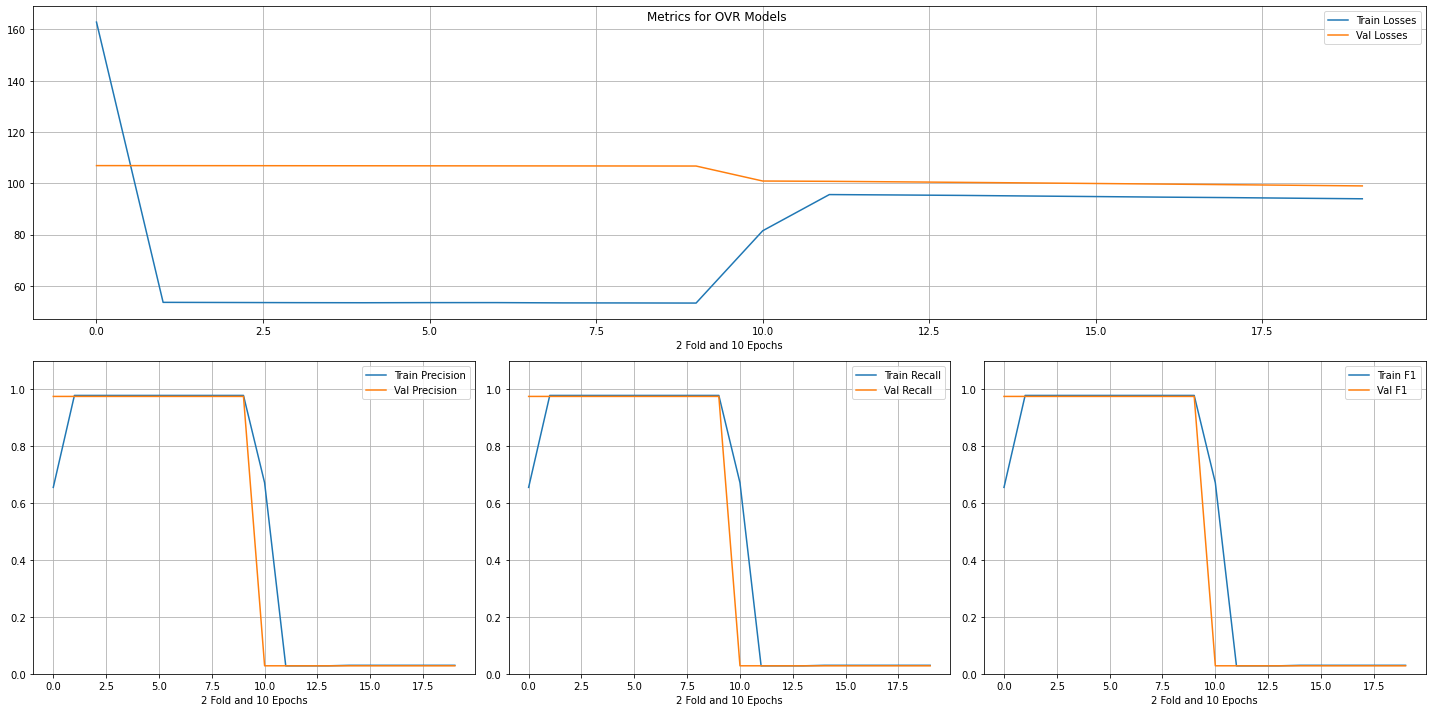

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.655536       0.975439  ...    162.875074         106.905473
2  0.978910       0.975439  ...     53.515396         106.879134
3  0.978910       0.975439  ...     53.454566         106.860556
4  0.978910       0.975439  ...     53.420748         106.841159
5  0.978910       0.975439  ...     53.468457         106.821213
6  0.978910       0.975439  ...     53.473025         106.800876
7  0.978910       0.975439  ...     53.360731         106.780213
8  0.978910       0.975439  ...     53.339479         106.759277
9  0.978910       0.975439  ...     53.293992         106.738111
1  0.978910       0.975439  ...     53.569950         106.895850
5  0.029825       0.028120  ...     94.829664          99.928131
8  0.029825       0.028120  ...     94.185425          99.230772
7  0.029825       0.028120  ...     94.424942          99.468852
6  0.029825       0.028120  ...     94.606259          99.701221
0  0.671930       0.02812

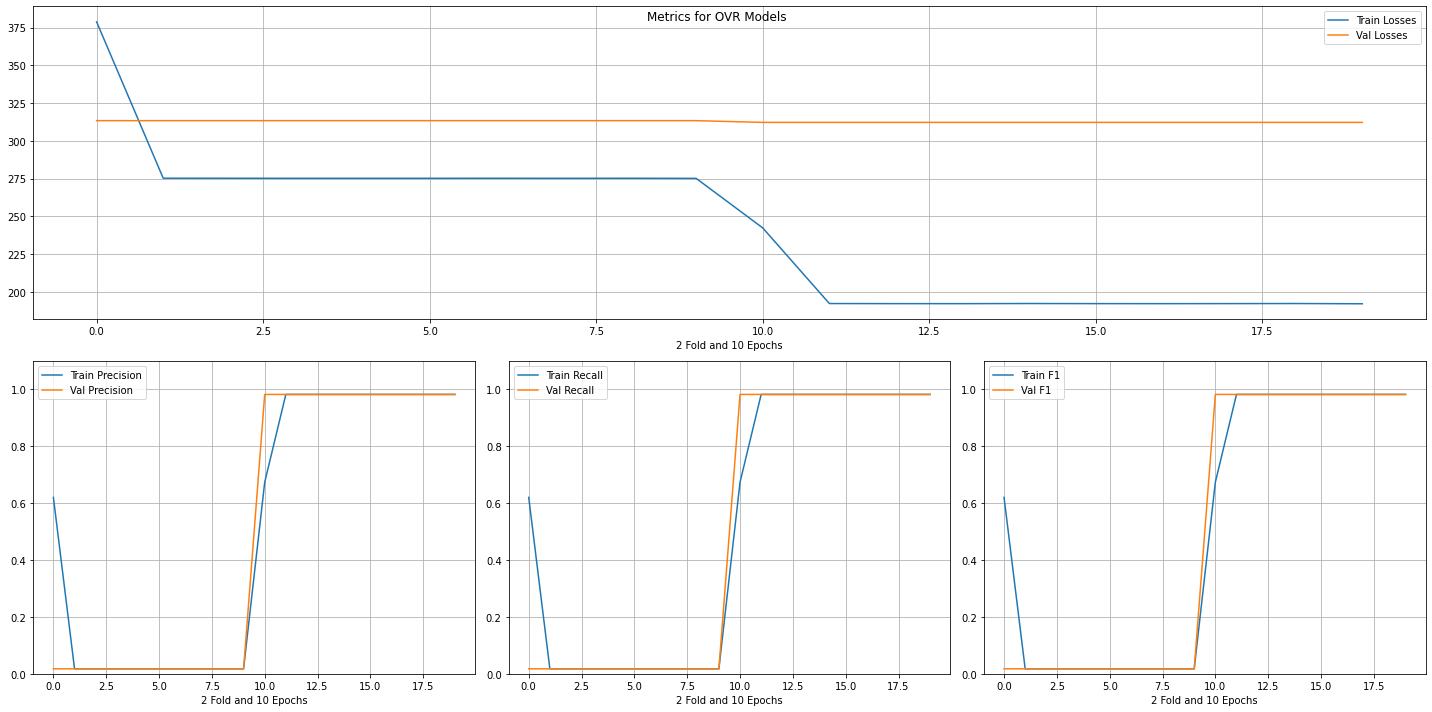

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.673684       0.982425  ...    242.387874         312.250554
1  0.982456       0.982425  ...    192.359270         312.250554
8  0.982456       0.982425  ...    192.369171         312.250554
7  0.982456       0.982425  ...    192.311910         312.250554
6  0.982456       0.982425  ...    192.283208         312.250554
5  0.982456       0.982425  ...    192.305035         312.250554
4  0.982456       0.982425  ...    192.375866         312.250554
3  0.982456       0.982425  ...    192.281640         312.250554
2  0.982456       0.982425  ...    192.295698         312.250554
9  0.982456       0.982425  ...    192.207374         312.250554
1  0.017575       0.017544  ...    275.290654         313.377644
9  0.017575       0.017544  ...    275.203572         313.377644
8  0.017575       0.017544  ...    275.278341         313.377644
7  0.017575       0.017544  ...    275.245353         313.377644
6  0.017575       0.01754

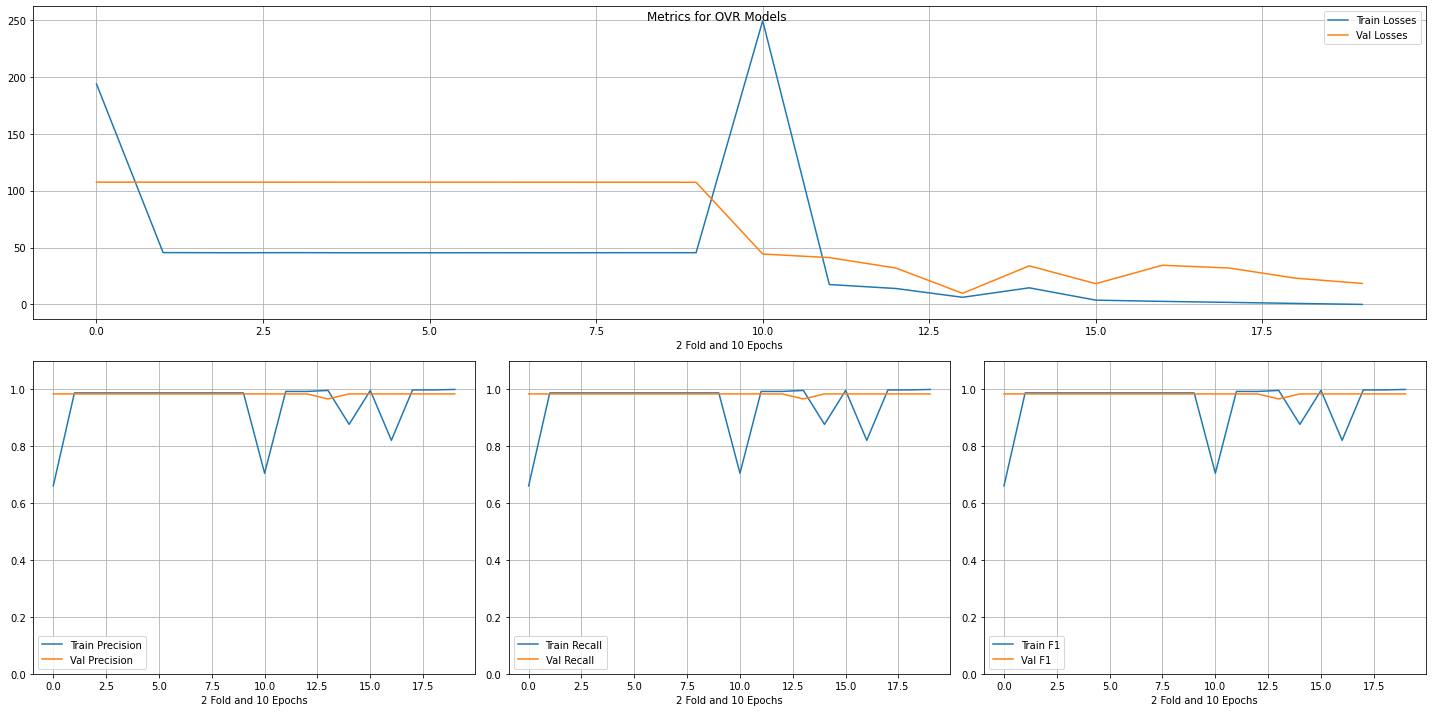

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.660808       0.984211  ...    193.823805         107.487966
2  0.987698       0.984211  ...     45.429048         107.475599
3  0.987698       0.984211  ...     45.507169         107.465134
4  0.987698       0.984211  ...     45.388008         107.454007
5  0.987698       0.984211  ...     45.401889         107.442451
6  0.987698       0.984211  ...     45.457340         107.430569
7  0.987698       0.984211  ...     45.413022         107.418417
8  0.987698       0.984211  ...     45.480608         107.406041
9  0.987698       0.984211  ...     45.472542         107.393475
1  0.987698       0.984211  ...     45.553815         107.484592
5  0.996491       0.984183  ...      3.749654          18.232610
8  0.998246       0.984183  ...      0.876384          23.046061
7  0.998246       0.984183  ...      1.784649          32.000376
6  0.821053       0.984183  ...      2.663904          34.434449
0  0.705263       0.98418

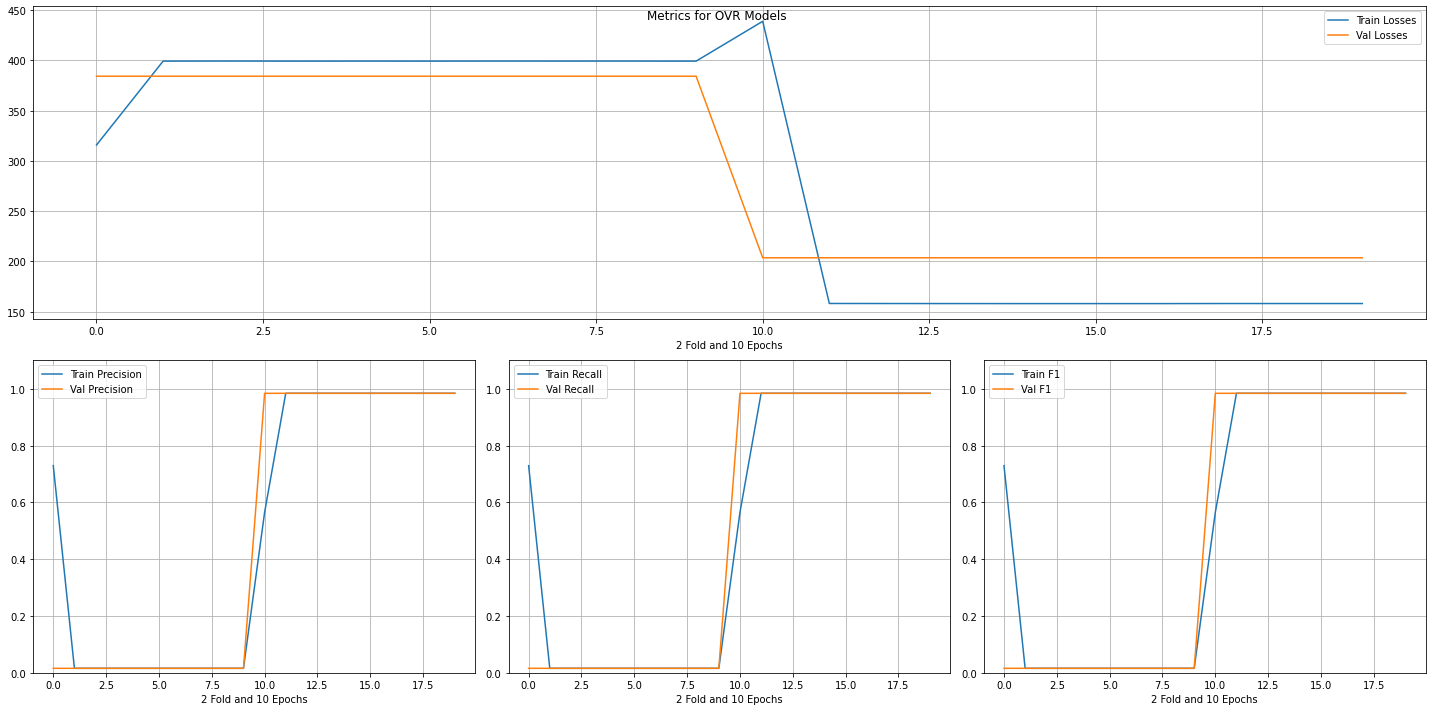

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.564912       0.984183  ...    438.998303         203.577784
1  0.984211       0.984183  ...    158.067404         203.577784
8  0.984211       0.984183  ...    158.010452         203.577784
7  0.984211       0.984183  ...    158.021990         203.577784
6  0.984211       0.984183  ...    157.944880         203.577784
5  0.984211       0.984183  ...    157.946208         203.577784
4  0.984211       0.984183  ...    157.949916         203.577784
3  0.984211       0.984183  ...    157.965769         203.577784
2  0.984211       0.984183  ...    158.016825         203.577784
9  0.984211       0.984183  ...    158.009449         203.577784
1  0.015817       0.015789  ...    399.344574         384.326887
9  0.015817       0.015789  ...    399.326579         384.326887
8  0.015817       0.015789  ...    399.378265         384.326887
7  0.015817       0.015789  ...    399.368659         384.326887
6  0.015817       0.01578

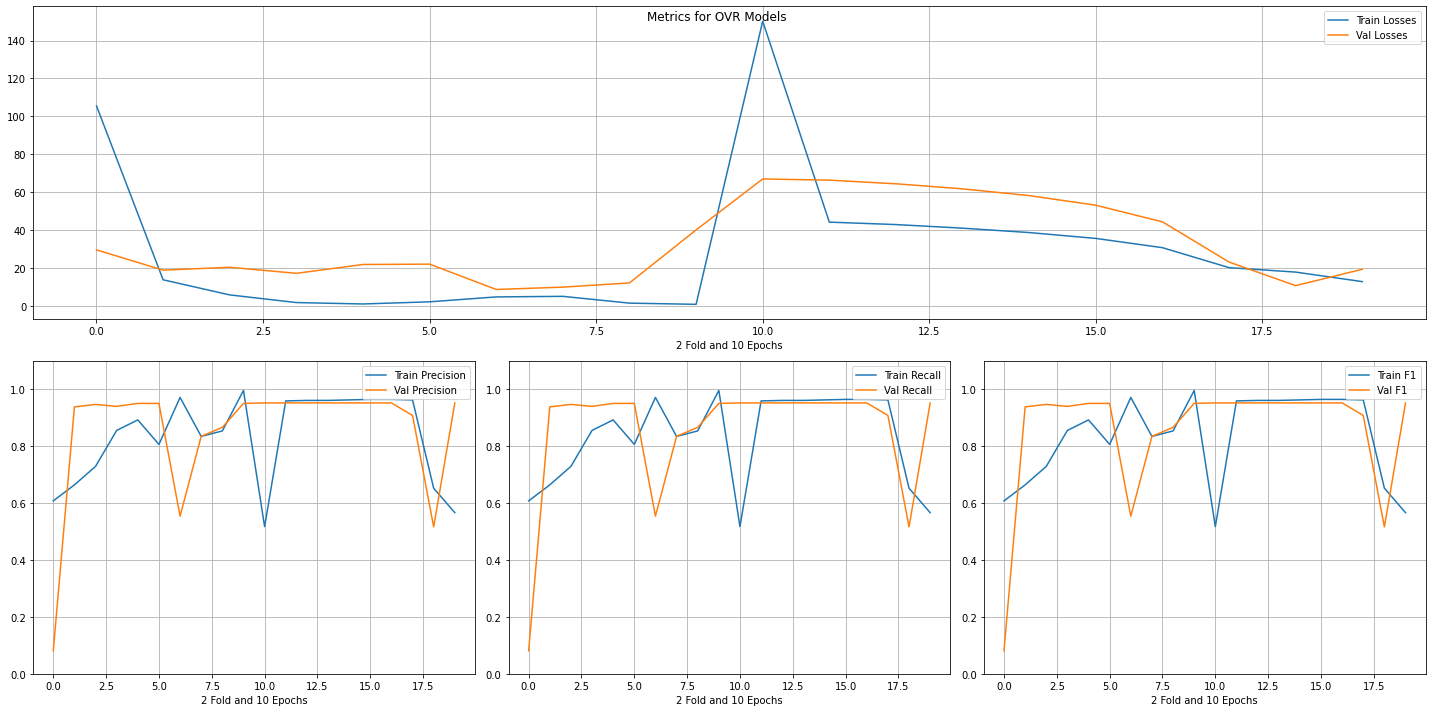

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.517544       0.952548  ...    150.186707          66.977533
1  0.959649       0.952548  ...     44.204673          66.343801
6  0.964912       0.952548  ...     30.732727          44.363854
5  0.964912       0.952548  ...     35.612327          53.123416
4  0.963158       0.952548  ...     38.704048          58.198224
3  0.961404       0.952548  ...     41.017318          61.762951
2  0.961404       0.952548  ...     42.916807          64.423738
9  0.566667       0.952548  ...     12.819893          19.324176
9  0.996485       0.950877  ...      0.840537          40.097264
5  0.806678       0.950877  ...      2.168309          22.040862
4  0.892794       0.950877  ...      1.030805          21.863775
2  0.729350       0.947368  ...      5.814419          20.383539
3  0.855888       0.940351  ...      1.775760          17.195812
1  0.664323       0.938596  ...     13.782325          18.879950
7  0.963158       0.90861

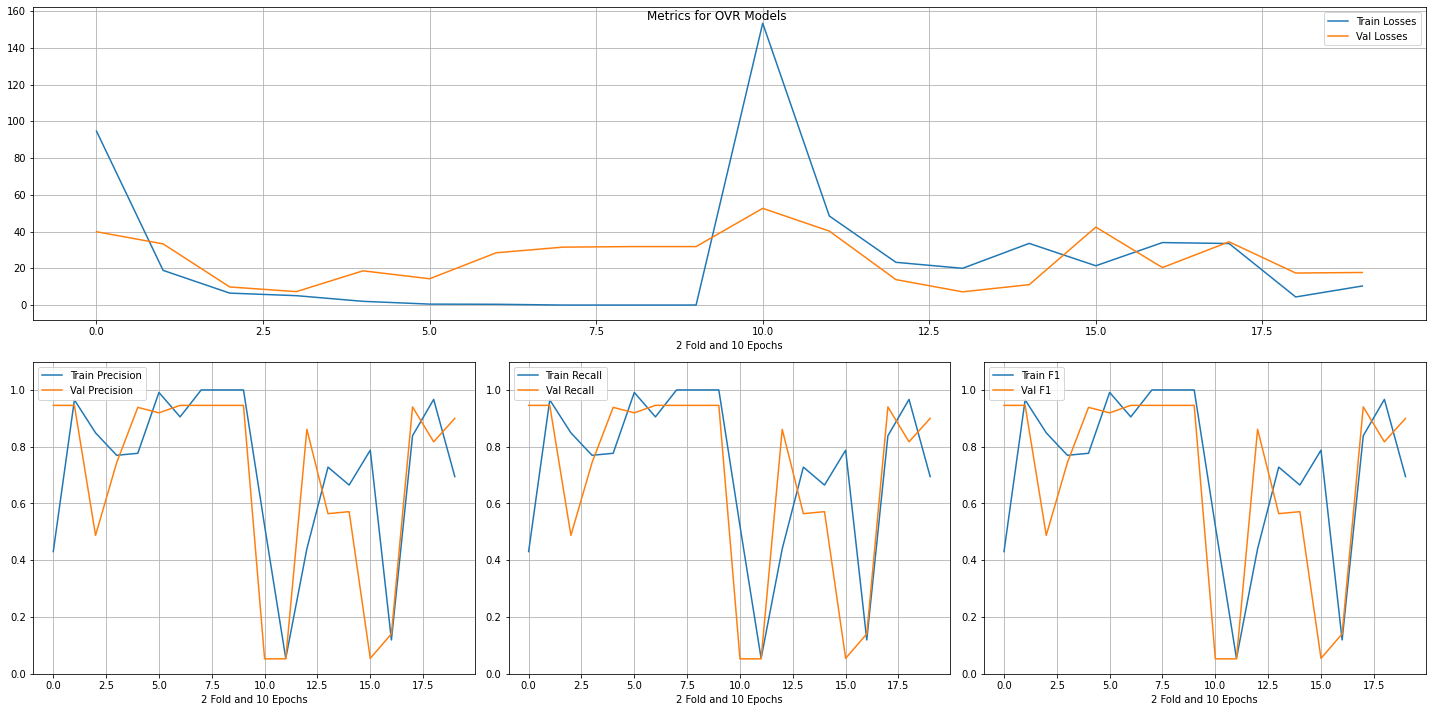

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.430580       0.945614  ...     94.686610          39.914490
9  1.000000       0.945614  ...      0.000210          31.827971
1  0.964851       0.945614  ...     18.879132          33.306468
6  0.905097       0.945614  ...      0.419329          28.459105
7  1.000000       0.945614  ...      0.000008          31.522487
8  1.000000       0.945614  ...      0.000285          31.827262
7  0.838596       0.940246  ...     33.498171          34.419633
4  0.776801       0.938596  ...      2.028167          18.637794
5  0.991213       0.919298  ...      0.510226          14.314692
9  0.694737       0.899824  ...     10.376082          17.731253
2  0.440351       0.861160  ...     23.261855          13.841779
8  0.966667       0.817223  ...      4.401546          17.434420
3  0.769772       0.743860  ...      5.107961           7.306595
4  0.664912       0.571178  ...     33.564261          11.096590
3  0.728070       0.56414

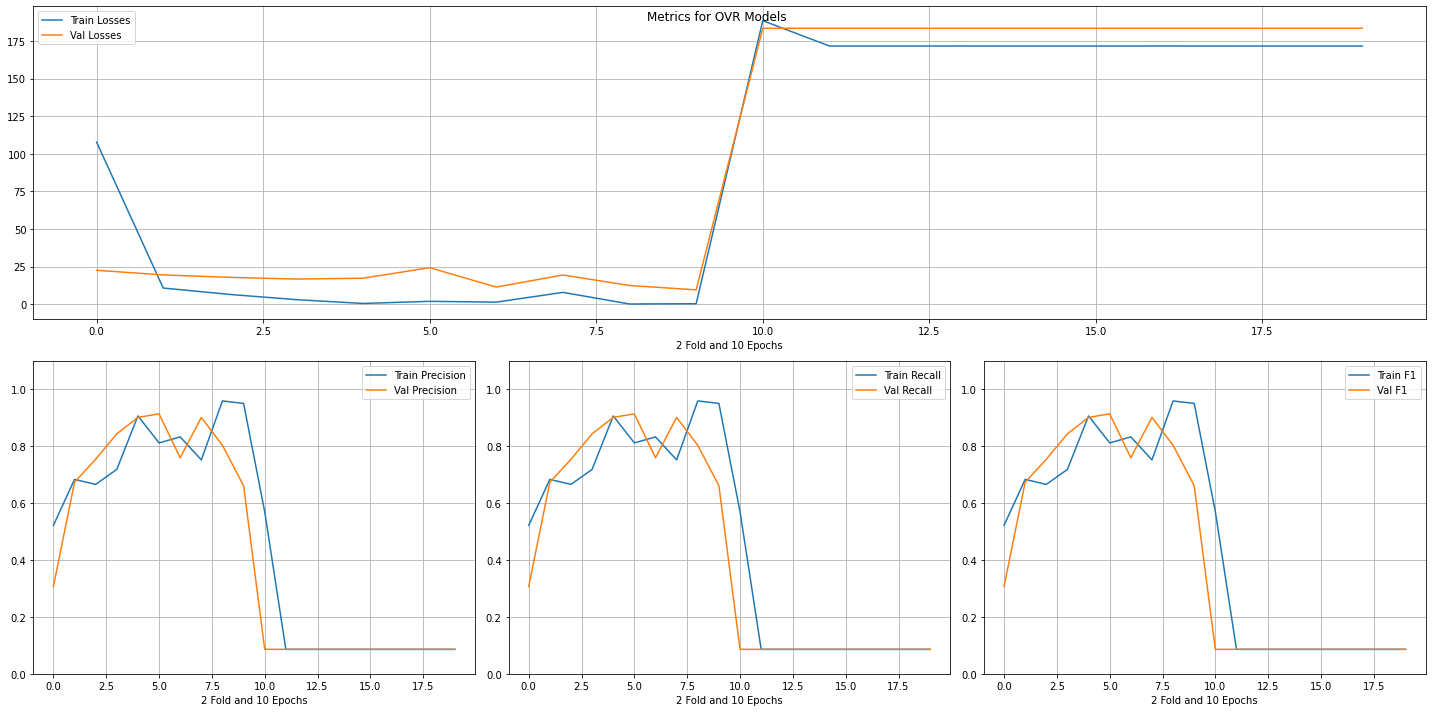

   train_f1  validation_f1  ...  train_losses  validation_losses
5  0.811951       0.914035  ...      1.878765          24.256094
4  0.906854       0.901754  ...      0.466022          17.262173
7  0.752197       0.901754  ...      7.828450          19.383485
3  0.718805       0.843860  ...      2.995768          16.696466
8  0.959578       0.803509  ...      0.112263          12.418068
6  0.833040       0.759649  ...      1.350928          11.366898
2  0.666081       0.754386  ...      6.463372          17.824992
1  0.683656       0.673684  ...     10.714244          19.443818
9  0.950791       0.661404  ...      0.292613           9.509854
0  0.521968       0.307018  ...    107.748836          22.526395
5  0.085965       0.086116  ...    171.656436         183.465543
8  0.085965       0.086116  ...    171.654445         183.465542
7  0.085965       0.086116  ...    171.660269         183.465542
6  0.085965       0.086116  ...    171.676876         183.465542
0  0.570175       0.08611

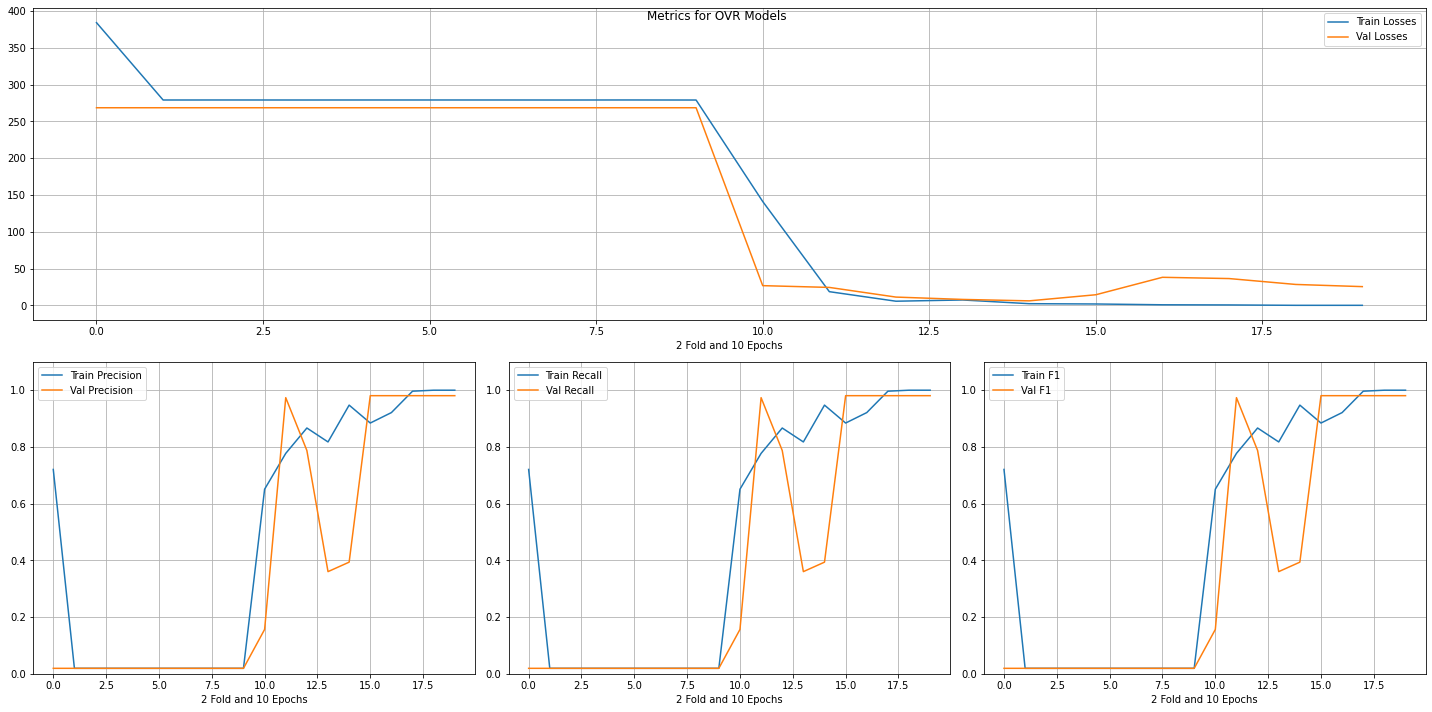

   train_f1  validation_f1  ...  train_losses  validation_losses
9  1.000000       0.980668  ...      0.000000          25.405890
8  1.000000       0.980668  ...      0.000000          28.369364
7  0.996491       0.980668  ...      0.521179          36.371022
6  0.921053       0.980668  ...      0.729973          38.076033
5  0.884211       0.980668  ...      1.814137          14.365779
1  0.777193       0.973638  ...     18.550418          24.334130
2  0.866667       0.787346  ...      5.580095          11.190648
4  0.947368       0.393673  ...      2.215691           6.070559
3  0.817544       0.360281  ...      7.261316           8.012178
0  0.650877       0.156415  ...    141.114756          26.732315
1  0.019332       0.019298  ...    279.047190         268.523743
9  0.019332       0.019298  ...    279.022502         268.523743
8  0.019332       0.019298  ...    279.101883         268.523743
7  0.019332       0.019298  ...    279.041641         268.523743
6  0.019332       0.01929

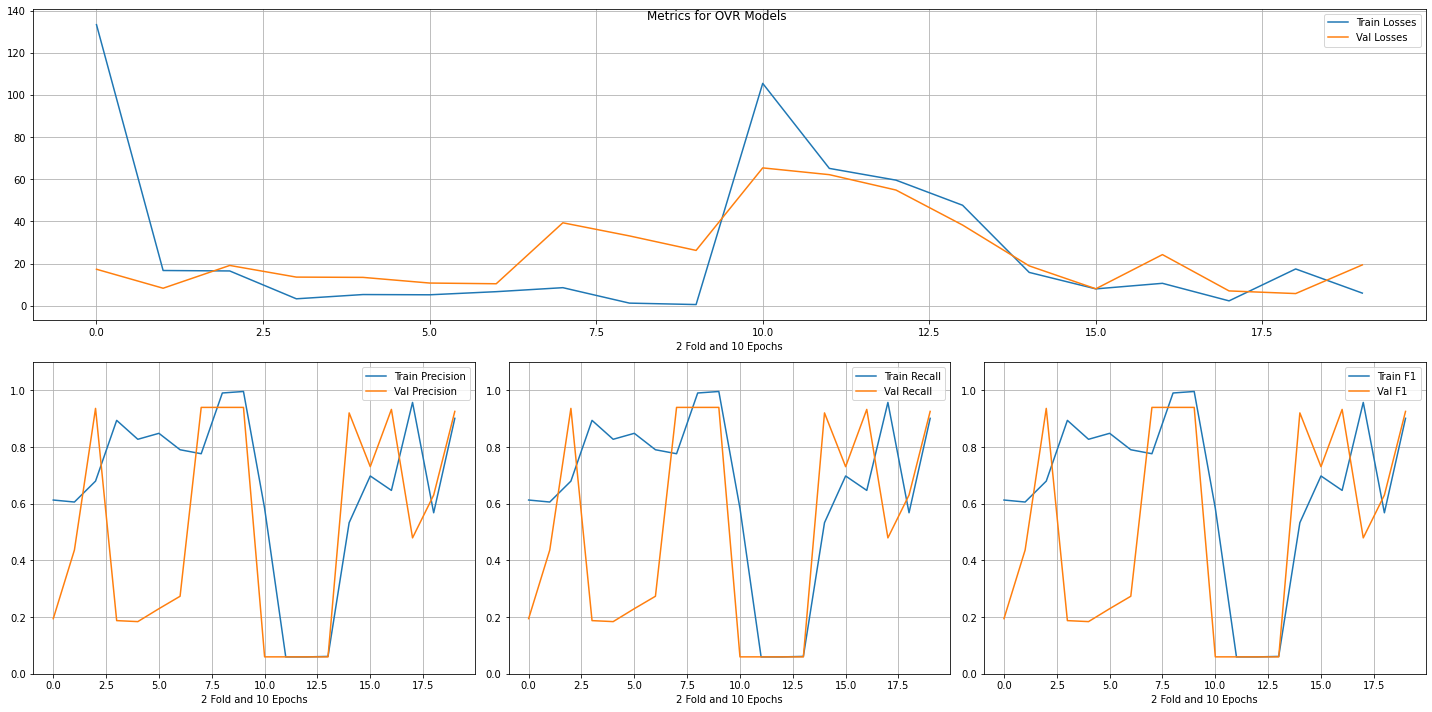

   train_f1  validation_f1  ...  train_losses  validation_losses
7  0.776801       0.940351  ...      8.526140          39.339840
8  0.991213       0.940351  ...      1.189077          33.107142
9  0.996485       0.940351  ...      0.509398          26.223891
2  0.680141       0.936842  ...     16.465047          19.082231
6  0.647368       0.933216  ...     10.594511          24.226891
9  0.901754       0.926186  ...      5.942553          19.337063
4  0.533333       0.920914  ...     15.776591          18.877408
5  0.698246       0.731107  ...      7.953263           7.995528
8  0.568421       0.630931  ...     17.415930           5.730898
7  0.957895       0.479789  ...      2.261322           6.980880
1  0.606327       0.436842  ...     16.682195           8.261022
6  0.790861       0.273684  ...      6.625362          10.385265
5  0.848858       0.229825  ...      5.145079          10.724860
0  0.613357       0.194737  ...    133.431188          17.276828
3  0.894552       0.18771

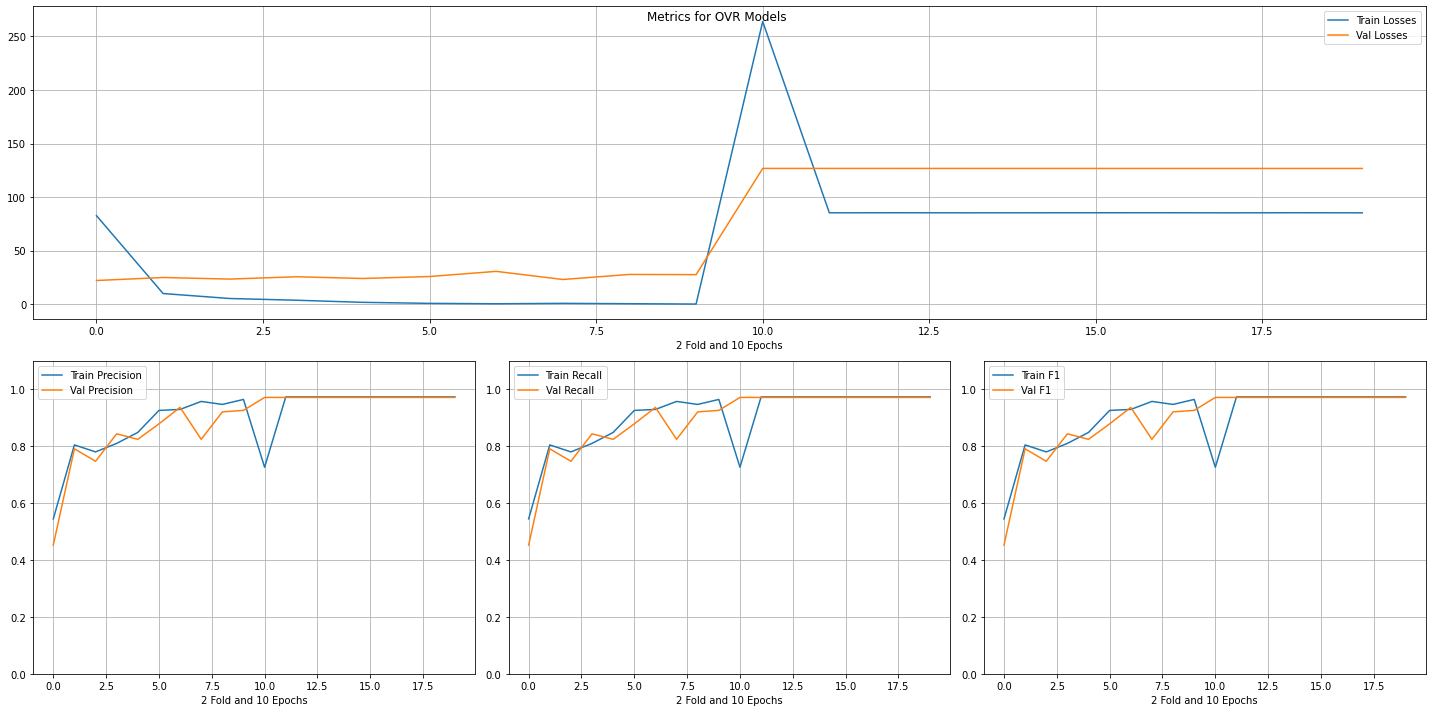

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.726316       0.971880  ...    263.859128         126.752397
1  0.973684       0.971880  ...     85.321523         126.749403
8  0.973684       0.971880  ...     85.378277         126.721683
7  0.973684       0.971880  ...     85.304040         126.725822
6  0.973684       0.971880  ...     85.379189         126.729935
5  0.973684       0.971880  ...     85.362479         126.734016
4  0.973684       0.971880  ...     85.342453         126.738022
3  0.973684       0.971880  ...     85.311599         126.741967
2  0.973684       0.971880  ...     85.370707         126.745791
9  0.973684       0.971880  ...     85.310500         126.717505
6  0.929701       0.936842  ...      0.404861          30.652426
9  0.964851       0.926316  ...      0.132339          27.594691
8  0.947276       0.921053  ...      0.457332          27.780764
5  0.926186       0.878947  ...      0.782581          25.840240
3  0.810193       0.84386

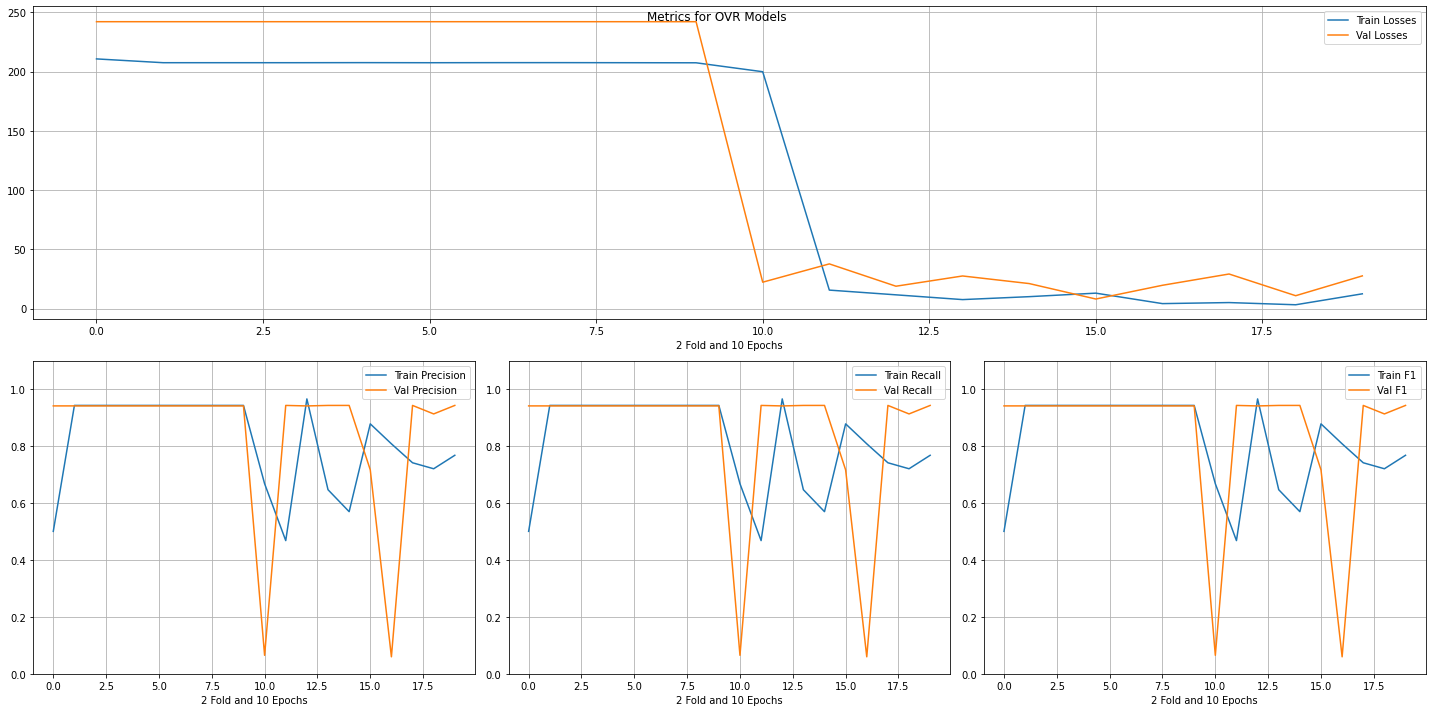

   train_f1  validation_f1  ...  train_losses  validation_losses
9  0.768421       0.943761  ...     12.422357          27.558296
7  0.742105       0.943761  ...      5.034313          29.145472
4  0.570175       0.943761  ...     10.022385          21.072330
3  0.647368       0.943761  ...      7.543442          27.481215
1  0.468421       0.943761  ...     15.557157          37.680921
8  0.943761       0.942105  ...    207.473768         242.087507
1  0.943761       0.942105  ...    207.483590         242.087507
9  0.943761       0.942105  ...    207.404074         242.087507
0  0.500879       0.942105  ...    210.684581         242.087507
7  0.943761       0.942105  ...    207.535847         242.087507
6  0.943761       0.942105  ...    207.528241         242.087507
5  0.943761       0.942105  ...    207.465955         242.087507
4  0.943761       0.942105  ...    207.540052         242.087507
3  0.943761       0.942105  ...    207.483851         242.087507
2  0.943761       0.94210

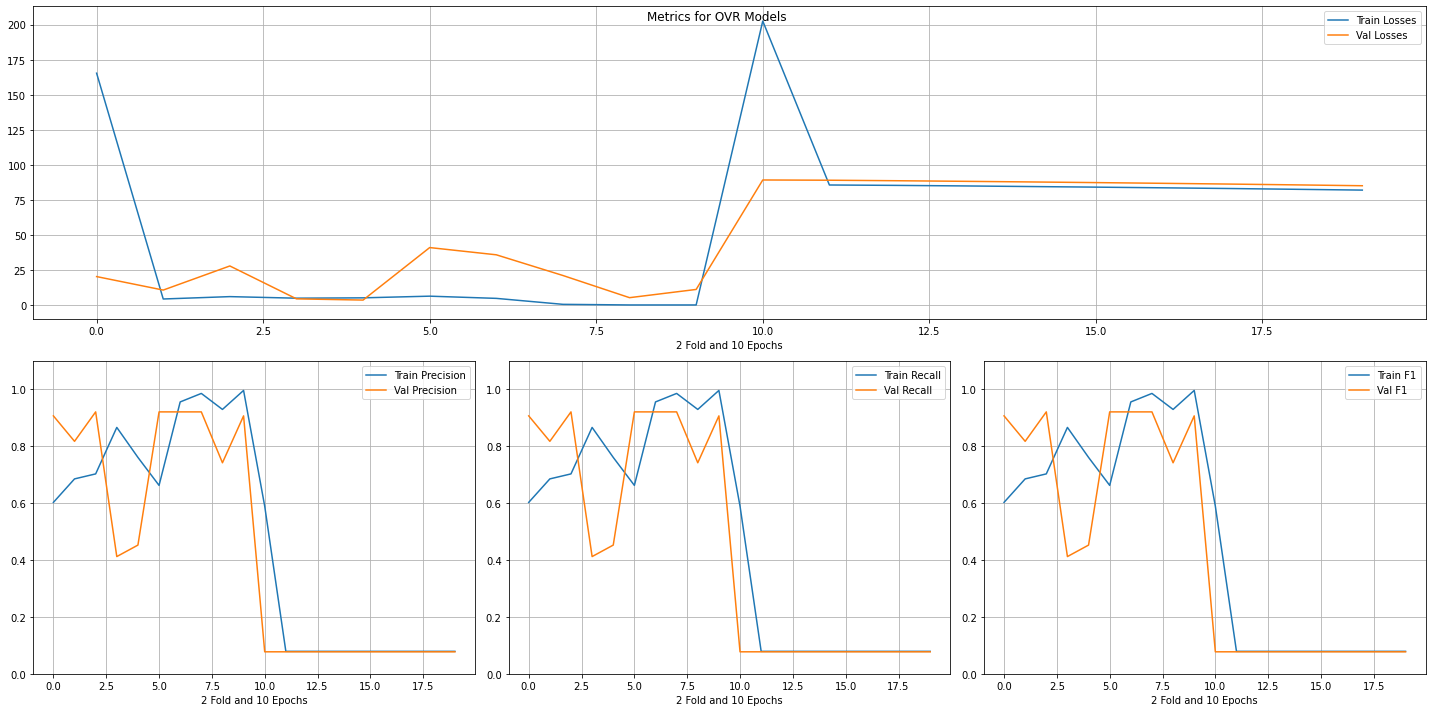

   train_f1  validation_f1  ...  train_losses  validation_losses
2  0.702988       0.921053  ...      6.095770          27.953135
5  0.662566       0.921053  ...      6.420920          41.065381
6  0.956063       0.921053  ...      4.848049          35.910508
7  0.985940       0.921053  ...      0.592960          21.156142
0  0.602812       0.907018  ...    165.382410          20.379291
9  0.996485       0.907018  ...      0.155951          11.215133
1  0.685413       0.817544  ...      4.406583          10.764724
8  0.929701       0.742105  ...      0.156242           5.349446
4  0.760984       0.452632  ...      5.226888           3.636803
3  0.866432       0.412281  ...      4.981638           4.507656
5  0.078947       0.077329  ...     84.149645          87.381896
8  0.078947       0.077329  ...     82.608960          85.763581
7  0.078947       0.077329  ...     83.169167          86.337009
6  0.078947       0.077329  ...     83.671795          86.875461
0  0.589474       0.07732

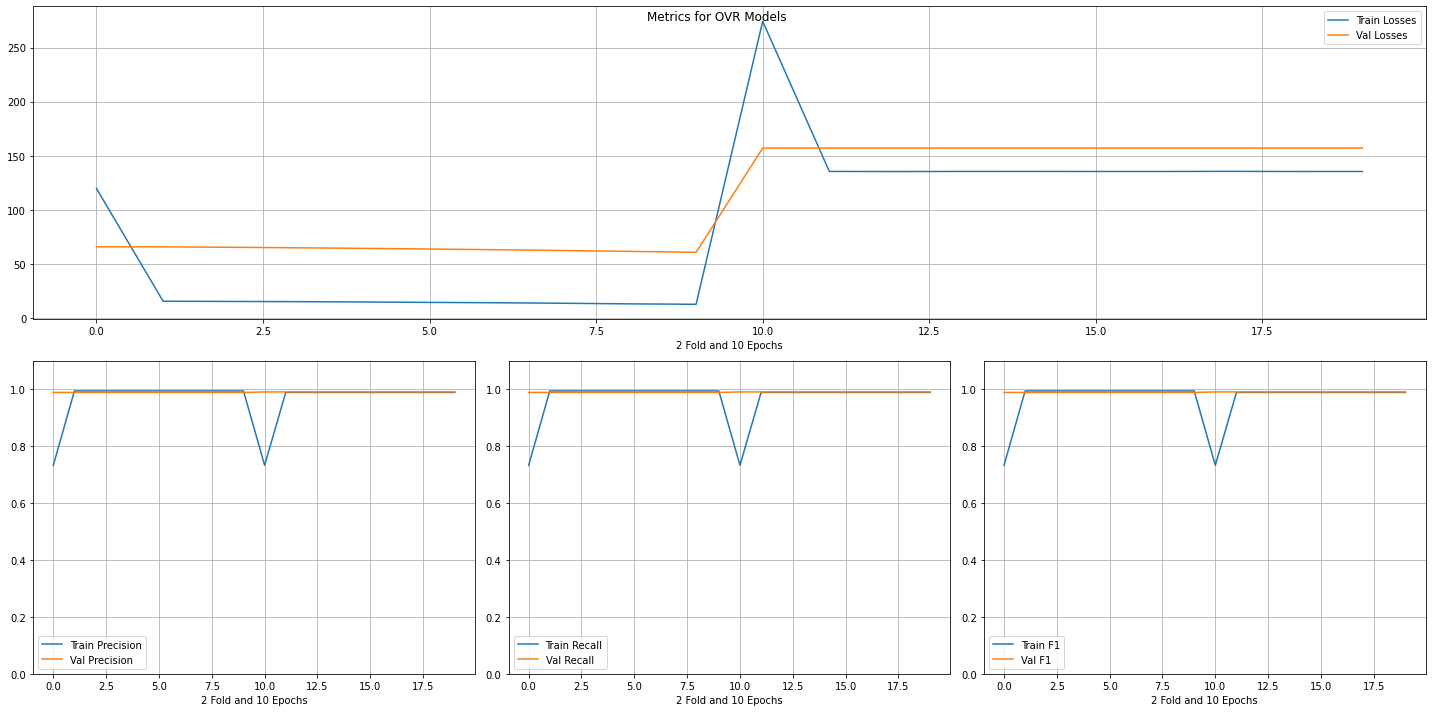

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.733333       0.991213  ...    274.278407         157.059948
1  0.989474       0.991213  ...    135.534154         157.059945
8  0.989474       0.991213  ...    135.465744         157.059757
7  0.989474       0.991213  ...    135.597595         157.059791
6  0.989474       0.991213  ...    135.474720         157.059821
5  0.989474       0.991213  ...    135.482424         157.059855
4  0.989474       0.991213  ...    135.534683         157.059887
3  0.989474       0.991213  ...    135.514618         157.059904
2  0.989474       0.991213  ...    135.423462         157.059931
9  0.989474       0.991213  ...    135.484853         157.059740
1  0.994728       0.989474  ...     15.600642          65.824137
9  0.994728       0.989474  ...     12.777370          60.792731
8  0.994728       0.989474  ...     13.168216          61.674697
7  0.994728       0.989474  ...     13.724384          62.471241
6  0.994728       0.98947

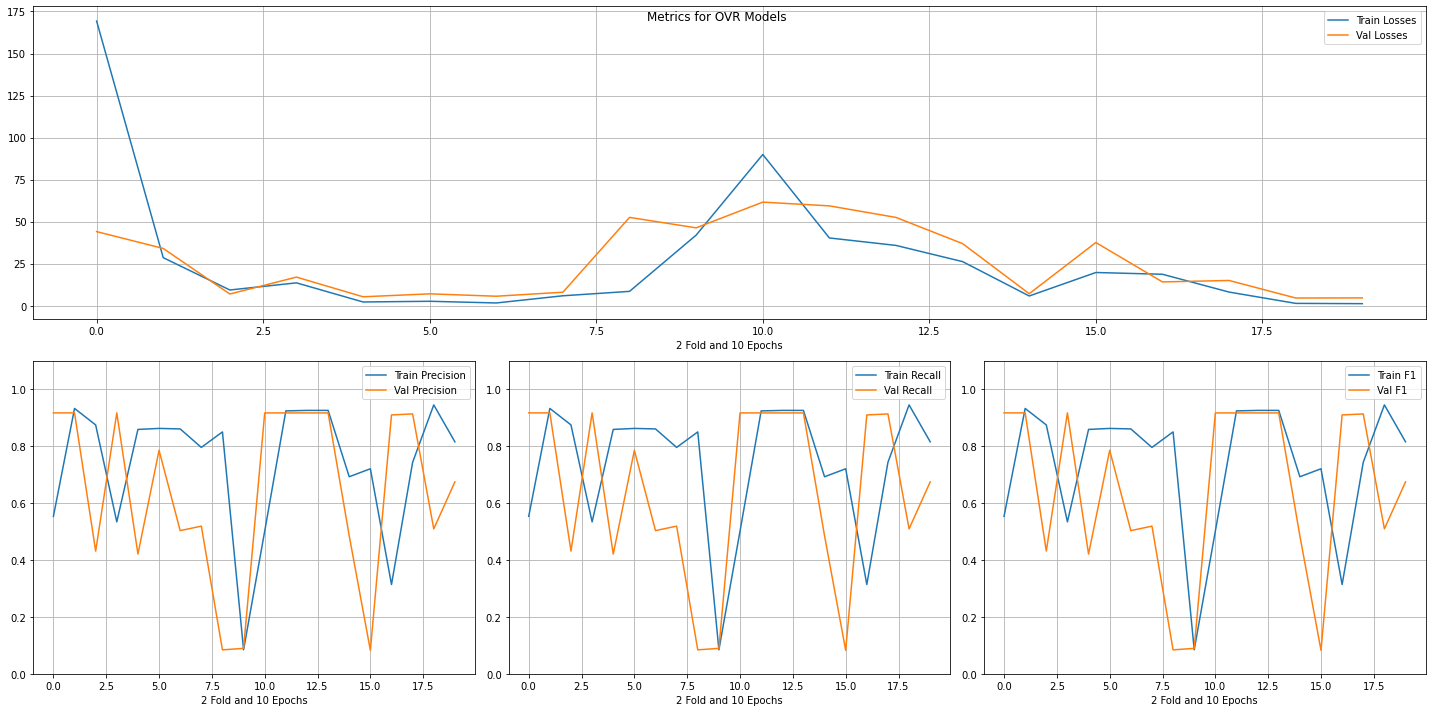

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.553603       0.917544  ...    169.295984          44.090018
1  0.933216       0.917544  ...     28.596369          34.074970
3  0.534271       0.917544  ...     13.617671          17.031698
3  0.926316       0.917399  ...     26.236836          36.939880
2  0.926316       0.917399  ...     35.880170          52.520038
1  0.924561       0.917399  ...     40.312842          59.394369
0  0.501754       0.917399  ...     89.948468          61.614291
7  0.743860       0.913884  ...      8.133877          15.035822
6  0.314035       0.910369  ...     18.721829          14.170675
5  0.862917       0.785965  ...      2.661822           7.075398
9  0.815789       0.674868  ...      1.243541           4.663656
7  0.796134       0.519298  ...      5.931097           8.052946
8  0.945614       0.509666  ...      1.412721           4.602673
6  0.861160       0.503509  ...      1.659158           5.668018
4  0.692982       0.48506

In [77]:
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, MfccMatrixDataset, MfccRaga, "OVR Models", labels, le.classes_)

# Mapping each Raga with Janaka Ragam

In [78]:
janaka_raga_map ={'లలిత':'Mayamalavagowla',
'సాళంగనాట':'Mayamalavagowla',
'సామంతం':'Naganandini',
'బౌళి':'Mayamalavagowla',
'శంకరాభరణం':'Shankarabharanam',
'శ్రీరాగం':'Kharaharapriya',
'రామక్రియ':'Mayamalavagowla',
'ముఖారి':'Kharaharapriya',
'పాడి':'Mayamalavagowla',
'ఆహిరి':'Vakulabharanam',
'దేసాళం':'Unknown',
'దేవగాంధారి':'Shankarabharanam',
'శుద్ధవసంతం':'Shankarabharanam',
'భూపాలం':'Shubhapantuvarali',
'దేసాక్షి':'Harikambhoji',
'గుండుక్రియ':'Mayamalavagowla',
'భైరవి':'Natabhairavi',
'నాట':'Chalanata',
'వరాళి':'Jhalavarali',
'ధన్నాసి':'Hanumatodi',
'మలహరి':'Mayamalavagowla',
'కాంబోది':'Harikambhoji',
'మాళవిగౌళ':'Mayamalavagowla',
'మాళవి':'Harikambhoji',
'గుజ్జరి':'Unknown',
'కన్నడగౌళ':'Kharaharapriya',
'గౌళ':'Mayamalavagowla',
'బౌళిరామక్రియ':'Mayamalavagowla',
'నాదరామక్రియ':'Unknown',
'సాళంగం':'Kalyani'}

In [80]:
data['janaka_ragam'] = data.apply(lambda x:janaka_raga_map[x['Ragam']],axis=1)

In [85]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

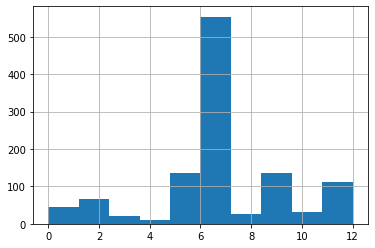

In [87]:
data['JanakaRagamCode'].hist()

In [89]:
class MfccMatrixJanakaRagaDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __get__(self,index):
      if self.mfcc_vals[index].shape[1] < 9601:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(40,9601-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mfcc'].iloc[x] for x in train_ids]
      test_vals = [data['mfcc'].iloc[x] for x in test_ids]
      train_data = MfccMatrixDataset(train_lbls, train_vals)
      test_data = MfccMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/10 : Training Loss: 133.811 / Validation Loss : 114.819 [Time Taken : 3.478401 seconds]
Epoch 2/10 : Training Loss: 38.647 / Validation Loss : 114.815 [Time Taken : 3.419333 seconds]
Epoch 3/10 : Training Loss: 38.659 / Validation Loss : 114.808 [Time Taken : 3.395275 seconds]
Epoch 4/10 : Training Loss: 38.524 / Validation Loss : 114.800 [Time Taken : 3.493601 seconds]
Epoch 5/10 : Training Loss: 38.511 / Validation Loss : 114.791 [Time Taken : 3.439306 seconds]
Epoch 6/10 : Training Loss: 38.455 / Validation Loss : 114.782 [Time Taken : 3.437167 seconds]
Epoch 7/10 : Training Loss: 38.559 / Validation Loss : 114.773 [Time Taken : 3.436475 seconds]
Epoch 8/10 : Training Loss: 38.406 / Validation Loss : 114.764 [Time Taken : 3.420571 seconds]
Epoch 9/10 : Training Loss: 38.573 / Validation Loss : 114.755 [Time Taken : 3.42175 seconds]
Epoch 10

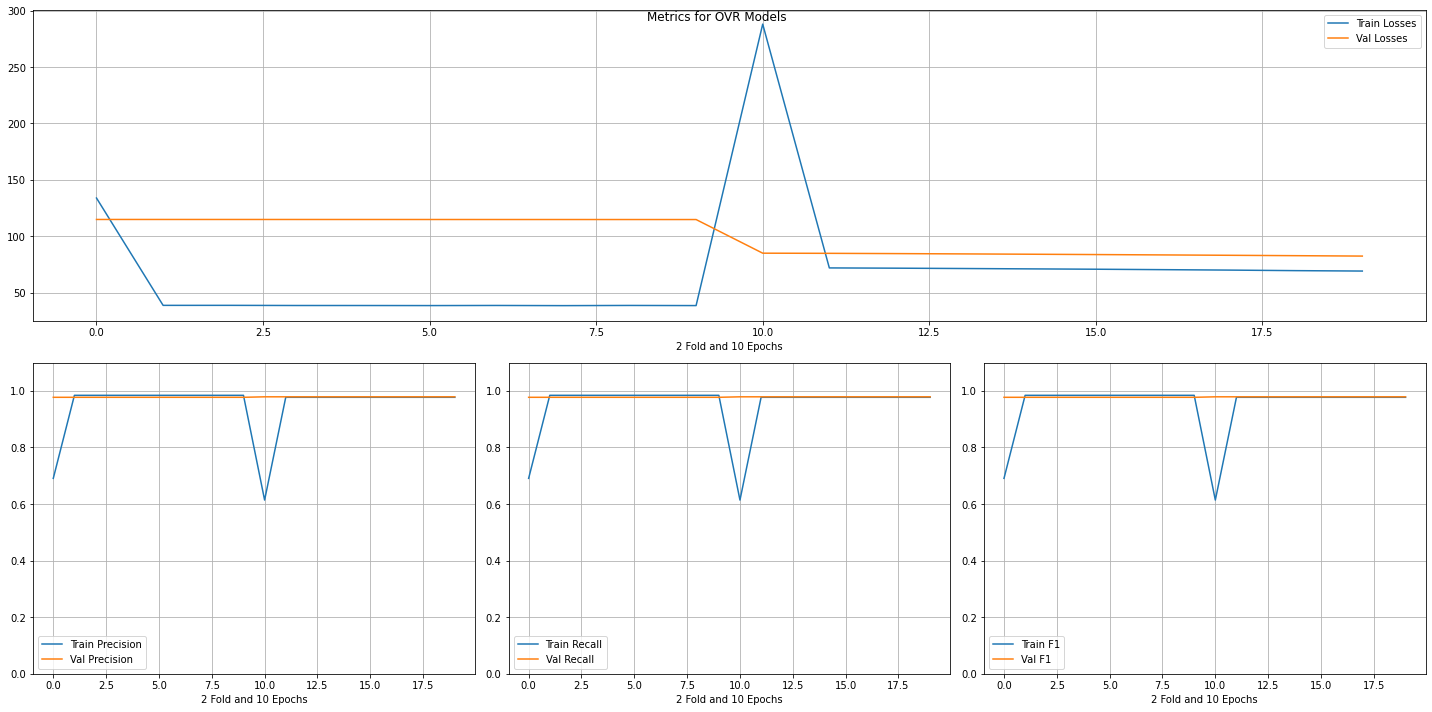

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.614035       0.978910  ...    288.031252          84.918054
1  0.977193       0.978910  ...     71.851336          84.785533
8  0.977193       0.978910  ...     69.441824          82.706090
7  0.977193       0.978910  ...     69.920764          83.049733
6  0.977193       0.978910  ...     70.314203          83.378871
5  0.977193       0.978910  ...     70.692431          83.693787
4  0.977193       0.978910  ...     71.002071          83.994546
3  0.977193       0.978910  ...     71.323452          84.280436
2  0.977193       0.978910  ...     71.620418          84.548496
9  0.977193       0.978910  ...     69.070903          82.347331
1  0.984183       0.977193  ...     38.646708         114.815390
9  0.984183       0.977193  ...     38.452080         114.746358
8  0.984183       0.977193  ...     38.573222         114.755429
7  0.984183       0.977193  ...     38.405940         114.764432
6  0.984183       0.97719

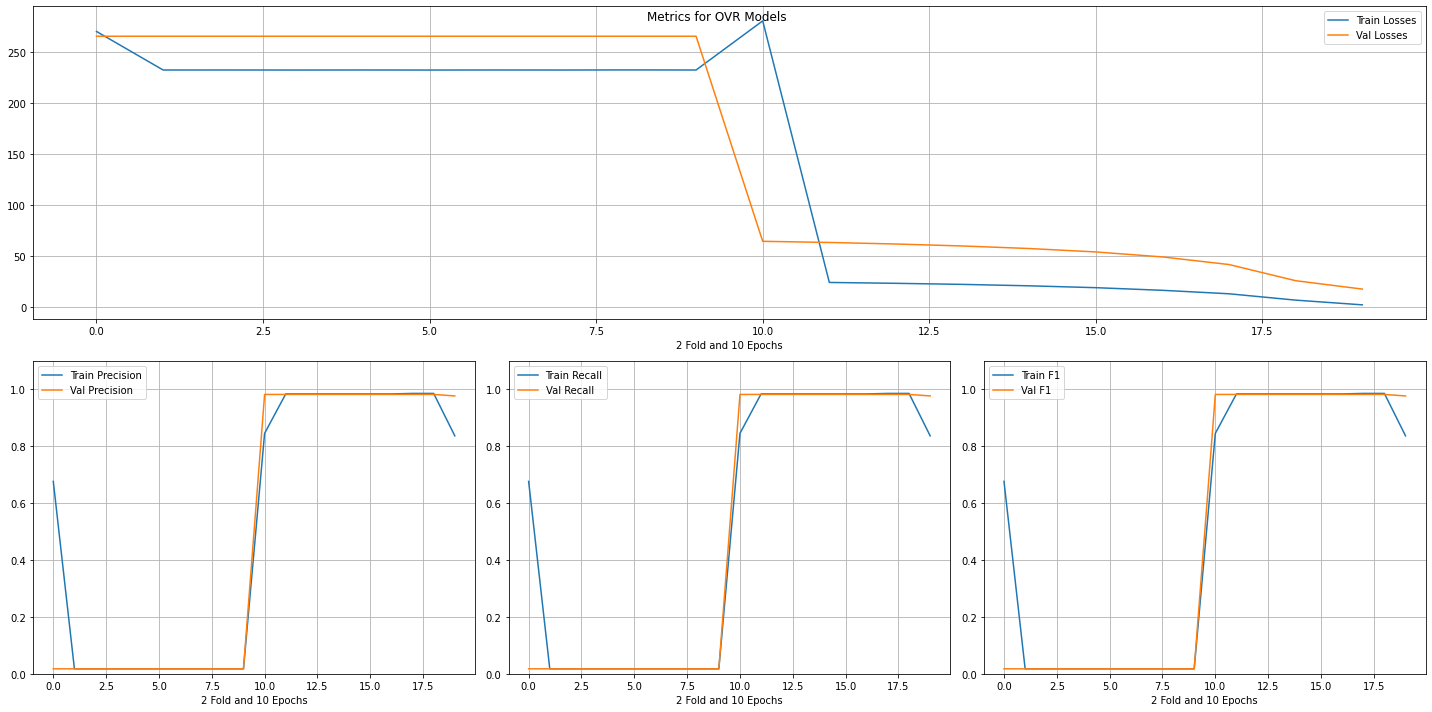

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.845614       0.982425  ...    280.787578          64.450782
1  0.984211       0.982425  ...     24.074647          63.315301
8  0.985965       0.982425  ...      6.710974          25.775168
7  0.985965       0.982425  ...     12.946014          41.636565
6  0.984211       0.982425  ...     16.352794          49.118404
5  0.984211       0.982425  ...     18.935953          54.009727
4  0.984211       0.982425  ...     20.763621          57.363436
3  0.984211       0.982425  ...     22.170019          59.856701
2  0.984211       0.982425  ...     23.208985          61.793246
9  0.836842       0.977153  ...      2.090063          17.556277
1  0.017575       0.017544  ...    232.579662         265.713206
9  0.017575       0.017544  ...    232.574533         265.713206
8  0.017575       0.017544  ...    232.659815         265.713206
7  0.017575       0.017544  ...    232.554640         265.713206
6  0.017575       0.01754

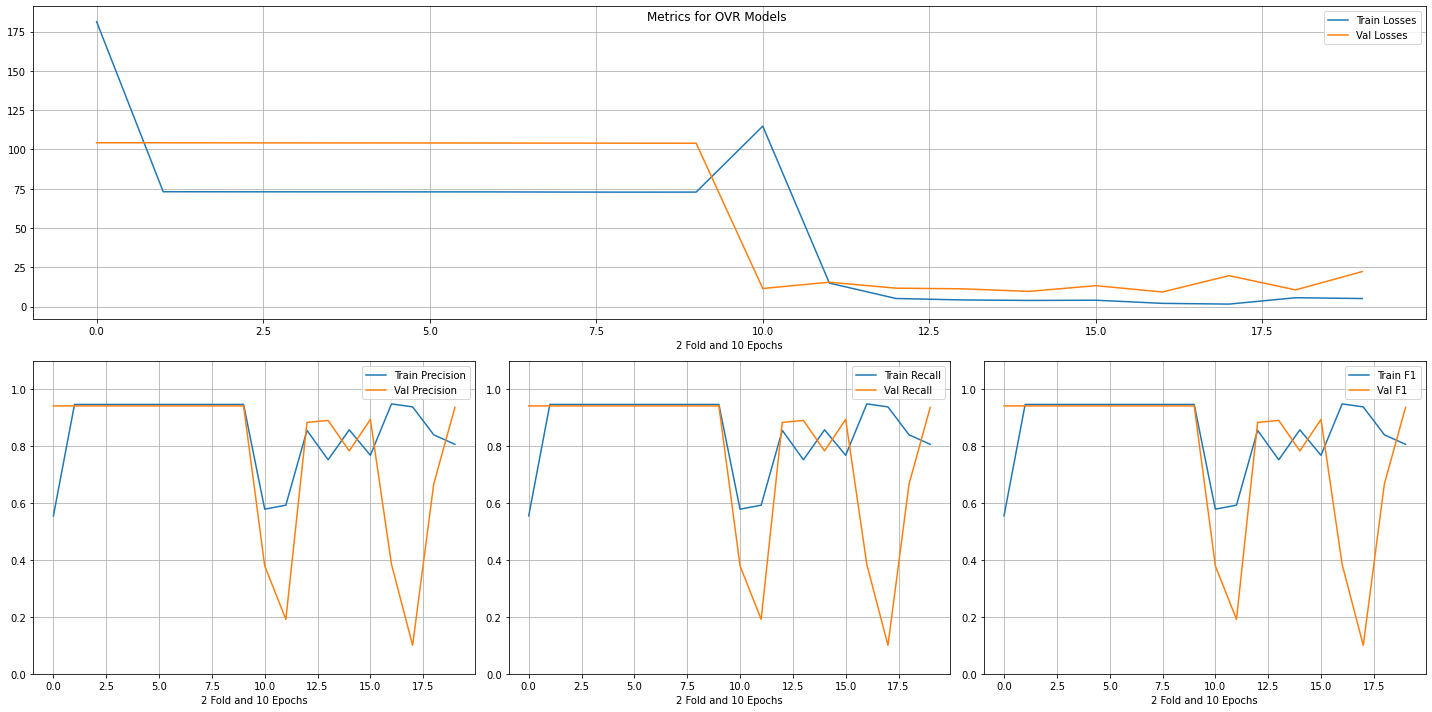

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.555360       0.942105  ...    181.273767         104.247892
1  0.947276       0.942105  ...     73.097661         104.230857
2  0.947276       0.942105  ...     73.054781         104.200793
3  0.947276       0.942105  ...     73.036314         104.167260
4  0.947276       0.942105  ...     73.035546         104.132144
5  0.947276       0.942105  ...     73.004232         104.095989
6  0.947276       0.942105  ...     72.987211         104.059021
7  0.947276       0.942105  ...     72.882764         104.021394
8  0.947276       0.942105  ...     72.847467         103.983220
9  0.947276       0.942105  ...     72.863776         103.944531
9  0.807018       0.936731  ...      5.150586          22.322435
5  0.768421       0.894552  ...      4.076671          13.334499
3  0.752632       0.891037  ...      4.253483          11.335714
2  0.856140       0.884007  ...      5.164507          11.737160
4  0.857895       0.78383

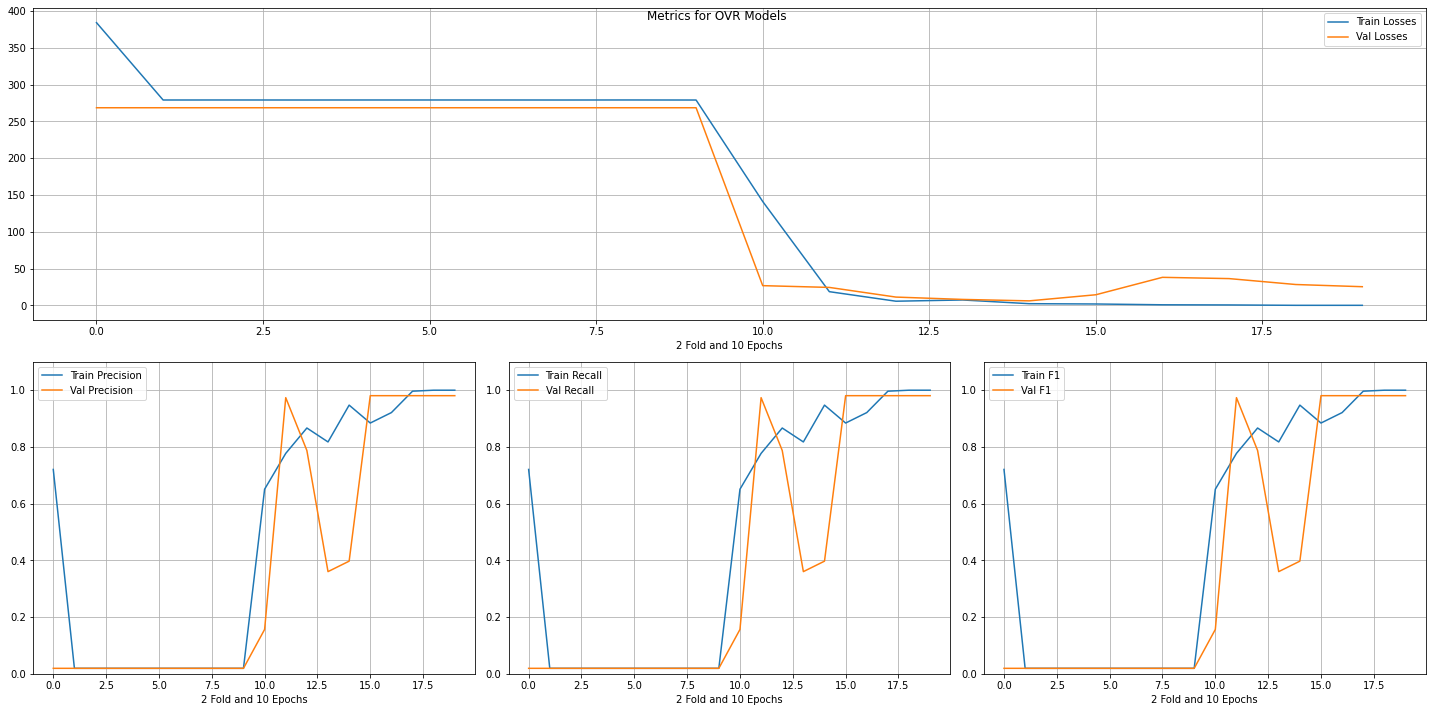

   train_f1  validation_f1  ...  train_losses  validation_losses
9  1.000000       0.980668  ...      0.000000          25.293978
8  1.000000       0.980668  ...      0.000000          28.282201
7  0.996491       0.980668  ...      0.511331          36.320016
6  0.921053       0.980668  ...      0.726355          38.034979
5  0.884211       0.980668  ...      1.808874          14.349998
1  0.777193       0.973638  ...     18.551188          24.335742
2  0.866667       0.787346  ...      5.579639          11.190161
4  0.947368       0.397188  ...      2.215375           6.062121
3  0.817544       0.360281  ...      7.262635           8.014487
0  0.650877       0.156415  ...    141.114688          26.731455
1  0.019332       0.019298  ...    279.047199         268.523749
9  0.019332       0.019298  ...    279.022508         268.523749
8  0.019332       0.019298  ...    279.101888         268.523749
7  0.019332       0.019298  ...    279.041649         268.523749
6  0.019332       0.01929

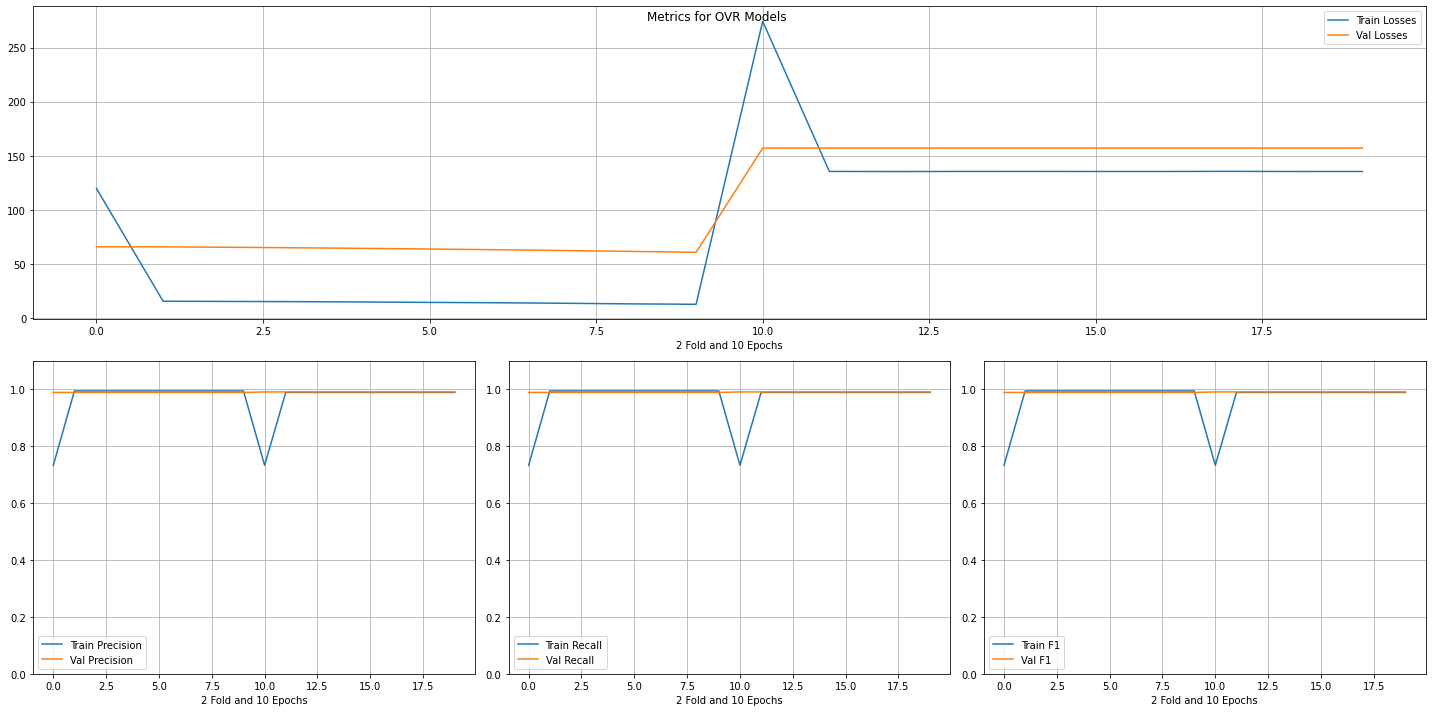

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.733333       0.991213  ...    274.278407         157.059948
1  0.989474       0.991213  ...    135.534158         157.059945
8  0.989474       0.991213  ...    135.465749         157.059760
7  0.989474       0.991213  ...    135.597597         157.059791
6  0.989474       0.991213  ...    135.474720         157.059831
5  0.989474       0.991213  ...    135.482424         157.059855
4  0.989474       0.991213  ...    135.534685         157.059887
3  0.989474       0.991213  ...    135.514618         157.059908
2  0.989474       0.991213  ...    135.423459         157.059931
9  0.989474       0.991213  ...    135.484853         157.059740
1  0.994728       0.989474  ...     15.600643          65.824137
9  0.994728       0.989474  ...     12.777370          60.792731
8  0.994728       0.989474  ...     13.168218          61.674697
7  0.994728       0.989474  ...     13.724385          62.471241
6  0.994728       0.98947

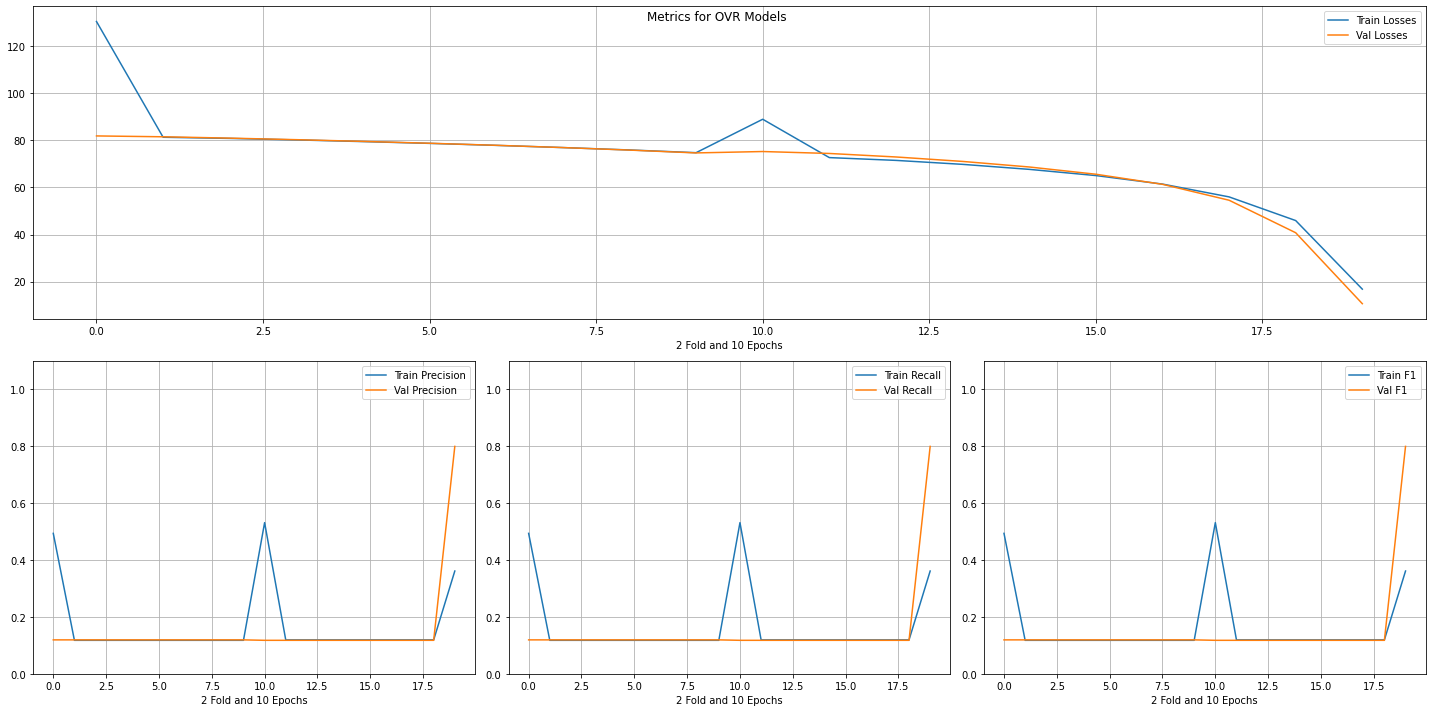

   train_f1  validation_f1  ...  train_losses  validation_losses
9  0.361404       0.799649  ...     16.780584          10.597118
6  0.117750       0.119298  ...     77.911593          77.940534
1  0.117750       0.119298  ...     81.360958          81.560563
9  0.117750       0.119298  ...     74.803285          74.700621
8  0.117750       0.119298  ...     75.957874          75.906024
7  0.117750       0.119298  ...     76.975827          76.977830
0  0.493849       0.119298  ...    130.576615          81.926105
5  0.117750       0.119298  ...     78.759687          78.812039
4  0.117750       0.119298  ...     79.518472          79.605332
3  0.117750       0.119298  ...     80.233517          80.329167
2  0.117750       0.119298  ...     80.867416          80.986466
1  0.119298       0.117750  ...     72.712148          74.468385
2  0.119298       0.117750  ...     71.525612          72.977096
3  0.119298       0.117750  ...     69.841025          71.086759
4  0.119298       0.11775

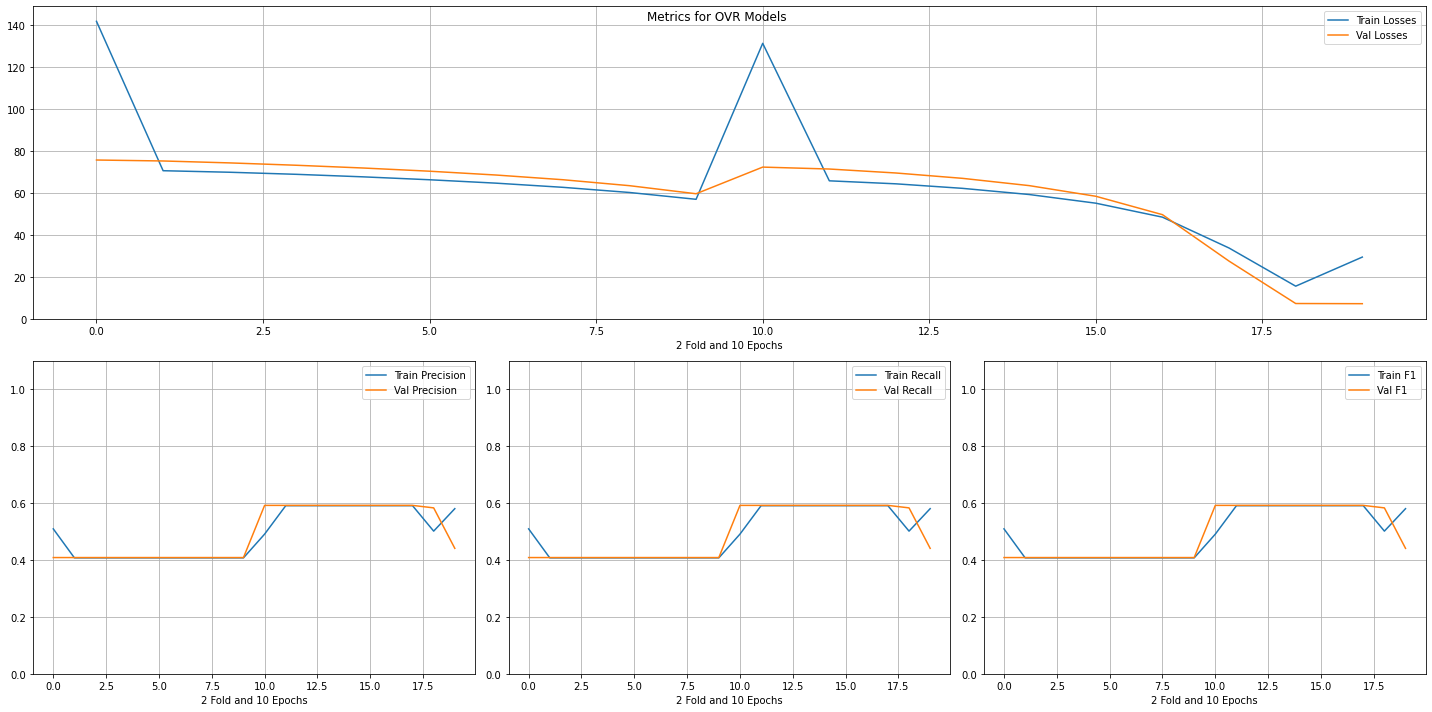

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.491228       0.592267  ...    131.406239          72.450875
1  0.591228       0.592267  ...     65.915734          71.534849
7  0.591228       0.592267  ...     33.905602          27.663620
6  0.591228       0.592267  ...     48.610925          49.798983
5  0.591228       0.592267  ...     55.260063          58.556131
4  0.591228       0.592267  ...     59.393048          63.630749
3  0.591228       0.592267  ...     62.327545          67.090945
2  0.591228       0.592267  ...     64.484521          69.644358
8  0.501754       0.583480  ...     15.735084           7.471196
9  0.580702       0.441125  ...     29.591379           7.390812
1  0.407733       0.408772  ...     70.730135          75.368058
9  0.407733       0.408772  ...     57.111730          59.757331
8  0.407733       0.408772  ...     60.360681          63.602339
7  0.407733       0.408772  ...     62.818409          66.440717
6  0.407733       0.40877

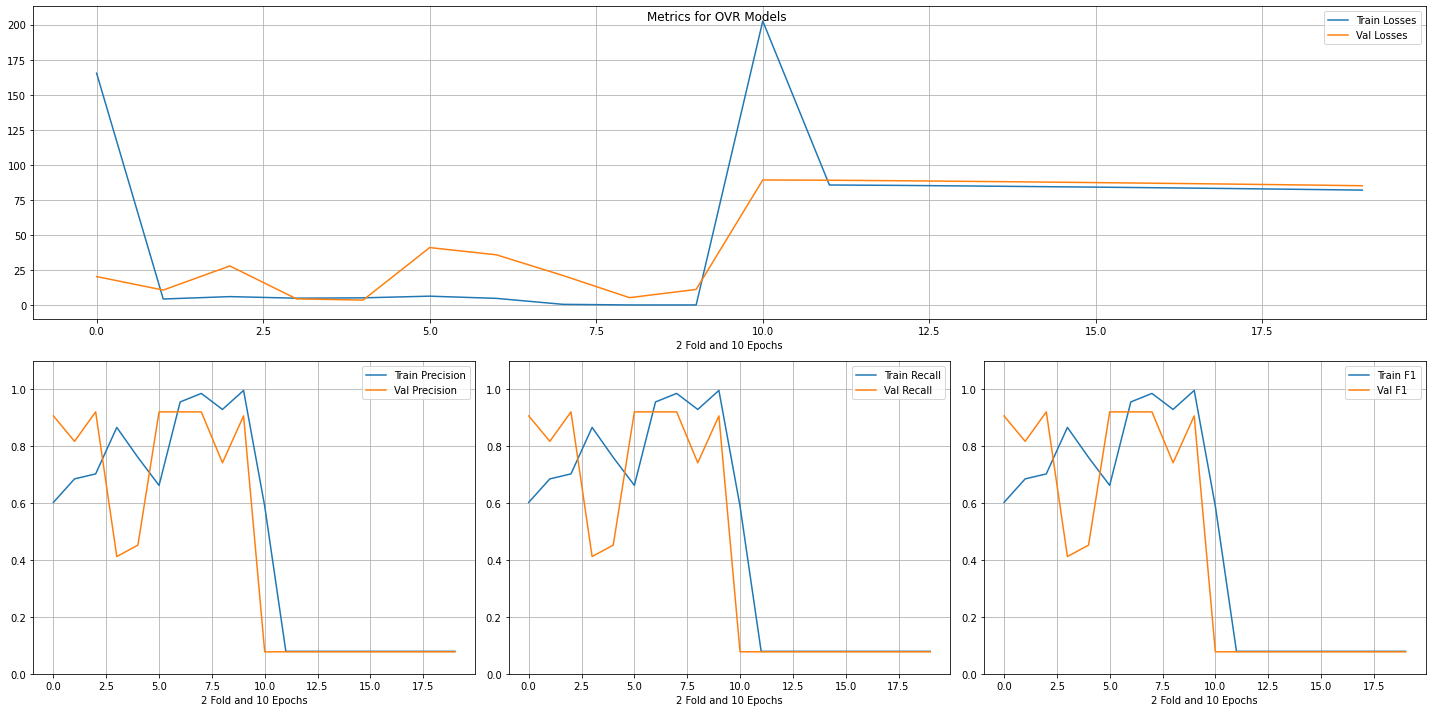

   train_f1  validation_f1  ...  train_losses  validation_losses
2  0.702988       0.921053  ...      6.095767          27.953123
5  0.662566       0.921053  ...      6.420944          41.065366
6  0.956063       0.921053  ...      4.848041          35.910465
7  0.985940       0.921053  ...      0.592941          21.156101
0  0.602812       0.907018  ...    165.382412          20.379287
9  0.996485       0.907018  ...      0.155931          11.217435
1  0.685413       0.817544  ...      4.406583          10.764722
8  0.929701       0.742105  ...      0.156238           5.349432
4  0.760984       0.452632  ...      5.226877           3.636806
3  0.866432       0.412281  ...      4.981636           4.507662
5  0.078947       0.077329  ...     84.149646          87.381898
8  0.078947       0.077329  ...     82.608962          85.763585
7  0.078947       0.077329  ...     83.169172          86.337013
6  0.078947       0.077329  ...     83.671797          86.875464
0  0.589474       0.07732

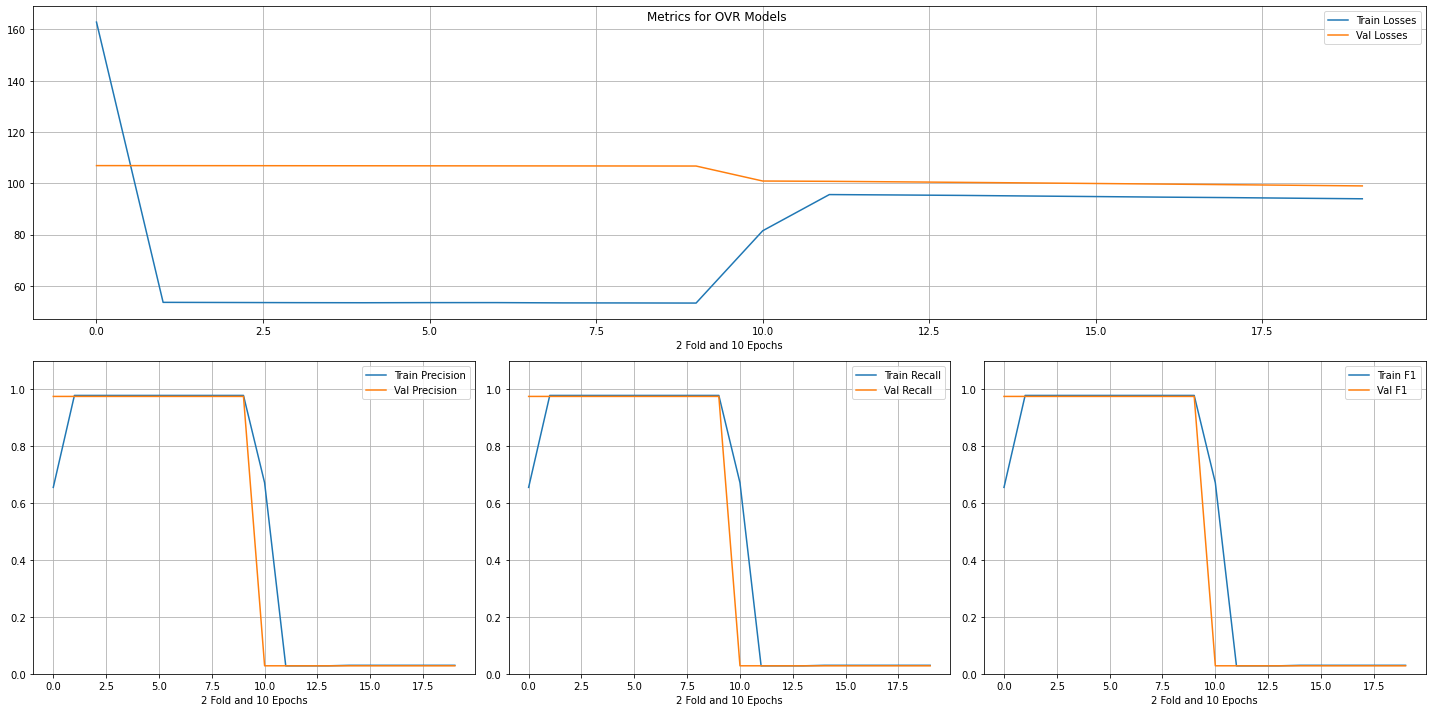

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.655536       0.975439  ...    162.875073         106.905478
2  0.978910       0.975439  ...     53.515400         106.879137
3  0.978910       0.975439  ...     53.454570         106.860561
4  0.978910       0.975439  ...     53.420756         106.841162
5  0.978910       0.975439  ...     53.468461         106.821220
6  0.978910       0.975439  ...     53.473026         106.800879
7  0.978910       0.975439  ...     53.360737         106.780217
8  0.978910       0.975439  ...     53.339485         106.759288
9  0.978910       0.975439  ...     53.293996         106.738120
1  0.978910       0.975439  ...     53.569951         106.895855
5  0.029825       0.028120  ...     94.829677          99.928146
8  0.029825       0.028120  ...     94.185438          99.230788
7  0.029825       0.028120  ...     94.424959          99.468867
6  0.029825       0.028120  ...     94.606270          99.701238
0  0.671930       0.02812

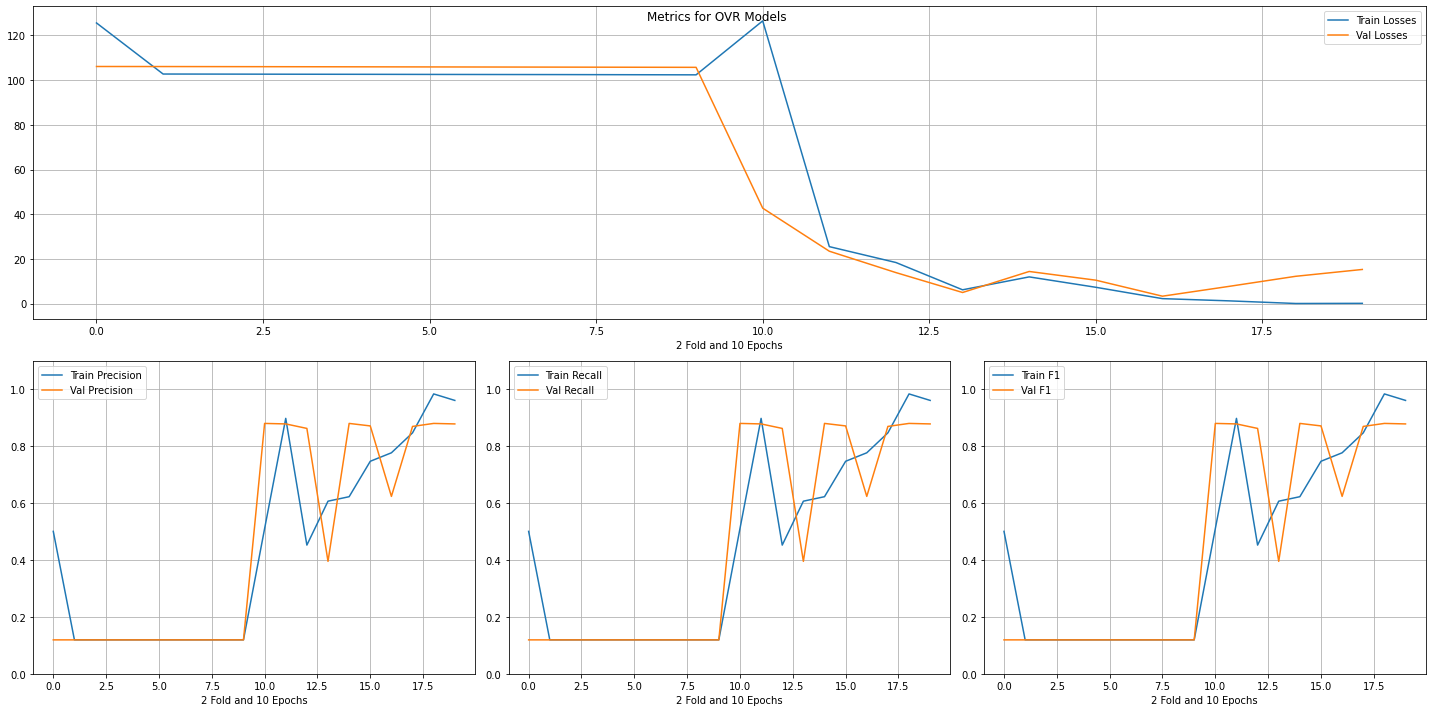

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.510526       0.880492  ...    126.522245          42.698965
8  0.984211       0.880492  ...      0.029755          12.201305
4  0.622807       0.880492  ...     11.935170          14.363336
1  0.898246       0.878735  ...     25.475489          23.425019
9  0.961404       0.878735  ...      0.097514          15.261895
5  0.747368       0.871705  ...      7.282425          10.465078
7  0.847368       0.869947  ...      1.208637           7.691692
2  0.452632       0.862917  ...     18.366786          13.854939
6  0.777193       0.623902  ...      2.202564           3.298390
3  0.607018       0.395431  ...      6.155391           4.952578
5  0.119508       0.119298  ...    102.556817         105.911139
6  0.119508       0.119298  ...    102.515547         105.865467
7  0.119508       0.119298  ...    102.480738         105.819052
8  0.119508       0.119298  ...    102.426681         105.771974
9  0.119508       0.11929

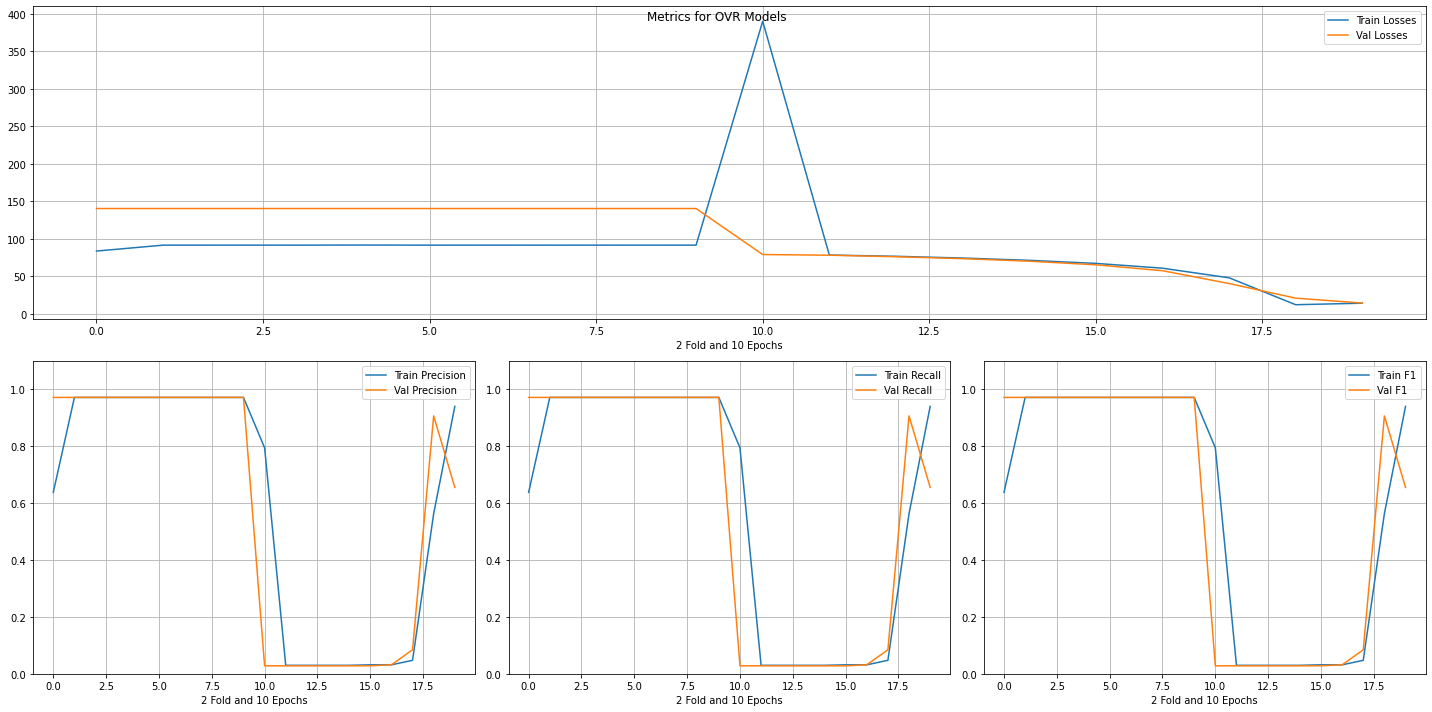

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.637961       0.971930  ...     83.844873         140.528418
2  0.971880       0.971930  ...     91.745609         140.527601
3  0.971880       0.971930  ...     91.713256         140.527063
4  0.971880       0.971930  ...     91.873565         140.526519
5  0.971880       0.971930  ...     91.714131         140.525963
6  0.971880       0.971930  ...     91.729682         140.525401
7  0.971880       0.971930  ...     91.702204         140.524835
8  0.971880       0.971930  ...     91.756365         140.524251
9  0.971880       0.971930  ...     91.747066         140.523680
1  0.971880       0.971930  ...     91.719414         140.528097
8  0.563158       0.906854  ...     12.302247          21.053897
9  0.940351       0.655536  ...     14.347903          14.504130
7  0.047368       0.084359  ...     48.216311          40.570283
6  0.031579       0.031634  ...     61.008436          57.648429
2  0.029825       0.02812

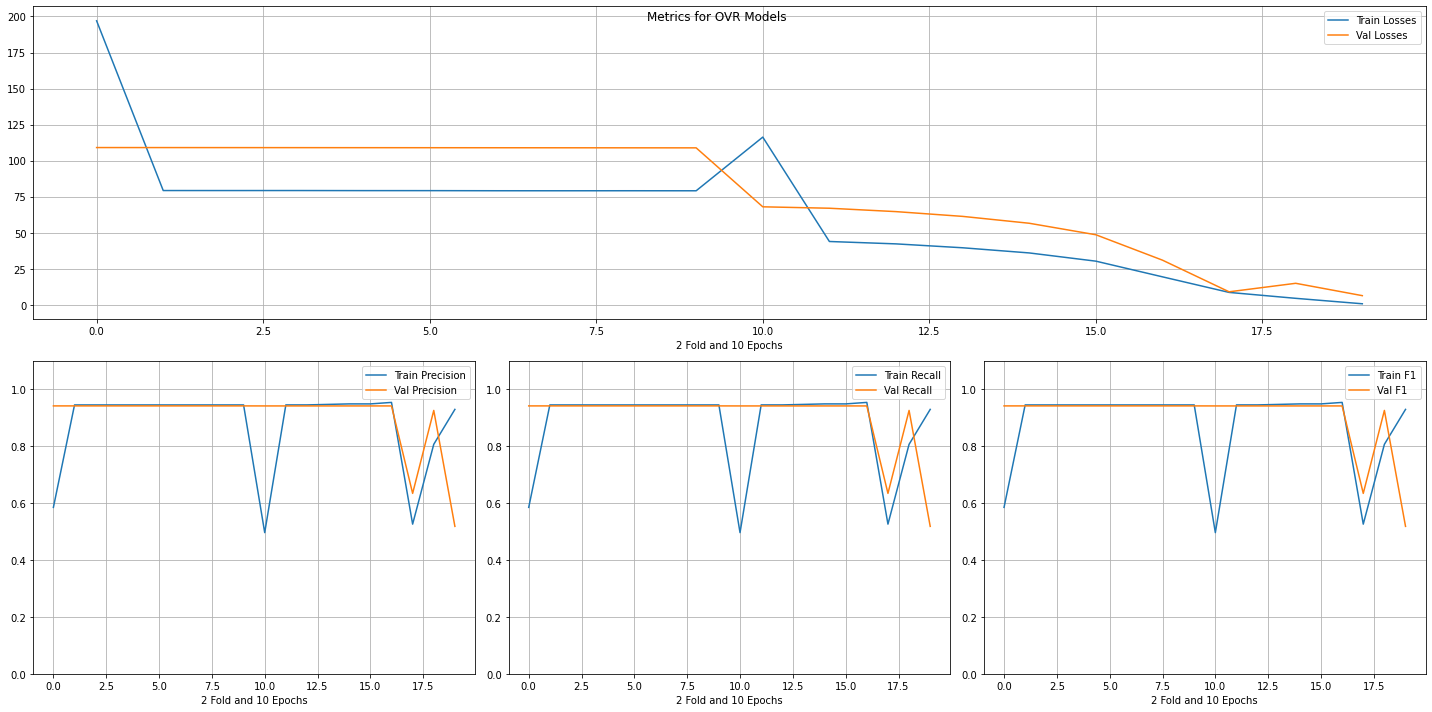

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.585237       0.942105  ...    197.002024         109.072413
2  0.945518       0.942105  ...     79.245816         109.037818
3  0.945518       0.942105  ...     79.256917         109.015321
4  0.945518       0.942105  ...     79.201468         108.992093
5  0.945518       0.942105  ...     79.189757         108.968399
6  0.945518       0.942105  ...     79.116747         108.944369
7  0.945518       0.942105  ...     79.099642         108.920032
8  0.945518       0.942105  ...     79.115369         108.895462
9  0.945518       0.942105  ...     79.089899         108.870670
1  0.945518       0.942105  ...     79.253827         109.058606
4  0.949123       0.942004  ...     35.970626          56.559812
6  0.954386       0.942004  ...     19.389919          30.955942
5  0.949123       0.942004  ...     30.266653          48.583162
0  0.496491       0.942004  ...    116.316782          67.969683
3  0.947368       0.94200

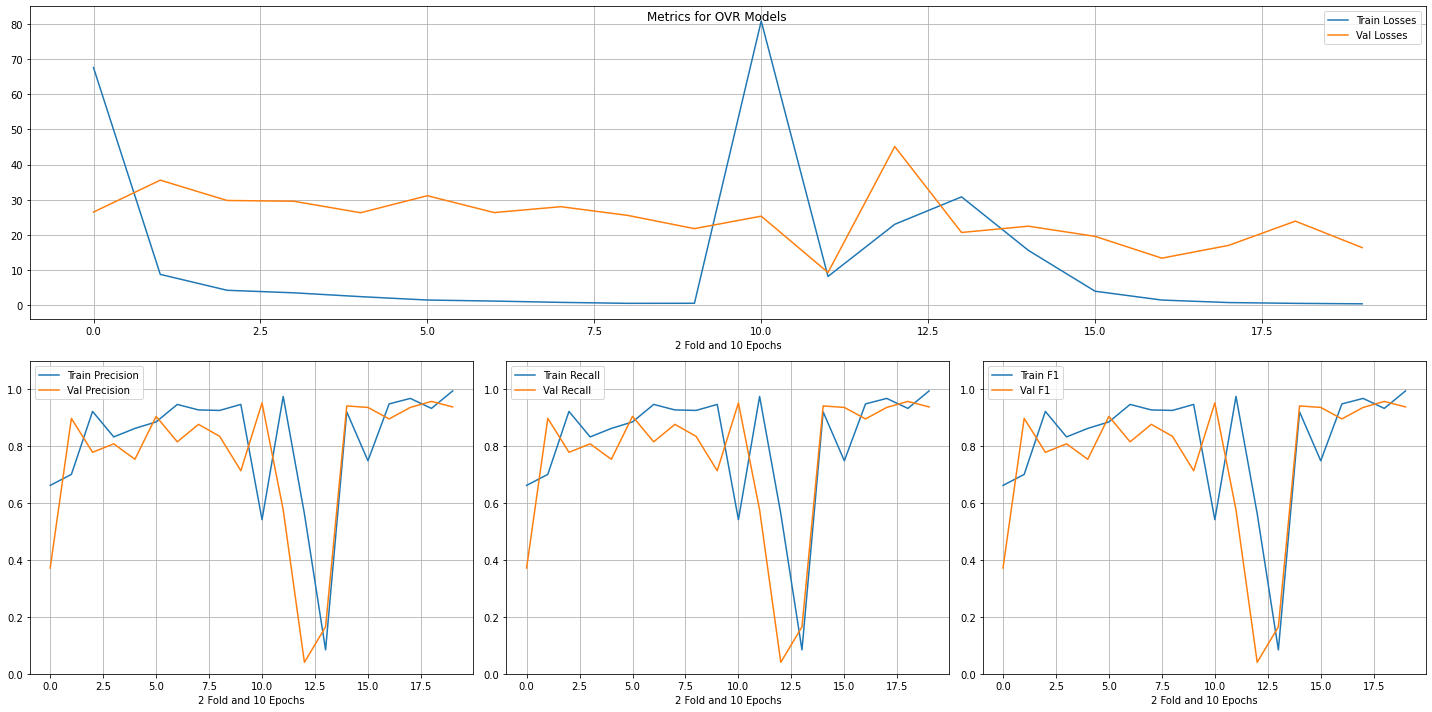

   train_f1  validation_f1  ...  train_losses  validation_losses
8  0.933333       0.957821  ...      0.508660          23.902457
0  0.542105       0.952548  ...     80.846516          25.316915
4  0.921053       0.942004  ...     15.597765          22.465594
9  0.994737       0.938489  ...      0.377515          16.365034
5  0.749123       0.936731  ...      3.960231          19.570239
7  0.968421       0.936731  ...      0.734800          17.002401
5  0.885764       0.905263  ...      1.453722          31.137271
1  0.701230       0.898246  ...      8.752355          35.559400
6  0.949123       0.896309  ...      1.446241          13.369395
7  0.927944       0.877193  ...      0.785943          28.010258
8  0.926186       0.835088  ...      0.514526          25.536569
6  0.947276       0.815789  ...      1.155397          26.339533
3  0.833040       0.808772  ...      3.507580          29.561673
2  0.922671       0.778947  ...      4.229921          29.780673
4  0.862917       0.75438

In [94]:
jlabels = jle.transform(jle.classes_)
jovr_res = ovr_train_model(data, MfccMatrixJanakaRagaDataset, MfccRaga, "OVR Models", jlabels, jle.classes_, lbl_encoder=jle, target='JanakaRagamCode')

# OVR Experiment without Mayamalavagowla Raga

In [108]:
cl = jle.classes_
mc = jle.transform(['Mayamalavagowla','Unknown'])
rdata = data[data['JanakaRagamCode']!=mc[0]]
rdata = rdata[rdata['JanakaRagamCode']!=mc[1]]
cl = [x for x in cl if not x in ['Mayamalavagowla','Unknown'] ]
jlabels1 = jle.transform(cl)

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.52144082 12.16      ]
Epoch 1/15 : Training Loss: 11.015 / Validation Loss : 11.945 [Time Taken : 1.855938 seconds]
Epoch 2/15 : Training Loss: 8.724 / Validation Loss : 3.243 [Time Taken : 1.825771 seconds]
Epoch 3/15 : Training Loss: 7.674 / Validation Loss : 4.866 [Time Taken : 1.828027 seconds]
Epoch 4/15 : Training Loss: 0.090 / Validation Loss : 5.324 [Time Taken : 1.805958 seconds]
Epoch 5/15 : Training Loss: 0.010 / Validation Loss : 7.813 [Time Taken : 1.795382 seconds]
Epoch 6/15 : Training Loss: 0.001 / Validation Loss : 7.775 [Time Taken : 1.806826 seconds]
Epoch 7/15 : Training Loss: 0.000 / Validation Loss : 7.642 [Time Taken : 1.827671 seconds]
Epoch 8/15 : Training Loss: 0.000 / Validation Loss : 7.547 [Time Taken : 1.810722 seconds]
Epoch 9/15 : Training Loss: 0.000 / Validation Loss : 7.483 [Time Taken : 1.812476 seconds]
Epoch 10/15 : Training Loss: 0.00

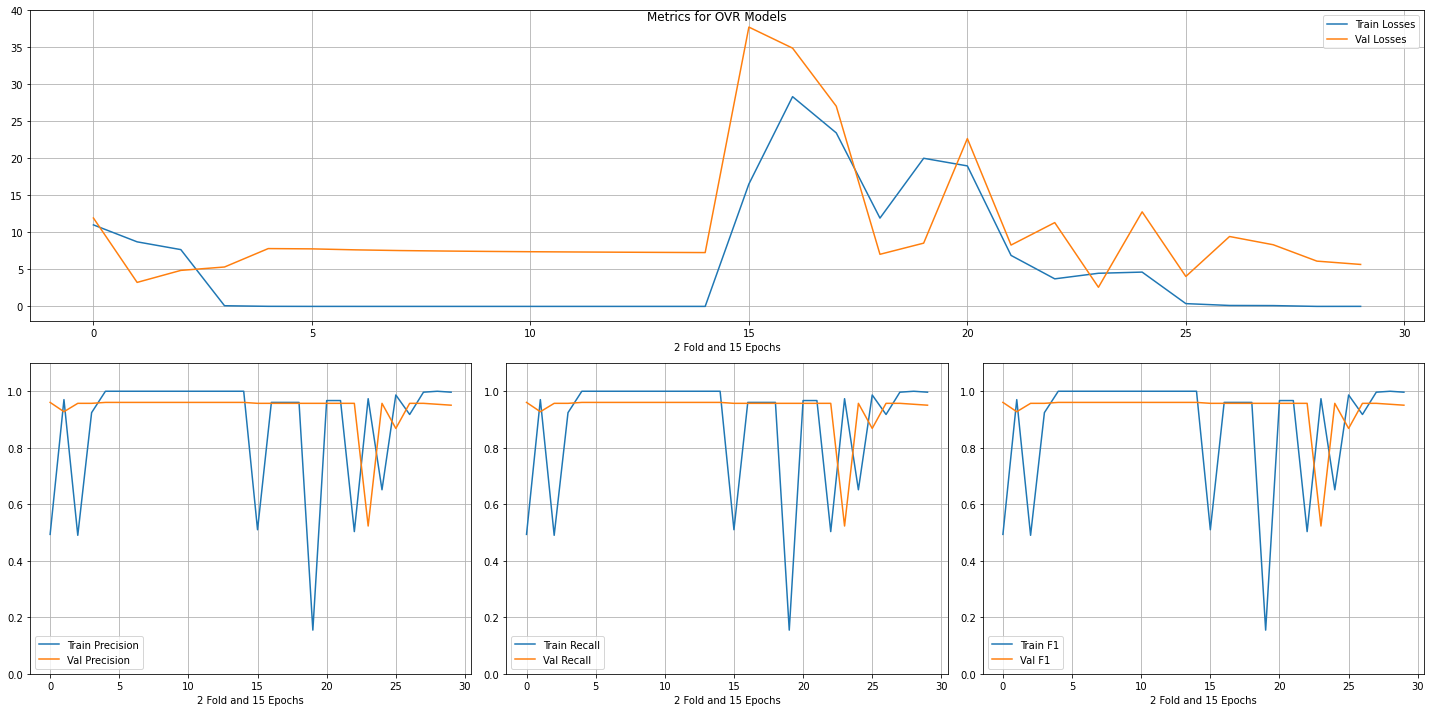

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.493421       0.960526  ...     11.015252          11.944601
8   1.000000       0.960526  ...      0.000117           7.483183
14  1.000000       0.960526  ...      0.000070           7.273525
13  1.000000       0.960526  ...      0.000065           7.299163
12  1.000000       0.960526  ...      0.000071           7.325497
11  1.000000       0.960526  ...      0.000069           7.354783
10  1.000000       0.960526  ...      0.000083           7.388708
9   1.000000       0.960526  ...      0.000103           7.431501
7   1.000000       0.960526  ...      0.000125           7.546964
6   1.000000       0.960526  ...      0.000284           7.641656
5   1.000000       0.960526  ...      0.000941           7.774593
4   1.000000       0.960526  ...      0.009818           7.813029
4   0.154605       0.957237  ...     20.016683           8.548399
11  0.917763       0.957237  ...      0.126850           9.445575
12  0.9967

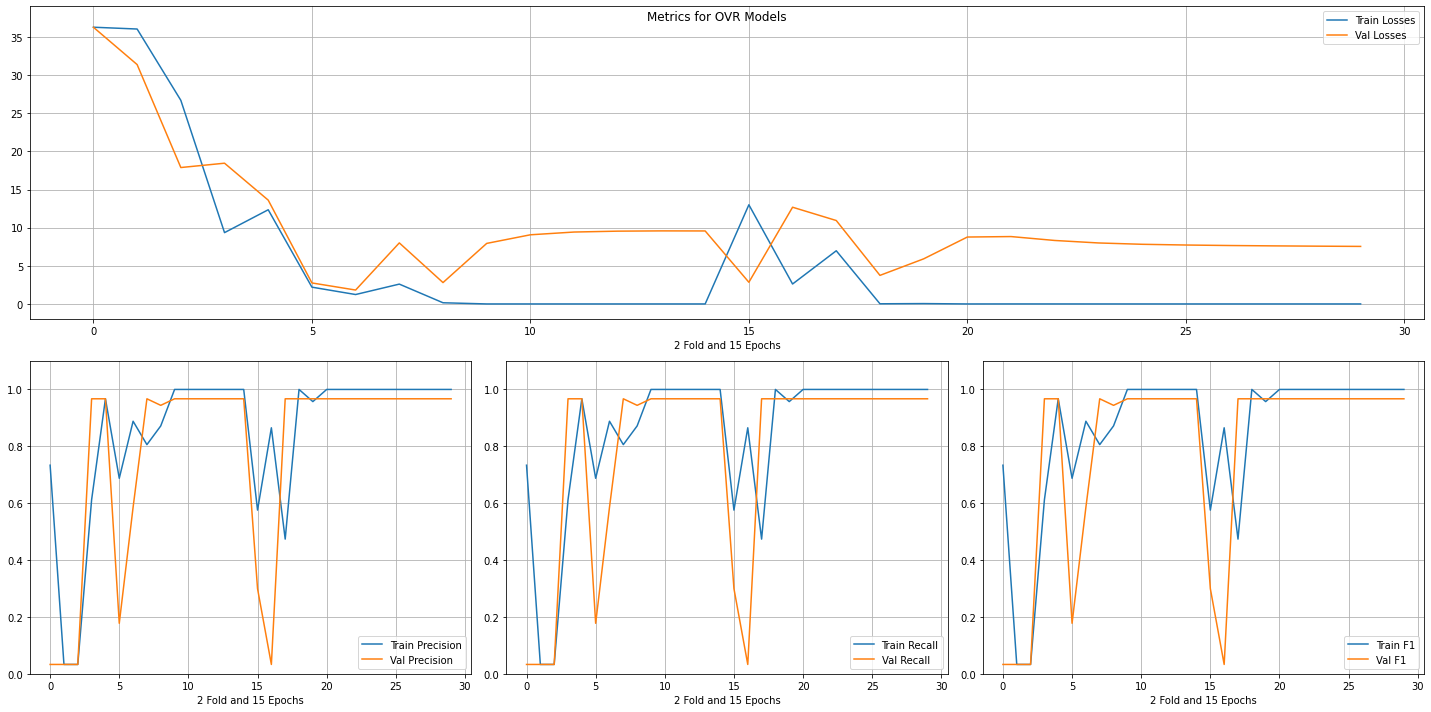

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.967105  ...      0.000038           7.541054
9   1.000000       0.967105  ...      0.000123           7.818626
7   1.000000       0.967105  ...      0.001633           8.319580
6   1.000000       0.967105  ...      0.002683           8.831268
5   1.000000       0.967105  ...      0.000155           8.769755
4   0.957237       0.967105  ...      0.046498           5.910508
3   1.000000       0.967105  ...      0.020581           3.743641
2   0.473684       0.967105  ...      6.968602          10.934139
10  1.000000       0.967105  ...      0.000066           7.723388
11  1.000000       0.967105  ...      0.000069           7.658299
14  1.000000       0.967105  ...      0.000111           9.566736
13  1.000000       0.967105  ...      0.000037           9.575382
12  1.000000       0.967105  ...      0.000059           9.540554
11  1.000000       0.967105  ...      0.000033           9.424578
10  1.0000

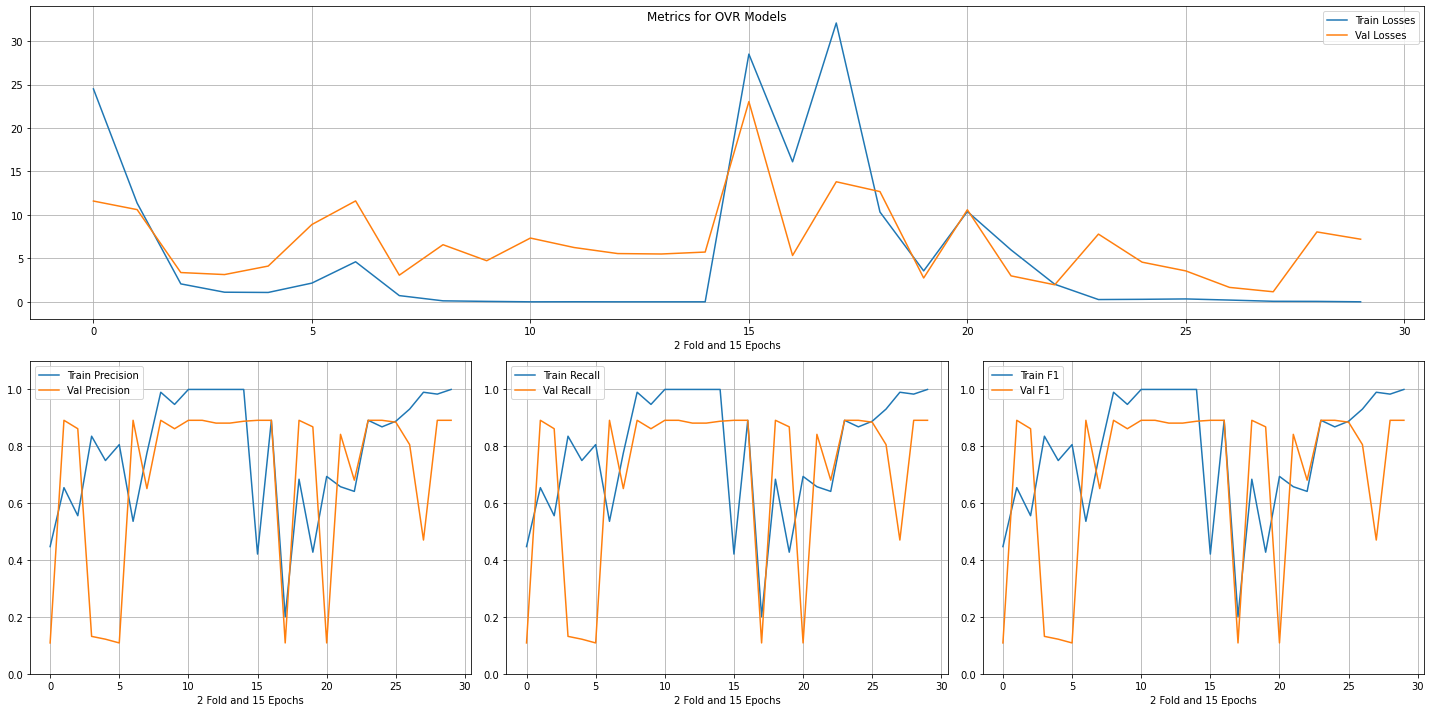

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.421053       0.891447  ...     28.510918          23.043712
10  1.000000       0.891447  ...      0.000889           7.339213
13  0.983553       0.891447  ...      0.049690           8.044664
9   0.868421       0.891447  ...      0.288599           4.563432
8   0.891447       0.891447  ...      0.261832           7.793833
3   0.684211       0.891447  ...     10.337889          12.686503
1   0.891447       0.891447  ...     16.116147           5.331289
1   0.654605       0.891447  ...     11.360297          10.611268
11  1.000000       0.891447  ...      0.007570           6.250090
14  1.000000       0.891447  ...      0.002154           7.205910
6   0.536184       0.891447  ...      4.607374          11.613797
8   0.990132       0.891447  ...      0.114171           6.574141
14  1.000000       0.888158  ...      0.000724           5.727263
10  0.888158       0.884868  ...      0.332404           3.557350
12  1.0000

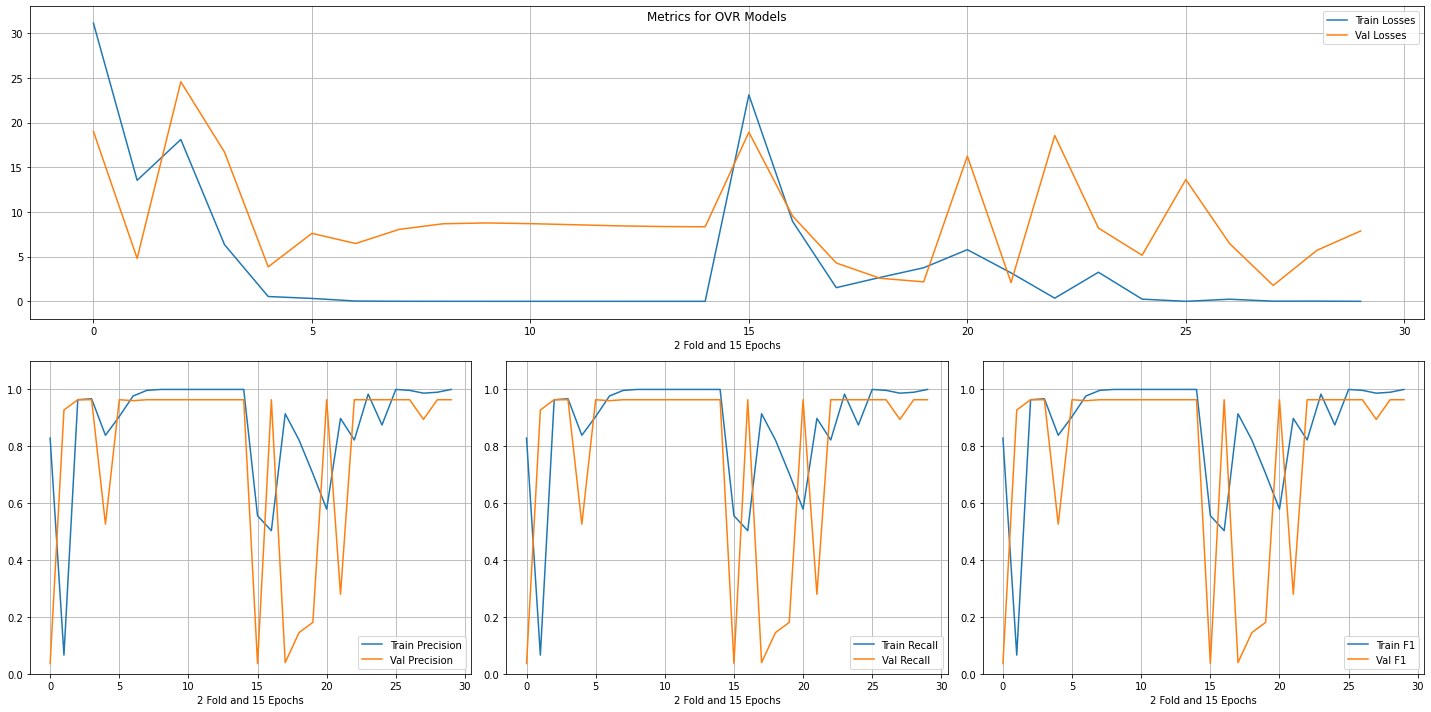

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.963816  ...  2.374748e-07           7.870924
12  1.000000       0.963816  ...  3.740437e-04           8.446539
11  0.996711       0.963816  ...  2.353252e-01           6.472015
10  1.000000       0.963816  ...  3.188251e-07          13.624385
9   0.875000       0.963816  ...  2.434152e-01           5.154908
8   0.983553       0.963816  ...  3.253231e+00           8.190487
7   0.822368       0.963816  ...  3.535255e-01          18.556199
5   0.578947       0.963816  ...  5.778533e+00          16.251212
1   0.503289       0.963816  ...  8.947760e+00           9.541839
13  0.990132       0.963816  ...  1.984258e-02           5.708440
13  1.000000       0.963816  ...  3.162453e-04           8.369605
14  1.000000       0.963816  ...  2.911215e-04           8.339966
11  1.000000       0.963816  ...  5.429118e-04           8.571091
10  1.000000       0.963816  ...  6.124180e-04           8.691204
9   1.0000

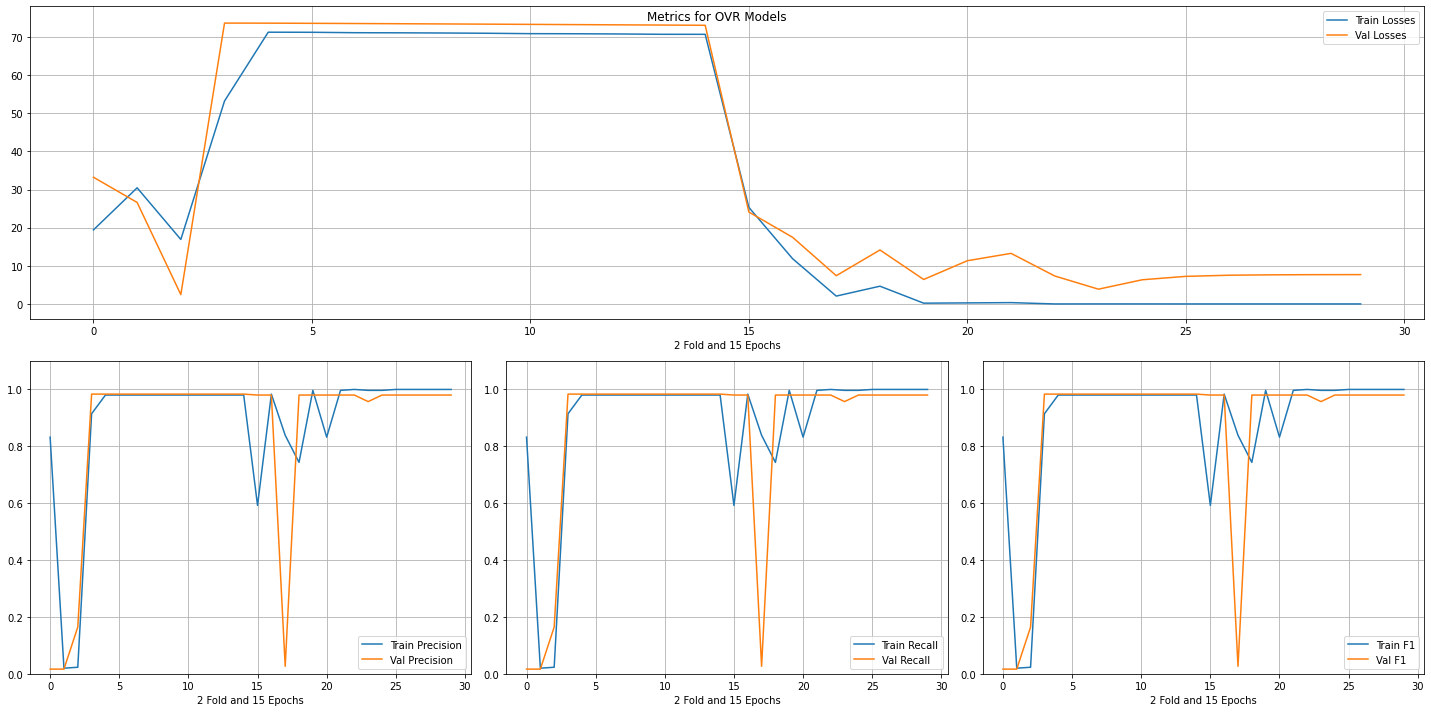

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.980263       0.983553  ...  7.085500e+01          73.287479
3   0.914474       0.983553  ...  5.319136e+01          73.625041
4   0.980263       0.983553  ...  7.123632e+01          73.605093
5   0.980263       0.983553  ...  7.121458e+01          73.563019
6   0.980263       0.983553  ...  7.110345e+01          73.512440
7   0.980263       0.983553  ...  7.107570e+01          73.458327
8   0.980263       0.983553  ...  7.102716e+01          73.402408
9   0.980263       0.983553  ...  7.095788e+01          73.345364
11  0.980263       0.983553  ...  7.083167e+01          73.228836
12  0.980263       0.983553  ...  7.077424e+01          73.169490
13  0.980263       0.983553  ...  7.068741e+01          73.109531
14  0.980263       0.983553  ...  7.067905e+01          73.048920
11  1.000000       0.980263  ...  1.588810e-06           7.530537
9   0.996711       0.980263  ...  6.117642e-03           6.333837
10  1.0000

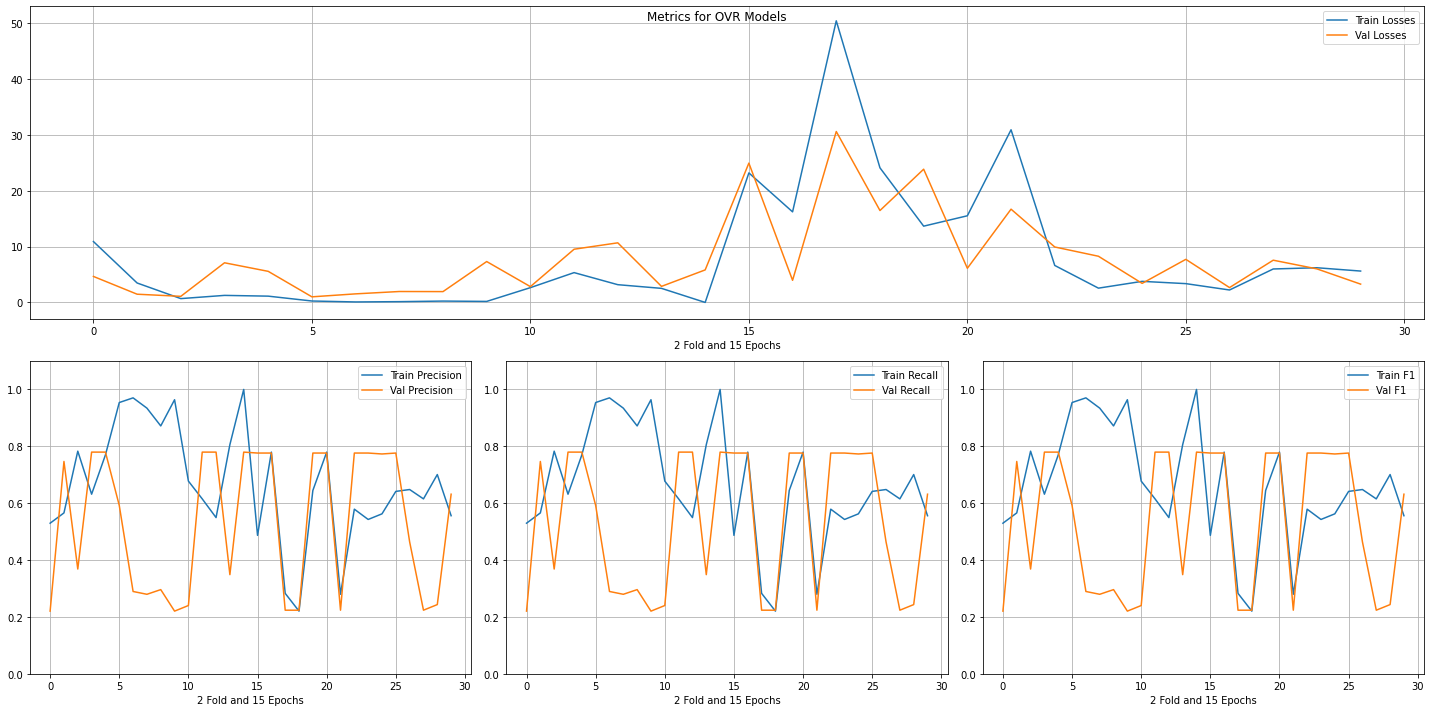

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.779605  ...      0.002471           5.824551
3   0.631579       0.779605  ...      1.262958           7.099641
4   0.769737       0.779605  ...      1.127255           5.567601
11  0.615132       0.779605  ...      5.340160           9.527844
12  0.549342       0.779605  ...      3.179418          10.672941
0   0.486842       0.776316  ...     23.190217          24.944898
10  0.641447       0.776316  ...      3.366936           7.716174
8   0.542763       0.776316  ...      2.559010           8.269882
7   0.578947       0.776316  ...      6.622215           9.929880
5   0.779605       0.776316  ...     15.514485           6.114136
4   0.644737       0.776316  ...     13.658033          23.854797
1   0.779605       0.776316  ...     16.216329           3.963718
9   0.562500       0.773026  ...      3.775597           3.412414
1   0.565789       0.746711  ...      3.480380           1.473358
14  0.5559

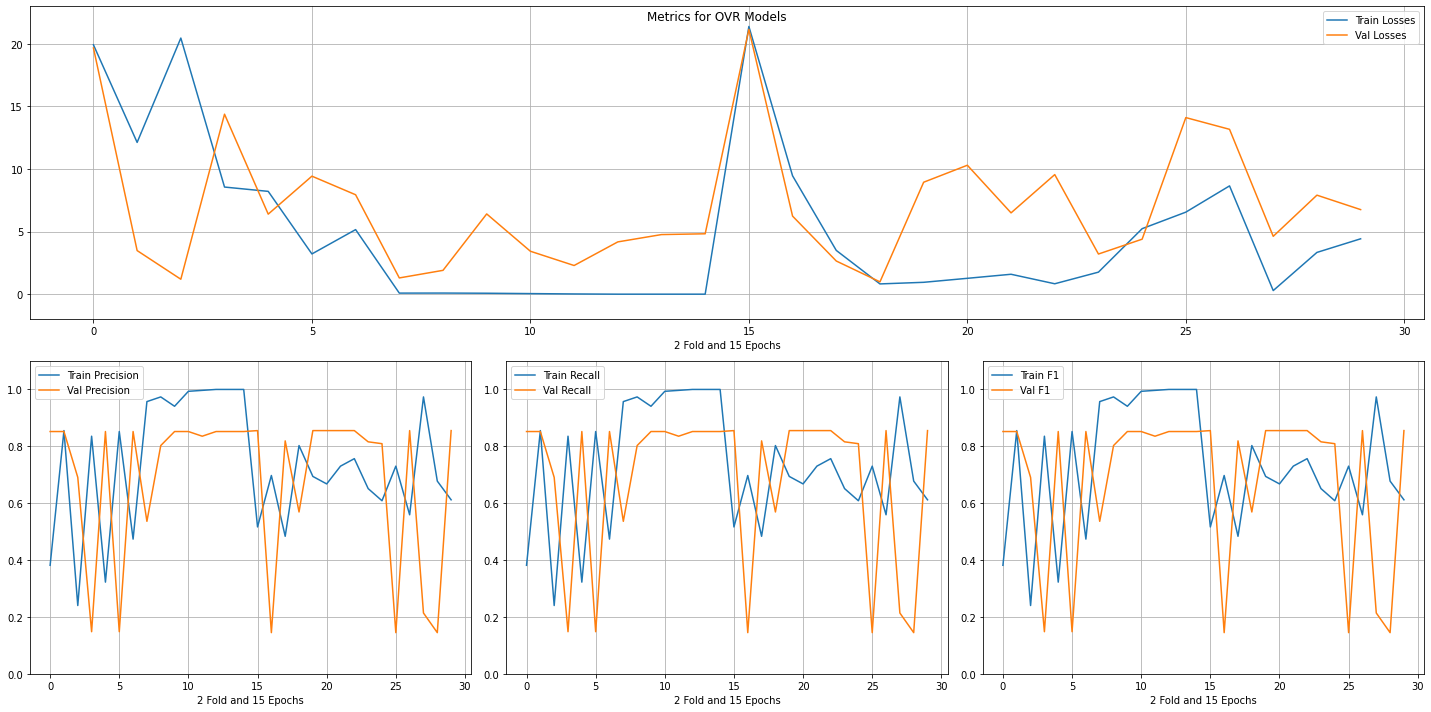

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.516447       0.855263  ...     21.396557          21.163078
4   0.694079       0.855263  ...      0.948517           8.947973
11  0.559211       0.855263  ...      8.654471          13.176049
7   0.756579       0.855263  ...      0.831763           9.557445
6   0.730263       0.855263  ...      1.591156           6.498129
5   0.667763       0.855263  ...      1.267720          10.304898
14  0.611842       0.855263  ...      4.425937           6.759237
0   0.381579       0.851974  ...     19.930560          19.681880
9   0.940789       0.851974  ...      0.075337           6.412908
10  0.993421       0.851974  ...      0.046198           3.430494
12  1.000000       0.851974  ...      0.000703           4.177909
13  1.000000       0.851974  ...      0.000372           4.763012
14  1.000000       0.851974  ...      0.000495           4.826314
1   0.855263       0.851974  ...     12.129237           3.485061
6   0.4736

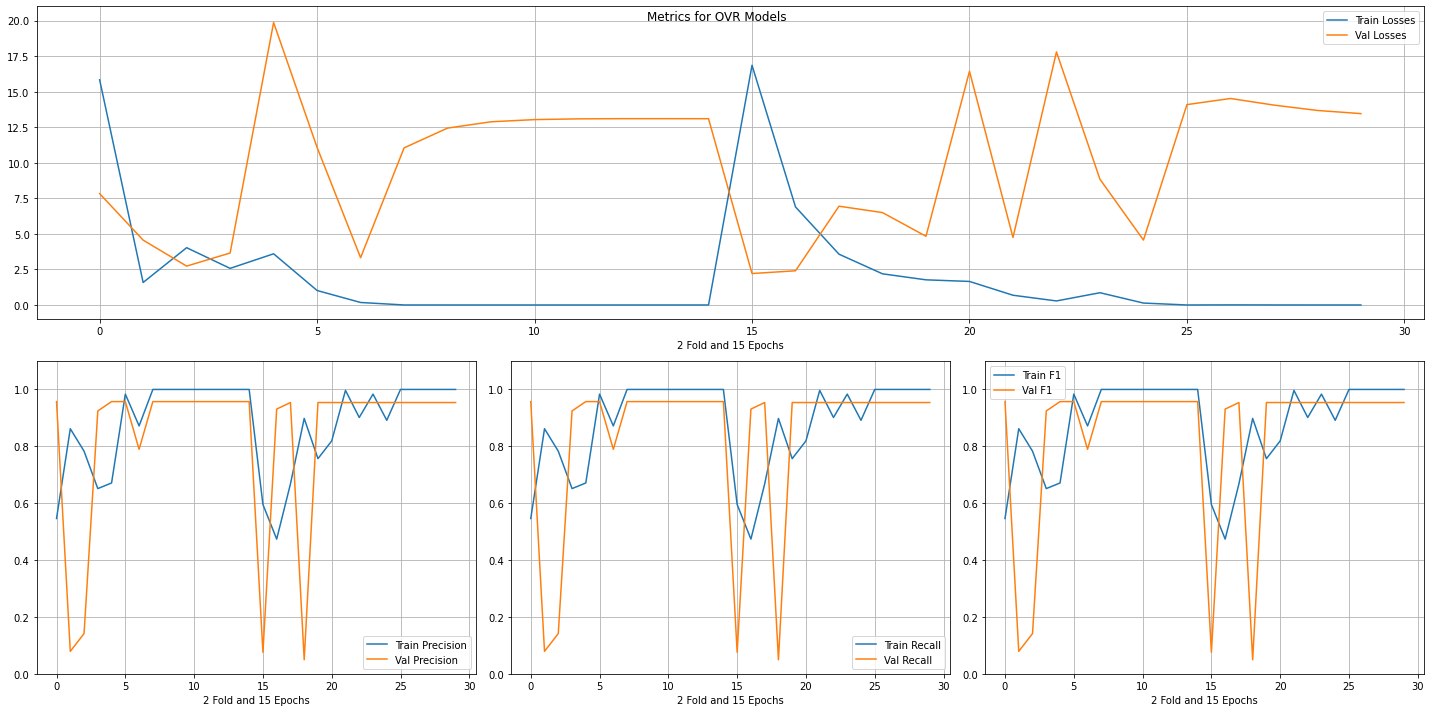

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.546053       0.957237  ...     15.837762           7.830023
8   1.000000       0.957237  ...      0.000003          12.441645
14  1.000000       0.957237  ...      0.000019          13.100852
13  1.000000       0.957237  ...      0.000028          13.104815
12  1.000000       0.957237  ...      0.000028          13.104340
11  1.000000       0.957237  ...      0.000023          13.089813
9   1.000000       0.957237  ...      0.000012          12.884688
10  1.000000       0.957237  ...      0.000016          13.037873
7   1.000000       0.957237  ...      0.001203          11.049117
5   0.983553       0.957237  ...      1.018257          11.080304
4   0.671053       0.957237  ...      3.600333          19.868181
11  1.000000       0.953947  ...      0.006957          14.523482
5   0.819079       0.953947  ...      1.655911          16.439332
12  1.000000       0.953947  ...      0.001998          14.057767
13  1.0000

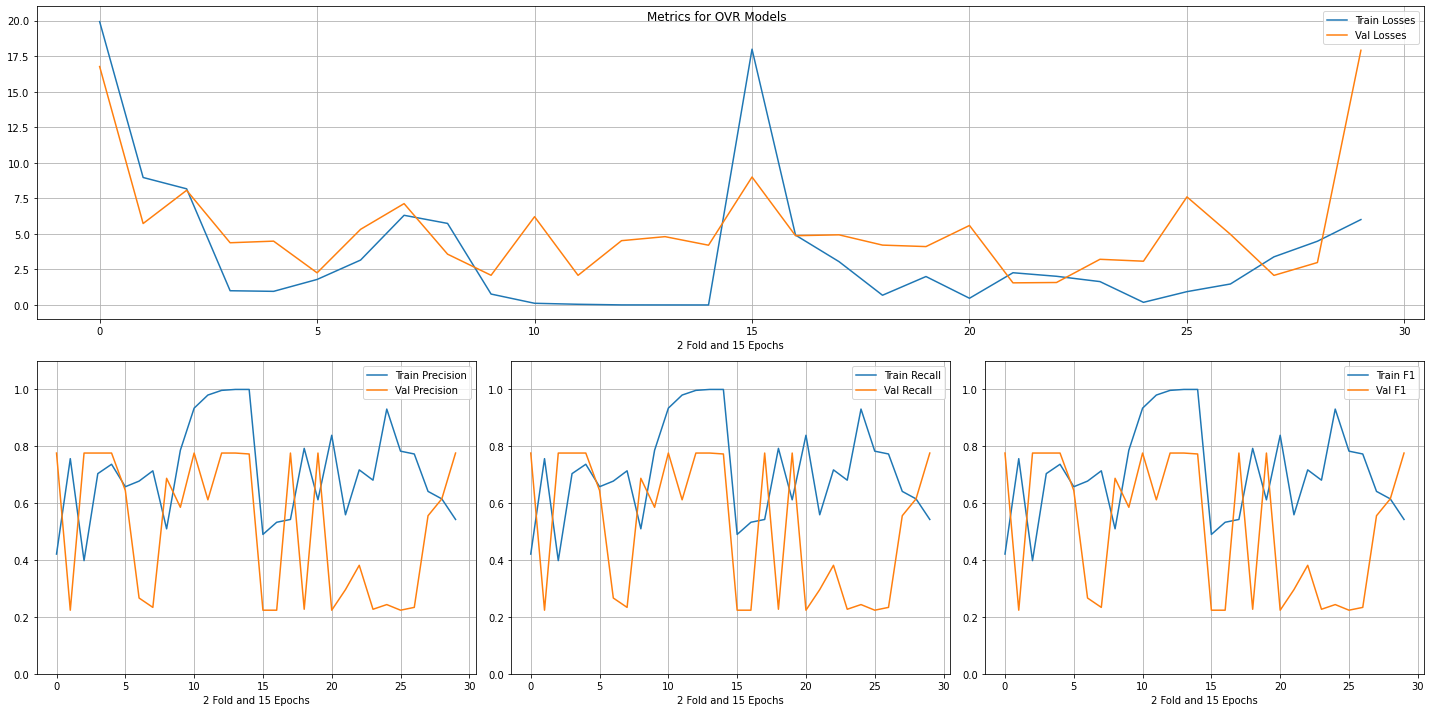

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.421053       0.776316  ...     19.928833          16.770281
10  0.934211       0.776316  ...      0.119533           6.208827
4   0.611842       0.776316  ...      2.001433           4.107767
2   0.542763       0.776316  ...      3.048908           4.933438
13  1.000000       0.776316  ...      0.003306           4.805936
12  0.996711       0.776316  ...      0.006086           4.523659
14  0.542763       0.776316  ...      6.007710          17.914116
4   0.736842       0.776316  ...      0.958710           4.490052
3   0.703947       0.776316  ...      1.002179           4.376756
2   0.398026       0.776316  ...      8.169899           8.065044
14  1.000000       0.773026  ...      0.001259           4.204253
8   0.509868       0.687500  ...      5.736546           3.573797
5   0.657895       0.644737  ...      1.795817           2.262265
13  0.615132       0.615132  ...      4.483110           2.985824
11  0.9802

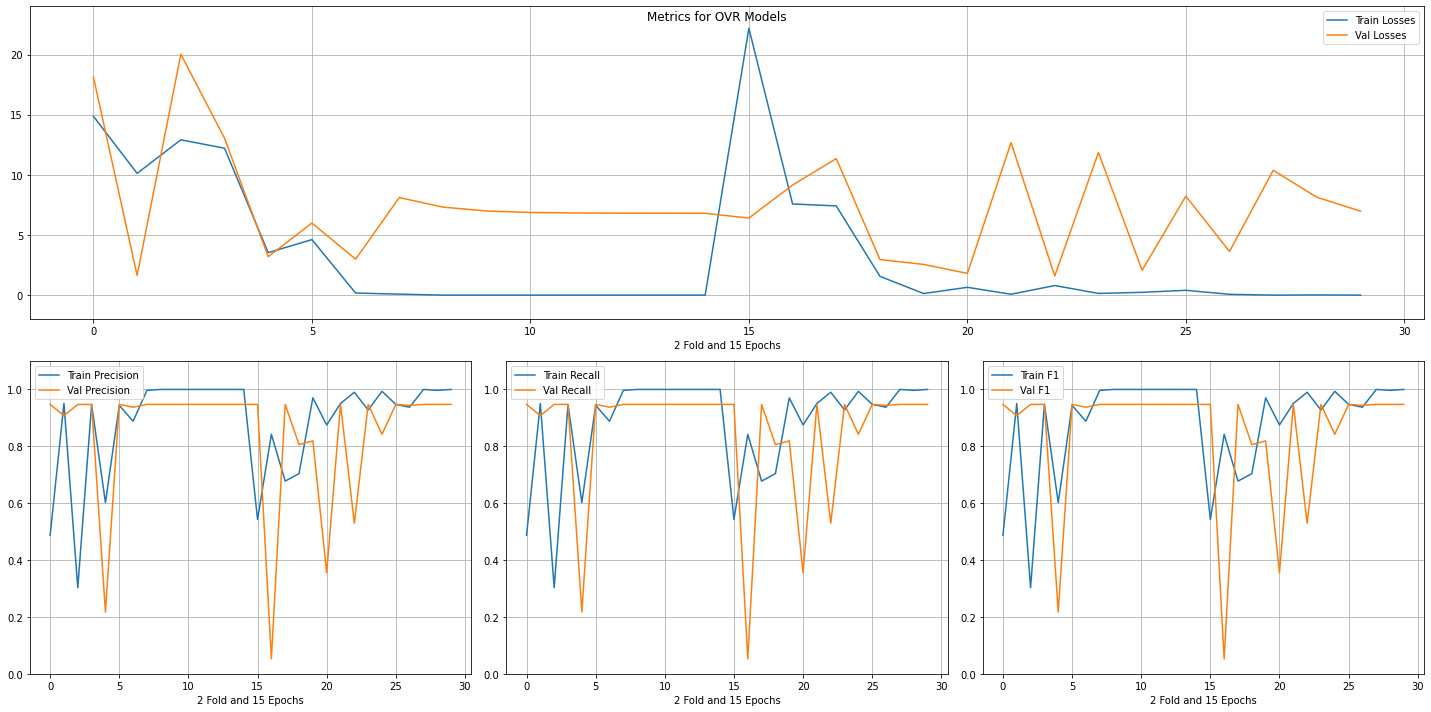

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.486842       0.947368  ...  1.486507e+01          18.120068
11  1.000000       0.947368  ...  7.910888e-07           6.827317
13  0.996711       0.947368  ...  1.644566e-02           8.134040
12  1.000000       0.947368  ...  5.589408e-05          10.375755
10  0.947368       0.947368  ...  4.014568e-01           8.228491
8   0.927632       0.947368  ...  1.424999e-01          11.864646
6   0.950658       0.947368  ...  7.415062e-02          12.679237
2   0.677632       0.947368  ...  7.414568e+00          11.347985
14  1.000000       0.947368  ...  6.755389e-07           6.802667
13  1.000000       0.947368  ...  5.944744e-07           6.804799
12  1.000000       0.947368  ...  7.073423e-07           6.810783
0   0.542763       0.947368  ...  2.218213e+01           6.404884
10  1.000000       0.947368  ...  8.603144e-07           6.872516
9   1.000000       0.947368  ...  9.503446e-07           6.994478
2   0.3026

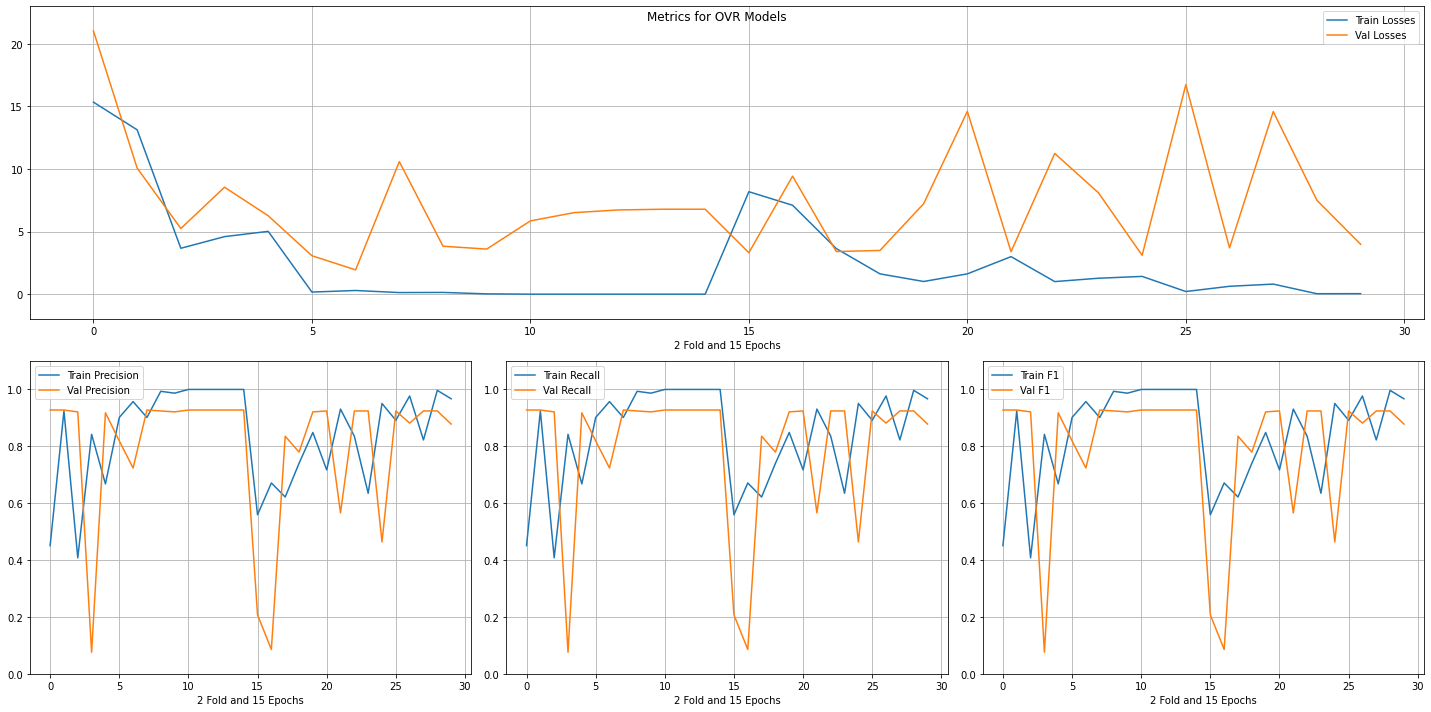

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.450658       0.927632  ...     15.347323          21.039638
7   0.901316       0.927632  ...      0.128858          10.592130
1   0.924342       0.927632  ...     13.136595          10.082153
14  1.000000       0.927632  ...      0.000046           6.789972
13  1.000000       0.927632  ...      0.000067           6.788211
12  1.000000       0.927632  ...      0.000042           6.730153
11  1.000000       0.927632  ...      0.000026           6.516227
10  1.000000       0.927632  ...      0.000118           5.856627
8   0.993421       0.924342  ...      0.139354           3.833191
5   0.717105       0.924342  ...      1.623655          14.609863
12  0.822368       0.924342  ...      0.805119          14.595062
13  0.996711       0.924342  ...      0.037045           7.503696
10  0.891447       0.924342  ...      0.211920          16.737824
8   0.634868       0.924342  ...      1.273669           8.104628
7   0.8355

In [111]:
jovr_res_reduced = ovr_train_model(rdata, MfccMatrixJanakaRagaDataset, MfccRaga, "OVR Models", jlabels1, cl, lbl_encoder=jle, target='JanakaRagamCode')